In [1]:
# Import different packages.

import numpy as np
import scipy.signal as sig
import scipy.io as sio
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from importlib import reload  
import os
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind 
from scipy.stats.distributions import norm    
from scipy.signal import butter, lfilter

import warnings
warnings.filterwarnings('ignore')

# Microstates package
from eeg_microstates import clustering
from eeg_microstates import topo, eeg2map, bp_filter, locmax


# Custom packages. These are used to extract information quicker and run kfold tests (and such).
import microstates_helper as mic # extracts microstate data, etc
import gvs_helper as gvs # extracts gvs data, etc
import models as mod # model creation : regression, kfolt tests, ttests, printing their significance

## 1) Constants, parameters


In [2]:
FS = 500 # Frequency of EEG data (Hz)
mode = 'kmeans' # cluster method for microstates analysis
n_maps = 4 # number of microstate clusters

bandpass_filter = [1, 35] # bandpass filter done before microstates are applied

# We can cache extracted microstate data to get to later data analysis faster on repeated runs
# If false, will generate new data. (Overwriting last cache)
LOAD_CACHED = True

###############################
# Time embedding
# ex: perform microstate on time embedded data, so that it wavelets include times
###############################
TIME_EMBEDDING = False # whether the microstates should be time-embedded or not
TIME_EMBEDDING_VALUE = 23 # the frequency, in Hz, that we are performming a time embedding at
TIME_EMBEDDING_DIMENSIONS = 2

###############################
# Analysis parameters
###############################
MIXEDLM_GROUPING = 'Age_Binned' # how we group the mixed linear model. must be a parameter of the DF made later
MIXEDLM_THRESHOLD = 0.05  

###############################
# Define electrode data
###############################
# - Channel values are derived from eeg_microstates provided cap.xyz
# - Several channels are interpolated based on their positions and those values

# Mask for which channels to be active (can disable)
# - Disabled channels may be improperly marked- activating them creates strange clusters
mask = np.array([True for _ in range(27)])
mask[14] = False # CP5
mask[15] = False # CP6

# EEG caps have specific named electrodes in unique 3d positions: [front-back, left-right, center]
# We define these *3d positions* for each named electrode, in the same order they are saved in our dataset
electrodes = {
    'FP1': [-2.7,8.6, 3.6],
    'FPZ': [0.0,8.6,3.6], ### INTERPOLATED
    'FP2': [2.7,8.6, 3.6],
    'F7': [-6.7, 5.2, 3.6],
    'F3': [-4.7, 6.2, 8.0],
    'FZ': [0.0, 6.7, 9.5],
    'F4': [4.7, 6.2, 8.0],
    'F8': [6.7, 5.2, 3.6],
    'FC5': [-6,3.2,9.4], ### INTERPOLATED
    'FC6': [6,3.2,9.4] , ### INTERPOLATED
    'T7': [-7.8, 0.0, 3.6],
    'C3': [-6.1, 0.0, 9.7],
    'Cz': [0.0, 0.0, 12.0],
    'C4': [6.1, 0.0, 9.7],
    'CP5': [-7.2, -2.7, 6.6],
    'CP6': [7.2, -2.7, 6.6],
    'A2': [12.2, -0.5, 0],  ### INTERPOLATED
    'P7': [-6.7, -5.2, 3.6], 
    'P3': [-4.7, -6.2, 8.0], 
    'PZ': [0.0, -6.7, 9.5],
    'P4': [4.7, -6.2, 8.0],
    'P8': [6.7, -5.2, 3.6],
    'PO5': [-5.5, -7.8, 8.0], ### INTERPOLATED
    'PO6': [5.5, -7.8, 8.0], ### INTERPOLATED 
    'O1': [-2.7, -8.6, 3.6],
    'OZ': [0.0, -8.6, 3.6],  ### INTERPOLATED
    'O2': [2.7, -8.6, 3.6]
}

# List of channel names (extracted from above dict)
chs = np.array([k for k in electrodes.keys()])[mask]

# The channel locations as (numchans x 3) matrix (from above dict)
locs = np.array([k for k in electrodes.values()])[mask]


## 1) EEG preprocessing

- Read EEG data and put it into the correct format
- Customize as appropriate to whatever dataset is being used:

In [3]:
#############################
#### Load data. 
#### Customize this section if loading data from a different format.
#### Requirement is the listed variables + shapes at the end of this cell.
#############################

data  = sio.loadmat('READY4DL_500.mat')

data_hc_gvsoff = np.array([[np.array(t) for t in p] for p in data['ALL_HC_GVS_OFF']])
data_pdon_gvsoff = np.array([[np.array(t) for t in p] for p in data['ALL_PD_GVSOFF_MEDON']])
data_pdoff_gvsoff = np.array([[np.array(t) for t in p] for p in data['ALL_PD_GVSOFF_MEDOFF']])
data_hc_gvson = np.array([[np.array(t) for t in p] for p in data['ALL_HC_GVS_ON']])
data_pdon_gvson = np.array([[np.array(t) for t in p] for p in data['ALL_PD_GVSON_MEDON']])
data_pdoff_gvson = np.array([[np.array(t) for t in p] for p in data['ALL_PD_GVSON_MEDOFF']])

# combined gvsoff of all patient types
full_gvsoff_x = np.r_[data_hc_gvsoff,data_pdon_gvsoff,data_pdoff_gvsoff]
full_gvsoff_class = np.r_[0*np.ones(shape=(data_hc_gvsoff.shape[0])), # 0 = hc
                         1*np.ones(shape=(data_pdon_gvsoff.shape[0])), # 1 = pdon
                         2*np.ones(shape=(data_pdoff_gvsoff.shape[0]))] # 2 = pdoff

# combined gvson of all patient types
full_gvson_x = np.r_[data_hc_gvson,data_pdon_gvson,data_pdoff_gvson]
full_gvson_class = np.copy(full_gvsoff_class)


# combined all types (gvson classes are offset by 3 [number of gvsoff classes])
full_combined_x = np.r_[full_gvsoff_x,full_gvson_x]
full_combined_class = np.r_[full_gvsoff_class,
                           full_gvson_class+len(np.unique(full_gvsoff_class))]


# # # full_gvs<>_x but with pd classes combined 
# full_gvsoff_class_pd = np.ceil(full_gvsoff_class / 2) # 0 = hc, 1 = pd
# full_gvson_class_pd = np.ceil(full_gvson_class / 2) # 0 = hc, 1 = pd


# useful values for shape calculations
num_pt, num_tr, num_sam, num_chan = full_combined_x.shape
num_sam = num_sam * num_tr

# Combine trials into one (for our sample data, trials are immediately sequential). now patient x sample x channel
full_gvsoff_x = full_gvsoff_x.reshape((full_gvsoff_x.shape[0],num_sam,num_chan))
full_gvson_x = full_gvson_x.reshape((full_gvson_x.shape[0],num_sam,num_chan))
full_combined_x = full_combined_x.reshape((num_pt,num_sam,num_chan))

#############################
#### This data can come from any source. However.
#### gvsoff and gvson should have the same order of subjects- just with stimulation off and on, respectively
#### The following data should exist in the following shapes.
#############################

# full_gvsoff_x  => (gvsoff number of patients x time samples (in 'FS' Hz) x electrode channels) => GVS off signals
# full_gvsoff_class => (gvsoff patients x 1) => GVS off classes (0 = HC, 1 = PD, 2 = PDOFF)

# full_gvson_x  => (gvson number of patients x time samples (in 'FS' Hz) x electrode channels) => GVS on signals
# full_gvson_class => (gvson patients x 1) => GVS on classes (0 = HC GVS ON, 1 = PD GVS ON, 2 = PDOFF GVS ON)


# full_combined_x => (number of patients x time samples (in 'FS' Hz) x electrode channels) => All EEG signals 
# full_combined_class => (all patients x 1) => All patient classes (0 = HC, 1 = PD, 2 = PDOFF, GVS+ is same but 3,4,5)


## 2) Time embedding (if applicable)

- if 'TIME_EMBEDDING' is set as true, do not use EEG data in microstate calculation, but use time-embedded wavelets extracted from the EEG data
- in (3), we will use the time-embedded ones and save it separately. If time-embedded or non-time-embedded doesn't exist, we will generate it.

In [4]:
###############################
# Set up time embedding.
# Can use other data as long as it ends up shaped correctly at the end.
###############################

if TIME_EMBEDDING:
    if  os.path.exists('abstr/time_embedded_data.npy'):    
        DELAY_FREQ = TIME_EMBEDDING_VALUE # in Hz

        FIRST_FREQ_TIME = (1/DELAY_FREQ) # in seconds, time of first iteration of delay_freq
        SAMPLE_FREQ = 500
        DELAY_IN_SAMPLES = int(SAMPLE_FREQ*FIRST_FREQ_TIME) # how many samples to delay over

        DIMENSIONS = TIME_EMBEDDING_DIMENSIONS # accordng to paper, 10 did well (but that was with 11 channels)

        # Function
        # data = dataset
        # delay = delay to time embed
        # dimension = dimensionality
        def takensEmbedding (data, delay, dimension):
            "This function returns the Takens embedding of data with delay into dimension, delay*dimension must be < len(data)"
            if delay*dimension > len(data):
                raise NameError('Delay times dimension exceed length of data!')    
            embeddedData = np.array([data[0:len(data)-delay*dimension]])
            for i in range(1, dimension):
                embeddedData = np.append(embeddedData, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)
            return embeddedData;

        def butter_bandpass(lowcut, highcut, fs, order=5):
            nyq = 0.5 * fs
            low = lowcut / nyq
            high = highcut / nyq
            b, a = butter(order, [low, high], btype='band')
            return b, a


        def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
            b, a = butter_bandpass(lowcut, highcut, fs, order=order)
            y = lfilter(b, a, data)
            return y

        # First, run a butter filter over the data _before_ the embedding
        # (We won't do it during microstate code if we do it here)
        num_pts,_,num_chs = full_data_x.shape
        for i in range(num_pts):
            for j in range(num_chs):
                full_data_x[i,:,j] = butter_bandpass_filter(full_data_x[i,:,j],2,34,500)

                
        # Perform the full dimensional time-embedding 
        time_embedded_data = np.zeros(shape=(*full_data_x.shape,DIMENSIONS))

        for i in range(num_pts):
            for j in range(num_chs):
        #         full_data_x[i,:,j] = butter_bandpass_filter(full_data_x[i,:,j],2,34,500)
                tmp = takensEmbedding(full_data_x[i,:,j],DELAY_IN_SAMPLES,DIMENSIONS).T
                time_embedded_data[i,:tmp.shape[0],j,:] = tmp

                # Ensure shape is correct (no excess zeroes)
                time_embedded_data = time_embedded_data[:,:tmp.shape[0],:,:]
        np.save('abstr/time_embedded_data',time_embedded_data)

    time_embedded_data=np.load('abstr/time_embedded_data.npy')

#############################
#### At this point, confirm we have correct data shapes.
#### The following data should exist in the following shapes.
#### This data is needed ONLY if the time embedded is true.
#############################

# time_embedded_data => shape: (num_pts x time x channels x dims)


## 3) Microstate generation

- Read EEG data and convert it into microstates.
- When running this code, it will ask you to confirm the order of states.

Map A has a diagonal direction connecting the upper (frontal) left and lower (occipital) right corners, 

map B is diagonal in the opposite direction, 

map C has a horizontal orientation

and map D is often circular (or often a vertical orientation). 


For example, if the maps seem to be in order BCAD, you would type in 2013

Quote:

*"Sometimes, slightly different maps are generated. We mostly observed the occurrence of a map D with a vertical axis instead of a circular pattern. In this case, you can either accept the results and proceed, or re-cluster the data set as the results of the K-means algorithm differ between runs.
Modified K-means clustering and all information-theoretical computations can be run for any number of microstates. The desired number of microstates is given by the user as the argument 'n_maps' of the 'kmeans' function. If n_maps is not provided, the default value n_maps=4 is used."*

In [5]:
#############################
#### Extract microstates from EEG data.
#############################

# Throw error if we load from non-existent cache
if LOAD_CACHED:
    if TIME_EMBEDDING and not os.path.exists('abstr/time_embedded_data.npy'):
        raise Exception("Could not find cached time-embedded data. Turn off LOAD_CACHED to generate it.")
    if not TIME_EMBEDDING and not os.path.exists('abstr/microstate_x.npy'):
        raise Exception("Could not find cached non-time-embedded data. Turn off LOAD_CACHED to generate it.")


# Generate new cache of microstate data.
if not LOAD_CACHED:
    
    combined_full_data_x = 0
    
    if TIME_EMBEDDING:
        # flatten 
        flattened_data = time_embedded_data.reshape((num_patients,time_samples,num_channels*num_dims))

        # Combines patients into one to perform microstate k-means on.
        combined_full_data_x = flattened_data.reshape(-1,flattened_data.shape[-1])
        full_data_x_shape = combined_full_data_x.shape
    
    else:
        # Bandpass filter on raw EEG
        full_data_x_bp = np.array([bp_filter(pt, bandpass_filter[0], bandpass_filter[1], FS) for pt in full_combined_x])
    
        # Combines patients into one to perform microstate k-means on.
        full_data_x_shape = full_data_x_bp.shape
        combined_full_data_x = full_data_x_bp.reshape(-1,full_data_x_shape[-1]) # (subj * time) x channels

    print("Clustering algorithm: {:s}".format(mode))

    # Apply clustering algorithm
    # maps => linear combination of channels that identify each microstate
    # x => time series of varying microstates
    # gev => global explained variance
    maps, x, _, gev = clustering(combined_full_data_x[:,mask], FS, chs, locs, mode, n_maps, doplot=True, plotid = "combined")
       
    # --- GFP peaks ---
    # The points at which channels most diverge (the key points for clustering)
    # GFP peaks are not saved from clustering module so we calculate after
    # they are inconsistently sized between subjects and cannot be separated easily
    gfp_peaks = []
    for ptid, pt in enumerate(full_data_x_bp):
        gfp = np.nanstd(pt, axis=1)
        gfp_peaks.append (len(locmax(gfp))) # locmax in eeg_microstates.py
    gfp_peaks = np.array(gfp_peaks) # we only save the length => only value used
    

    # Reshape x array into former shape, without last dimension
    # microstate_x.shape => subjects x time_samples

    microstate_x = x.reshape(full_data_x_shape[:-1])
        
    downsized_x = [np.array(mic.downsize_sequence(x,FS)[0]) for x in microstate_x]
    downsized_times = [np.array(mic.downsize_sequence(x,FS)[1]) for x in microstate_x]
    
    
    if TIME_EMBEDDING:
        np.save('abstr/te_microstate_x',microstate_x)
        np.save('abstr/te_gfp_sep',gfp_peaks)
        np.save('abstr/te_gev',gev)
        np.save('abstr/te_maps',maps)
        np.save('abstr/te_downsized_x',downsized_x)
        np.save('abstr/te_downsized_times',downsized_times)
    else:
        np.save('abstr/microstate_x',microstate_x)
        np.save('abstr/gfp_sep',gfp_peaks)
        np.save('abstr/gev',gev)
        np.save('abstr/maps',maps)
        np.save('abstr/downsized_x',downsized_x)
        np.save('abstr/downsized_times',downsized_times)

    
####################################
# Load existing data, or just saved data
####################################
else:
    if TIME_EMBEDDING:
        microstate_x=np.load('abstr/te_microstate_x.npy')

        ### We print the maps so we can see them.
        ### (When clustering time embeds, we don't see it, so this lets us see it)
        maps_unshaped = maps.reshape(n_maps,-1,TIME_EMBEDDING_DIMENSIONS)
        diff = maps_unshaped[:,:,1] - maps_unshaped[:,:,0]
        plt.ion()
        # matplotlib's perceptually uniform sequential colormaps:
        # magma, inferno, plasma, viridis
        cm = plt.cm.magma
        fig, axarr = plt.subplots(TIME_EMBEDDING_DIMENSIONS, n_maps, figsize=(20,5))
        fig.patch.set_facecolor('white')
        for imap in range(n_maps*TIME_EMBEDDING_DIMENSIONS):
            axarr[int(imap/n_maps),imap%n_maps].imshow(eeg2map(maps_unshaped[imap%n_maps,:,int(imap/n_maps)],channels=chs,locs=locs), cmap=cm, origin='lower')
            axarr[int(imap/n_maps),imap%n_maps].set_xticks([])
            axarr[int(imap/n_maps),imap%n_maps].set_xticklabels([])
            axarr[int(imap/n_maps),imap%n_maps].set_yticks([])
            axarr[int(imap/n_maps),imap%n_maps].set_yticklabels([])
            title = "Microstate maps ({:s})".format(mode.upper())
            axarr[0,0].set_title(title, fontsize=16, fontweight="bold")
        plt.show()
        
        gfp_peaks=np.load('abstr/te_gfp_sep.npy')
        gev=np.load('abstr/te_gev.npy')
        maps=np.load('abstr/te_maps.npy')
        downsized_x=np.load('abstr/te_downsized_x.npy', allow_pickle = True)
        downsized_times=np.load('abstr/te_downsized_times.npy', allow_pickle = True)

    else:
        microstate_x=np.load('abstr/microstate_x.npy')

        gfp_peaks=np.load('abstr/gfp_sep.npy')
        gev=np.load('abstr/gev.npy')
        maps=np.load('abstr/maps.npy')
        downsized_x=np.load('abstr/downsized_x.npy', allow_pickle = True)
        downsized_times=np.load('abstr/downsized_times.npy', allow_pickle = True)


## 4) Load patient-specific data
- Such as gender, age, GVS information, and so on.


In [6]:
#######################
#### Load GVS data.
#### We load from our gvs helper package, but can load it any way we like as long as the variables match at the end of the cell.
#######################

gvs_feature_names = gvs.get_improved_feats()

# Load a matrix of binary values for whether it improved
improved_binary_matrix = np.array([gvs.get_improved_binary_matrix(i) for i,_ in enumerate(gvs_feature_names)])
num_gvs_features, num_patients, num_stim = improved_binary_matrix.shape

improved_binary_matrix = np.transpose(improved_binary_matrix, (1, 0, 2))
improved_binary_matrix = improved_binary_matrix.reshape(improved_binary_matrix.shape[0],-1)

# Load a matrix of binary values for whether it improved
improved_amount_matrix = np.transpose(gvs.get_improved_amount_matrix(),[1,0,2])
improved_amount_matrix = improved_amount_matrix.reshape(len(improved_amount_matrix),-1)



# Create pandas feature
df = {
            'ID': np.arange(62),
            'Age': gvs.get_ages(),
            'Gender': gvs.get_genders(),
            'UPDRS' : gvs.get_updrs(),
            'Status': np.r_[np.zeros(22),np.ones(20),np.ones(20)*2],
            'Age_Binned': np.digitize(gvs.get_ages(), np.linspace(np.min(gvs.get_ages(),),np.max(gvs.get_ages(),),5))            
}

PATIENT_DATAFRAME =  pd.DataFrame(df)

#############################
#### At this point, confirm we have correct data shapes.
#### The following data should exist in the following shapes.
#############################

# PATIENT_DATAFRAME => pandas dataframe with the following columns
#      => ID => a unique ID from 0-62
#      => Gender => 0 or 1 gender
#      => Age => int, their ages)
#      => Age_Binned => their ages, but binned into fewer intervals (for potential classification)
#      => Status => number of GVSoff (their PD class, from 0-2 [their class value])


# feat_names => list of strings, length of number of extracted features
# gvs_feature_names => list of strings, length of number of features to improve with GVS (reaction time, etc)

# feature_matrix => matrix of features: (number of total subjects) x (number of extracted features)
# improved_binary_matrix => matrix of binary values. (number of total subjects) x (number of stim-feat combinations)
# improved_amount_matrix => matrix of integer values. (number of total subjects) x (number of stim-feat combations). THIS MAY BE DIFFERENT SIZE THAN IMPROVED_BINARY_MATRIX if you have different amounts of for it.


task_gvssham.mat
task_gvsstim7.mat
task_gvsstim8.mat


## 4) Extract microstate features

- Feature extraction includes everything from transition matrices to AIF

In [7]:
# Create feature matrix using our microstate toolbox, and the dataset
feature_matrix = np.c_[
    mic.load_feature_data(microstate_x,False),
    mic.load_feature_data(downsized_x,True),
    np.array([mic.time_feats(x) for x in downsized_times]),
    mic.metastate_features(microstate_x)
]

# List of feature names
feat_names = mic.feat_names() + ["downsized-"+m for m in mic.feat_names()] + mic.time_feature_names() + mic.meta_feature_names()


# Drop any feature for which all values are the same, or immeasurably small differences (not a useful feature)
# feature_matrix.T[np.any(feature_matrix-,axis=0)].shape
no_unique_mask = np.any(np.round(feature_matrix-feature_matrix[0,:],5),axis=0)
feature_matrix = feature_matrix[:,no_unique_mask]
feat_names = np.array(feat_names)[no_unique_mask]


## 5) Rudimentary PD class differentiation

- Using our extracted features, can any of these differentiate between the different classes (such as PDON/OFF/HC/GVSON/etc)?

- We do a SVM cross validation and a t-test between different groups of classes

###############################
Cross validation score for 3-class p_empirical_0: 0.1790 ±0.1024
Cross validation score for 2-class p_empirical_0: 0.6050 ±0.0371
HC mean: 0.2562 ± 0.0270
PDON mean: 0.2495 ± 0.0172
PDOFF mean: 0.2466 ± 0.0244
PD-COMB mean: 0.2466 ± 0.0264


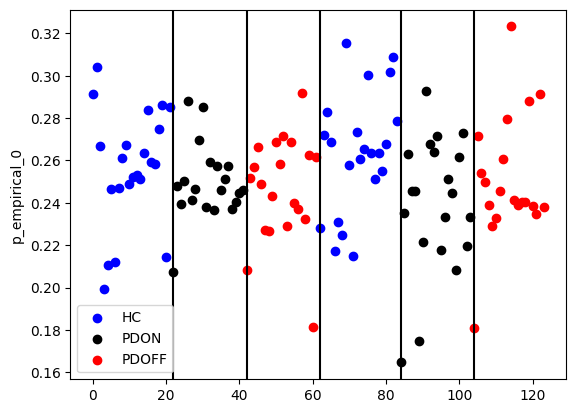

HC vs PDON: p=0.3603
HC vs PDOFF: p=0.2453
PDON vs PDOFF: p=0.6716
HC vs PD-COMB: p=0.9016
(GVS) HC vs PDON: p=0.0130
(GVS) HC vs PDOFF: p=0.1569
(GVS) PDON vs PDOFF: p=0.2493
(GVS) HC vs PD-COMB: p=0.0234
GVS- HC vs GVS+ HC: p=0.3752
GVS- PDON vs GVS+ PDON: p=0.2287
GVS- PDOFF GVS+ PDOFF: p=0.6220
GVS- vs GVS+: p=0.8682
###############################
Cross validation score for 3-class p_empirical_1: 0.1050 ±0.0546
Cross validation score for 2-class p_empirical_1: 0.6453 ±0.0107
HC mean: 0.2525 ± 0.0297
PDON mean: 0.2481 ± 0.0252
PDOFF mean: 0.2486 ± 0.0216
PD-COMB mean: 0.2489 ± 0.0267


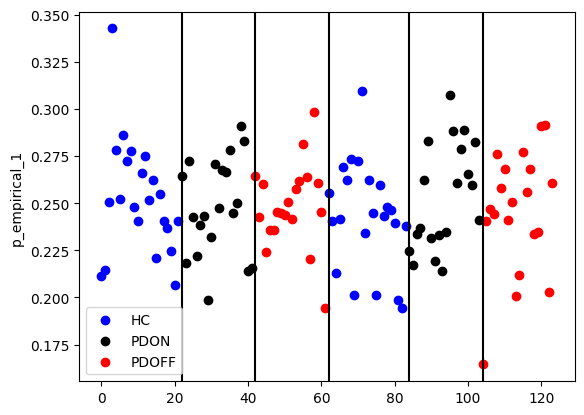

HC vs PDON: p=0.6191
HC vs PDOFF: p=0.6403
PDON vs PDOFF: p=0.9495
HC vs PD-COMB: p=0.9486
(GVS) HC vs PDON: p=0.2566
(GVS) HC vs PDOFF: p=0.7617
(GVS) PDON vs PDOFF: p=0.4548
(GVS) HC vs PD-COMB: p=0.4125
GVS- HC vs GVS+ HC: p=0.2951
GVS- PDON vs GVS+ PDON: p=0.5596
GVS- PDOFF GVS+ PDOFF: p=0.7624
GVS- vs GVS+: p=0.6074
###############################
Cross validation score for 3-class p_empirical_2: 0.1527 ±0.0727
Cross validation score for 2-class p_empirical_2: 0.6287 ±0.0227
HC mean: 0.2712 ± 0.0503
PDON mean: 0.3105 ± 0.0502
PDOFF mean: 0.3108 ± 0.0644
PD-COMB mean: 0.3069 ± 0.0679


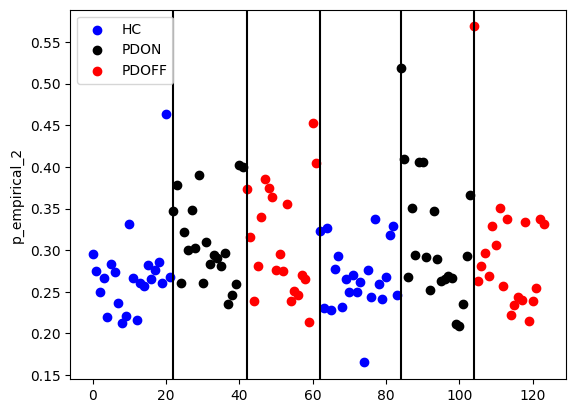

HC vs PDON: p=0.0178
HC vs PDOFF: p=0.0351
PDON vs PDOFF: p=0.9865
HC vs PD-COMB: p=0.4378
(GVS) HC vs PDON: p=0.0305
(GVS) HC vs PDOFF: p=0.1506
(GVS) PDON vs PDOFF: p=0.5443
(GVS) HC vs PD-COMB: p=0.0519
GVS- HC vs GVS+ HC: p=0.8104
GVS- PDON vs GVS+ PDON: p=0.9941
GVS- PDOFF GVS+ PDOFF: p=0.5068
GVS- vs GVS+: p=0.5973
###############################
Cross validation score for 3-class p_empirical_3: 0.1930 ±0.0451
Cross validation score for 2-class p_empirical_3: 0.6120 ±0.0560
HC mean: 0.2202 ± 0.0335
PDON mean: 0.1919 ± 0.0311
PDOFF mean: 0.1940 ± 0.0405
PD-COMB mean: 0.1976 ± 0.0407


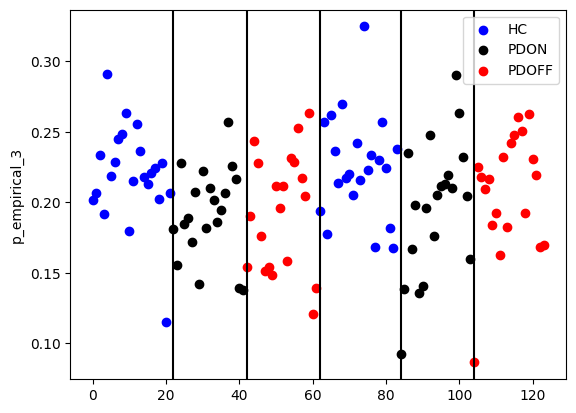

HC vs PDON: p=0.0088
HC vs PDOFF: p=0.0314
PDON vs PDOFF: p=0.8572
HC vs PD-COMB: p=0.2367
(GVS) HC vs PDON: p=0.0350
(GVS) HC vs PDOFF: p=0.1534
(GVS) PDON vs PDOFF: p=0.4500
(GVS) HC vs PD-COMB: p=0.0430
GVS- HC vs GVS+ HC: p=0.6282
GVS- PDON vs GVS+ PDON: p=0.7075
GVS- PDOFF GVS+ PDOFF: p=0.3093
GVS- vs GVS+: p=0.2865
###############################
Cross validation score for 3-class Transition Matrix[0,0]: 0.1937 ±0.0471
Cross validation score for 2-class Transition Matrix[0,0]: 0.6773 ±0.0259
HC mean: 0.7806 ± 0.0306
PDON mean: 0.7994 ± 0.0227
PDOFF mean: 0.7940 ± 0.0222
PD-COMB mean: 0.7967 ± 0.0262


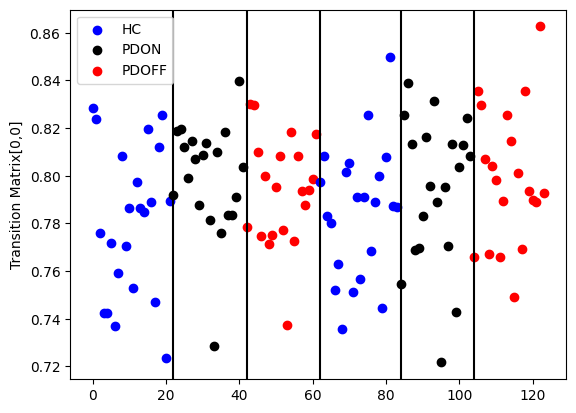

HC vs PDON: p=0.0346
HC vs PDOFF: p=0.1265
PDON vs PDOFF: p=0.4572
HC vs PD-COMB: p=0.4186
(GVS) HC vs PDON: p=0.3404
(GVS) HC vs PDOFF: p=0.1111
(GVS) PDON vs PDOFF: p=0.5736
(GVS) HC vs PD-COMB: p=0.1420
GVS- HC vs GVS+ HC: p=0.6093
GVS- PDON vs GVS+ PDON: p=0.5337
GVS- PDOFF GVS+ PDOFF: p=0.5149
GVS- vs GVS+: p=0.7532
###############################
Cross validation score for 3-class Transition Matrix[0,1]: 0.1927 ±0.0918
Cross validation score for 2-class Transition Matrix[0,1]: 0.7010 ±0.0681
HC mean: 0.0160 ± 0.0038
PDON mean: 0.0124 ± 0.0033
PDOFF mean: 0.0136 ± 0.0035
PD-COMB mean: 0.0131 ± 0.0036


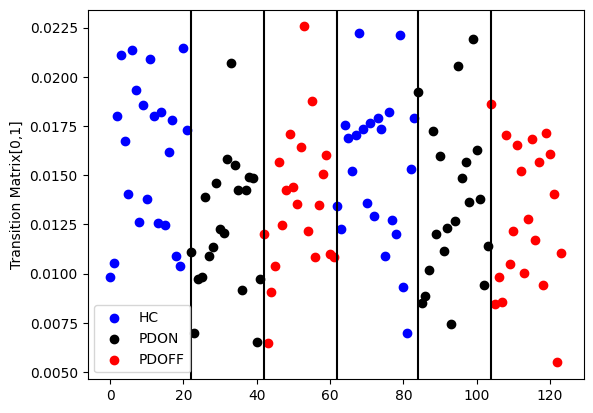

HC vs PDON: p=0.0028
HC vs PDOFF: p=0.0469
PDON vs PDOFF: p=0.2823
HC vs PD-COMB: p=0.1939
(GVS) HC vs PDON: p=0.1797
(GVS) HC vs PDOFF: p=0.0403
(GVS) PDON vs PDOFF: p=0.5198
(GVS) HC vs PD-COMB: p=0.0476
GVS- HC vs GVS+ HC: p=0.5486
GVS- PDON vs GVS+ PDON: p=0.3026
GVS- PDOFF GVS+ PDOFF: p=0.5084
GVS- vs GVS+: p=0.8875
###############################
Cross validation score for 3-class Transition Matrix[0,2]: 0.1447 ±0.0471
Cross validation score for 2-class Transition Matrix[0,2]: 0.6453 ±0.0107
HC mean: 0.1060 ± 0.0163
PDON mean: 0.0999 ± 0.0095
PDOFF mean: 0.1027 ± 0.0109
PD-COMB mean: 0.1015 ± 0.0119


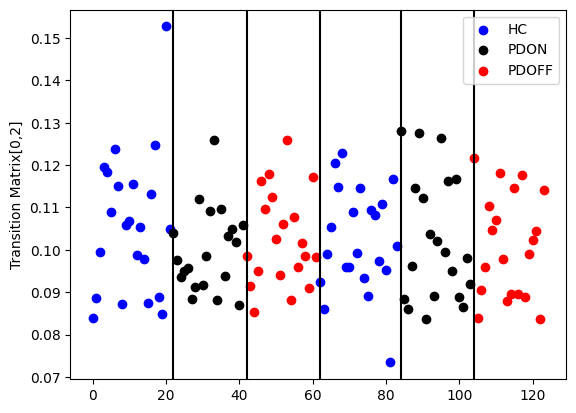

HC vs PDON: p=0.1577
HC vs PDOFF: p=0.4601
PDON vs PDOFF: p=0.3956
HC vs PD-COMB: p=0.5160
(GVS) HC vs PDON: p=0.9481
(GVS) HC vs PDOFF: p=0.7518
(GVS) PDON vs PDOFF: p=0.7337
(GVS) HC vs PD-COMB: p=0.8937
GVS- HC vs GVS+ HC: p=0.4028
GVS- PDON vs GVS+ PDON: p=0.5004
GVS- PDOFF GVS+ PDOFF: p=0.6642
GVS- vs GVS+: p=0.6781
###############################
Cross validation score for 3-class Transition Matrix[0,3]: 0.1770 ±0.0469
Cross validation score for 2-class Transition Matrix[0,3]: 0.7253 ±0.0662
HC mean: 0.0973 ± 0.0137
PDON mean: 0.0883 ± 0.0119
PDOFF mean: 0.0897 ± 0.0119
PD-COMB mean: 0.0886 ± 0.0137


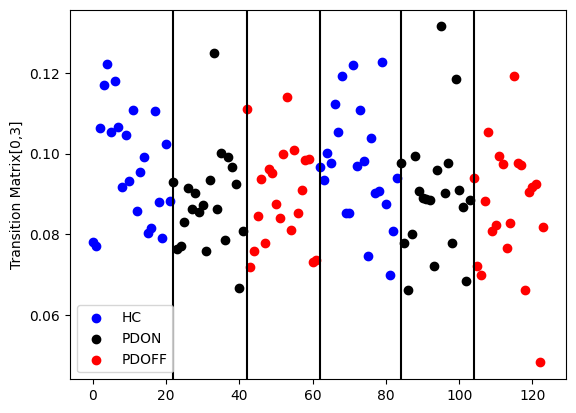

HC vs PDON: p=0.0314
HC vs PDOFF: p=0.0679
PDON vs PDOFF: p=0.7140
HC vs PD-COMB: p=0.5211
(GVS) HC vs PDON: p=0.1166
(GVS) HC vs PDOFF: p=0.0287
(GVS) PDON vs PDOFF: p=0.5298
(GVS) HC vs PD-COMB: p=0.0291
GVS- HC vs GVS+ HC: p=0.9690
GVS- PDON vs GVS+ PDON: p=0.7276
GVS- PDOFF GVS+ PDOFF: p=0.5035
GVS- vs GVS+: p=0.8392
###############################
Cross validation score for 3-class Transition Matrix[1,0]: 0.1857 ±0.0548
Cross validation score for 2-class Transition Matrix[1,0]: 0.6937 ±0.0471
HC mean: 0.0152 ± 0.0039
PDON mean: 0.0123 ± 0.0035
PDOFF mean: 0.0128 ± 0.0035
PD-COMB mean: 0.0126 ± 0.0035


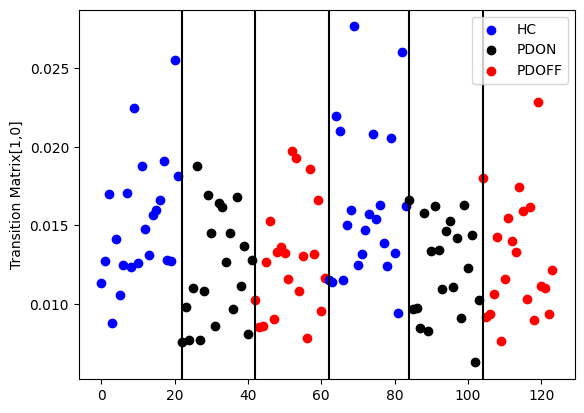

HC vs PDON: p=0.0155
HC vs PDOFF: p=0.0471
PDON vs PDOFF: p=0.6268
HC vs PD-COMB: p=0.2653
(GVS) HC vs PDON: p=0.0041
(GVS) HC vs PDOFF: p=0.0212
(GVS) PDON vs PDOFF: p=0.5802
(GVS) HC vs PD-COMB: p=0.0014
GVS- HC vs GVS+ HC: p=0.4685
GVS- PDON vs GVS+ PDON: p=0.9654
GVS- PDOFF GVS+ PDOFF: p=0.9264
GVS- vs GVS+: p=0.5923
###############################
Cross validation score for 3-class Transition Matrix[1,1]: 0.2267 ±0.0777
Cross validation score for 2-class Transition Matrix[1,1]: 0.6453 ±0.0275
HC mean: 0.7783 ± 0.0247
PDON mean: 0.7995 ± 0.0266
PDOFF mean: 0.7977 ± 0.0268
PD-COMB mean: 0.7992 ± 0.0262


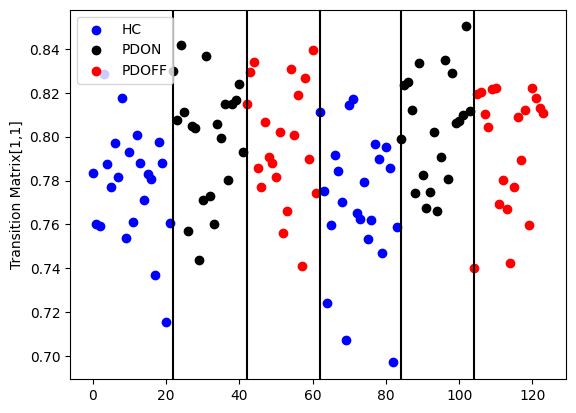

HC vs PDON: p=0.0124
HC vs PDOFF: p=0.0218
PDON vs PDOFF: p=0.8377
HC vs PD-COMB: p=0.3657
(GVS) HC vs PDON: p=0.0005
(GVS) HC vs PDOFF: p=0.0096
(GVS) PDON vs PDOFF: p=0.3056
(GVS) HC vs PD-COMB: p=0.0002
GVS- HC vs GVS+ HC: p=0.3671
GVS- PDON vs GVS+ PDON: p=0.5878
GVS- PDOFF GVS+ PDOFF: p=0.7945
GVS- vs GVS+: p=0.6951
###############################
Cross validation score for 3-class Transition Matrix[1,2]: 0.2427 ±0.0549
Cross validation score for 2-class Transition Matrix[1,2]: 0.6377 ±0.0396
HC mean: 0.1058 ± 0.0130
PDON mean: 0.0987 ± 0.0139
PDOFF mean: 0.0996 ± 0.0135
PD-COMB mean: 0.0981 ± 0.0149


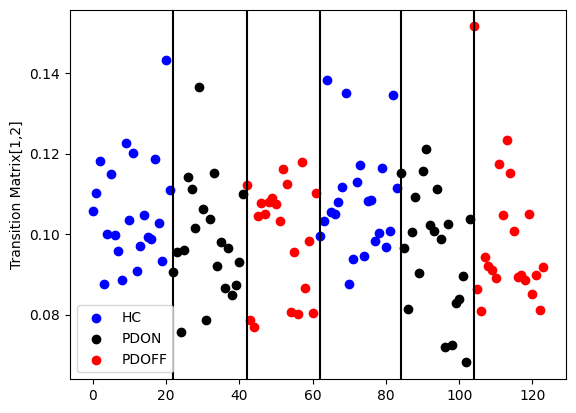

HC vs PDON: p=0.1041
HC vs PDOFF: p=0.1462
PDON vs PDOFF: p=0.8476
HC vs PD-COMB: p=0.6482
(GVS) HC vs PDON: p=0.0069
(GVS) HC vs PDOFF: p=0.0382
(GVS) PDON vs PDOFF: p=0.6317
(GVS) HC vs PD-COMB: p=0.0065
GVS- HC vs GVS+ HC: p=0.4901
GVS- PDON vs GVS+ PDON: p=0.5538
GVS- PDOFF GVS+ PDOFF: p=0.8153
GVS- vs GVS+: p=0.9164
###############################
Cross validation score for 3-class Transition Matrix[1,3]: 0.2497 ±0.0766
Cross validation score for 2-class Transition Matrix[1,3]: 0.6613 ±0.0537
HC mean: 0.1007 ± 0.0113
PDON mean: 0.0895 ± 0.0125
PDOFF mean: 0.0899 ± 0.0138
PD-COMB mean: 0.0901 ± 0.0128


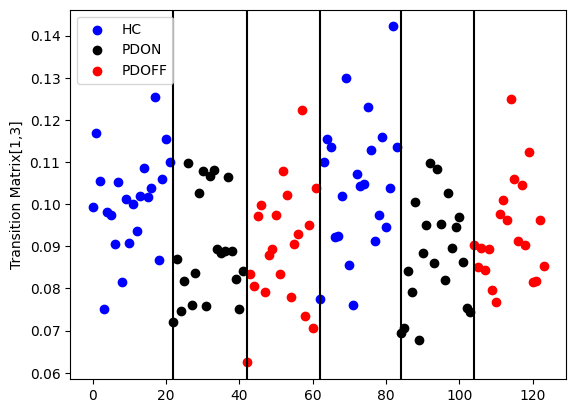

HC vs PDON: p=0.0050
HC vs PDOFF: p=0.0094
PDON vs PDOFF: p=0.9318
HC vs PD-COMB: p=0.2915
(GVS) HC vs PDON: p=0.0005
(GVS) HC vs PDOFF: p=0.0123
(GVS) PDON vs PDOFF: p=0.1727
(GVS) HC vs PD-COMB: p=0.0003
GVS- HC vs GVS+ HC: p=0.3367
GVS- PDON vs GVS+ PDON: p=0.6738
GVS- PDOFF GVS+ PDOFF: p=0.4262
GVS- vs GVS+: p=0.4498
###############################
Cross validation score for 3-class Transition Matrix[2,0]: 0.2253 ±0.0686
Cross validation score for 2-class Transition Matrix[2,0]: 0.7093 ±0.0549
HC mean: 0.0997 ± 0.0161
PDON mean: 0.0812 ± 0.0149
PDOFF mean: 0.0834 ± 0.0182
PD-COMB mean: 0.0823 ± 0.0191


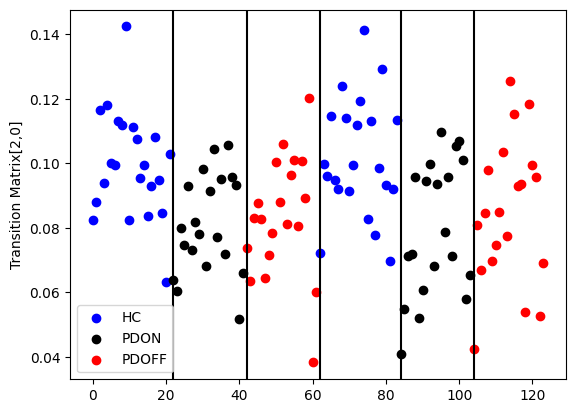

HC vs PDON: p=0.0006
HC vs PDOFF: p=0.0046
PDON vs PDOFF: p=0.6861
HC vs PD-COMB: p=0.2710
(GVS) HC vs PDON: p=0.0008
(GVS) HC vs PDOFF: p=0.0106
(GVS) PDON vs PDOFF: p=0.4522
(GVS) HC vs PD-COMB: p=0.0007
GVS- HC vs GVS+ HC: p=0.6794
GVS- PDON vs GVS+ PDON: p=0.8138
GVS- PDOFF GVS+ PDOFF: p=0.8037
GVS- vs GVS+: p=0.8167
###############################
Cross validation score for 3-class Transition Matrix[2,1]: 0.2170 ±0.0812
Cross validation score for 2-class Transition Matrix[2,1]: 0.6203 ±0.0776
HC mean: 0.1006 ± 0.0164
PDON mean: 0.0801 ± 0.0168
PDOFF mean: 0.0822 ± 0.0171
PD-COMB mean: 0.0837 ± 0.0197


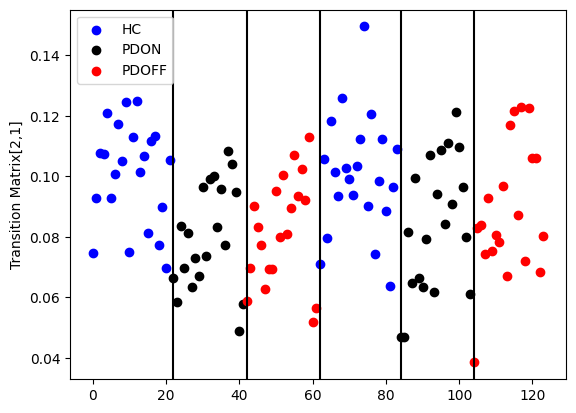

HC vs PDON: p=0.0004
HC vs PDOFF: p=0.0012
PDON vs PDOFF: p=0.7119
HC vs PD-COMB: p=0.1498
(GVS) HC vs PDON: p=0.0130
(GVS) HC vs PDOFF: p=0.0752
(GVS) PDON vs PDOFF: p=0.4814
(GVS) HC vs PD-COMB: p=0.0141
GVS- HC vs GVS+ HC: p=0.9771
GVS- PDON vs GVS+ PDON: p=0.5661
GVS- PDOFF GVS+ PDOFF: p=0.3034
GVS- vs GVS+: p=0.3858
###############################
Cross validation score for 3-class Transition Matrix[2,2]: 0.1930 ±0.0576
Cross validation score for 2-class Transition Matrix[2,2]: 0.7010 ±0.0580
HC mean: 0.7857 ± 0.0338
PDON mean: 0.8289 ± 0.0340
PDOFF mean: 0.8245 ± 0.0377
PD-COMB mean: 0.8238 ± 0.0411


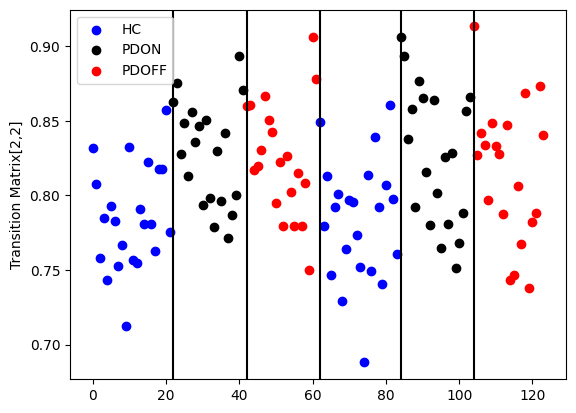

HC vs PDON: p=0.0002
HC vs PDOFF: p=0.0014
PDON vs PDOFF: p=0.7079
HC vs PD-COMB: p=0.1923
(GVS) HC vs PDON: p=0.0031
(GVS) HC vs PDOFF: p=0.0233
(GVS) PDON vs PDOFF: p=0.4814
(GVS) HC vs PD-COMB: p=0.0025
GVS- HC vs GVS+ HC: p=0.8682
GVS- PDON vs GVS+ PDON: p=0.8268
GVS- PDOFF GVS+ PDOFF: p=0.5162
GVS- vs GVS+: p=0.5752
###############################
Cross validation score for 3-class Transition Matrix[2,3]: 0.2253 ±0.0852
Cross validation score for 2-class Transition Matrix[2,3]: 0.7173 ±0.0529
HC mean: 0.0141 ± 0.0032
PDON mean: 0.0098 ± 0.0030
PDOFF mean: 0.0099 ± 0.0034
PD-COMB mean: 0.0102 ± 0.0038


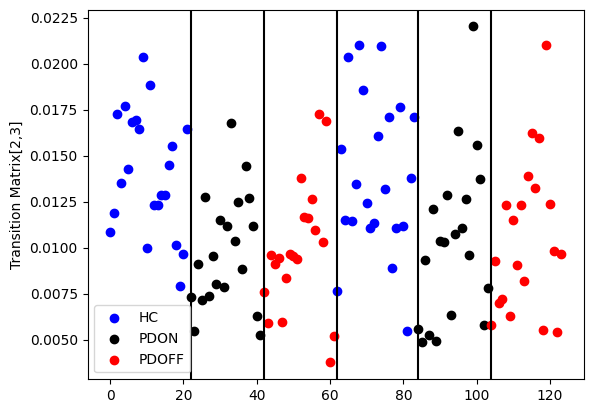

HC vs PDON: p=0.0001
HC vs PDOFF: p=0.0003
PDON vs PDOFF: p=0.8881
HC vs PD-COMB: p=0.2245
(GVS) HC vs PDON: p=0.0116
(GVS) HC vs PDOFF: p=0.0145
(GVS) PDON vs PDOFF: p=0.8612
(GVS) HC vs PD-COMB: p=0.0034
GVS- HC vs GVS+ HC: p=0.9121
GVS- PDON vs GVS+ PDON: p=0.6344
GVS- PDOFF GVS+ PDOFF: p=0.5819
GVS- vs GVS+: p=0.6347
###############################
Cross validation score for 3-class Transition Matrix[3,0]: 0.1530 ±0.0460
Cross validation score for 2-class Transition Matrix[3,0]: 0.6453 ±0.0107
HC mean: 0.1182 ± 0.0251
PDON mean: 0.1182 ± 0.0179
PDOFF mean: 0.1197 ± 0.0223
PD-COMB mean: 0.1168 ± 0.0197


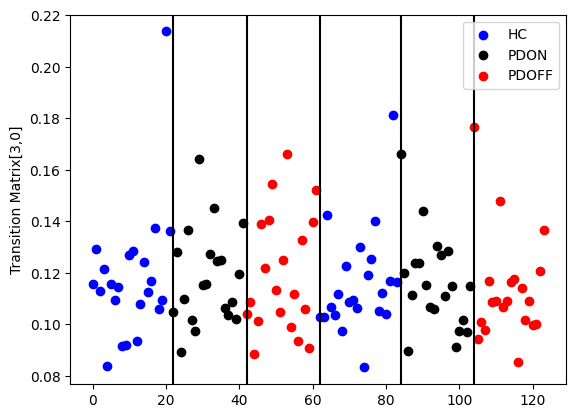

HC vs PDON: p=0.9992
HC vs PDOFF: p=0.8426
PDON vs PDOFF: p=0.8205
HC vs PD-COMB: p=0.7459
(GVS) HC vs PDON: p=0.9751
(GVS) HC vs PDOFF: p=0.7061
(GVS) PDON vs PDOFF: p=0.6798
(GVS) HC vs PD-COMB: p=0.8335
GVS- HC vs GVS+ HC: p=0.7384
GVS- PDON vs GVS+ PDON: p=0.7130
GVS- PDOFF GVS+ PDOFF: p=0.3721
GVS- vs GVS+: p=0.3488
###############################
Cross validation score for 3-class Transition Matrix[3,1]: 0.1857 ±0.0416
Cross validation score for 2-class Transition Matrix[3,1]: 0.6453 ±0.0107
HC mean: 0.1151 ± 0.0200
PDON mean: 0.1173 ± 0.0164
PDOFF mean: 0.1174 ± 0.0237
PD-COMB mean: 0.1145 ± 0.0241


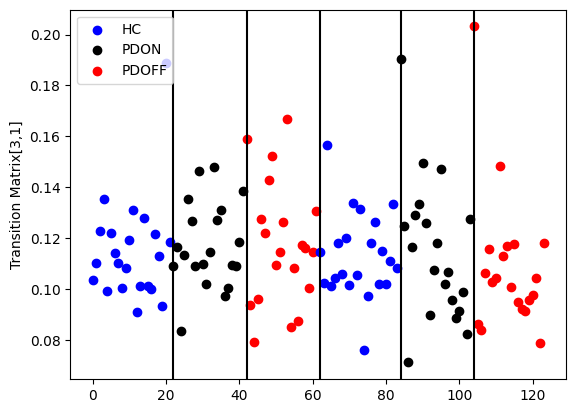

HC vs PDON: p=0.7160
HC vs PDOFF: p=0.7433
PDON vs PDOFF: p=0.9817
HC vs PD-COMB: p=0.5610
(GVS) HC vs PDON: p=0.7843
(GVS) HC vs PDOFF: p=0.5360
(GVS) PDON vs PDOFF: p=0.4781
(GVS) HC vs PD-COMB: p=0.8537
GVS- HC vs GVS+ HC: p=0.6858
GVS- PDON vs GVS+ PDON: p=0.7329
GVS- PDOFF GVS+ PDOFF: p=0.2837
GVS- vs GVS+: p=0.2645
###############################
Cross validation score for 3-class Transition Matrix[3,2]: 0.2180 ±0.0553
Cross validation score for 2-class Transition Matrix[3,2]: 0.6133 ±0.0368
HC mean: 0.0163 ± 0.0050
PDON mean: 0.0131 ± 0.0031
PDOFF mean: 0.0137 ± 0.0044
PD-COMB mean: 0.0135 ± 0.0040


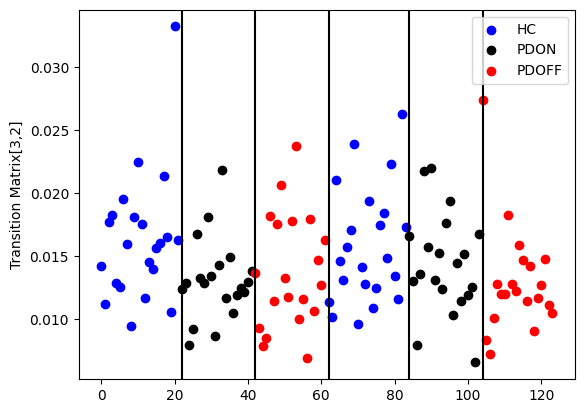

HC vs PDON: p=0.0187
HC vs PDOFF: p=0.0872
PDON vs PDOFF: p=0.6163
HC vs PD-COMB: p=0.3527
(GVS) HC vs PDON: p=0.2890
(GVS) HC vs PDOFF: p=0.0439
(GVS) PDON vs PDOFF: p=0.2855
(GVS) HC vs PD-COMB: p=0.0657
GVS- HC vs GVS+ HC: p=0.7165
GVS- PDON vs GVS+ PDON: p=0.2732
GVS- PDOFF GVS+ PDOFF: p=0.5827
GVS- vs GVS+: p=0.9729
###############################
Cross validation score for 3-class Transition Matrix[3,3]: 0.1700 ±0.0795
Cross validation score for 2-class Transition Matrix[3,3]: 0.6453 ±0.0107
HC mean: 0.7504 ± 0.0479
PDON mean: 0.7515 ± 0.0356
PDOFF mean: 0.7492 ± 0.0471
PD-COMB mean: 0.7551 ± 0.0452


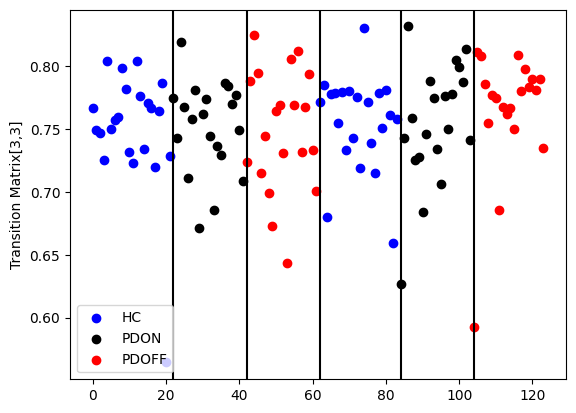

HC vs PDON: p=0.9344
HC vs PDOFF: p=0.9384
PDON vs PDOFF: p=0.8671
HC vs PD-COMB: p=0.7199
(GVS) HC vs PDON: p=0.9595
(GVS) HC vs PDOFF: p=0.4845
(GVS) PDON vs PDOFF: p=0.5123
(GVS) HC vs PD-COMB: p=0.7118
GVS- HC vs GVS+ HC: p=0.6972
GVS- PDON vs GVS+ PDON: p=0.8038
GVS- PDOFF GVS+ PDOFF: p=0.3126
GVS- vs GVS+: p=0.3169
###############################
Cross validation score for 3-class Empirical entropy: 0.1850 ±0.0300
Cross validation score for 2-class Empirical entropy: 0.6453 ±0.0107
HC mean: 1.3734 ± 0.0255
PDON mean: 1.3637 ± 0.0231
PDOFF mean: 1.3596 ± 0.0306
PD-COMB mean: 1.3600 ± 0.0397


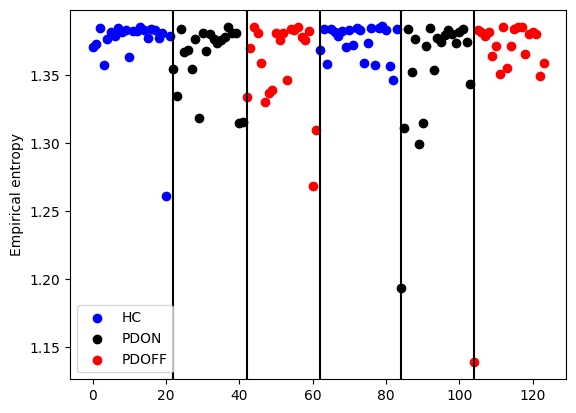

HC vs PDON: p=0.2154
HC vs PDOFF: p=0.1264
PDON vs PDOFF: p=0.6406
HC vs PD-COMB: p=0.9516
(GVS) HC vs PDON: p=0.0545
(GVS) HC vs PDOFF: p=0.2708
(GVS) PDON vs PDOFF: p=0.6594
(GVS) HC vs PD-COMB: p=0.1275
GVS- HC vs GVS+ HC: p=0.8023
GVS- PDON vs GVS+ PDON: p=0.4454
GVS- PDOFF GVS+ PDOFF: p=0.8735
GVS- vs GVS+: p=0.7967
###############################
Cross validation score for 3-class Empirical entropy rate: 0.2340 ±0.0307
Cross validation score for 2-class Empirical entropy rate: 0.6937 ±0.0306
HC mean: 0.6649 ± 0.0341
PDON mean: 0.6151 ± 0.0494
PDOFF mean: 0.6188 ± 0.0490
PD-COMB mean: 0.6154 ± 0.0513


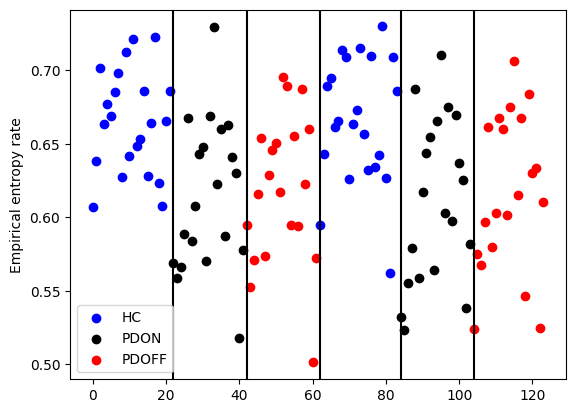

HC vs PDON: p=0.0006
HC vs PDOFF: p=0.0012
PDON vs PDOFF: p=0.8180
HC vs PD-COMB: p=0.3993
(GVS) HC vs PDON: p=0.0010
(GVS) HC vs PDOFF: p=0.0021
(GVS) PDON vs PDOFF: p=0.7504
(GVS) HC vs PD-COMB: p=0.0003
GVS- HC vs GVS+ HC: p=0.9679
GVS- PDON vs GVS+ PDON: p=0.8070
GVS- PDOFF GVS+ PDOFF: p=0.8880
GVS- vs GVS+: p=0.8411
###############################
Cross validation score for 3-class Theoretical MC entropy rate: 0.2420 ±0.0256
Cross validation score for 2-class Theoretical MC entropy rate: 0.6933 ±0.0223
HC mean: 0.7227 ± 0.0412
PDON mean: 0.6655 ± 0.0576
PDOFF mean: 0.6700 ± 0.0573
PD-COMB mean: 0.6655 ± 0.0596


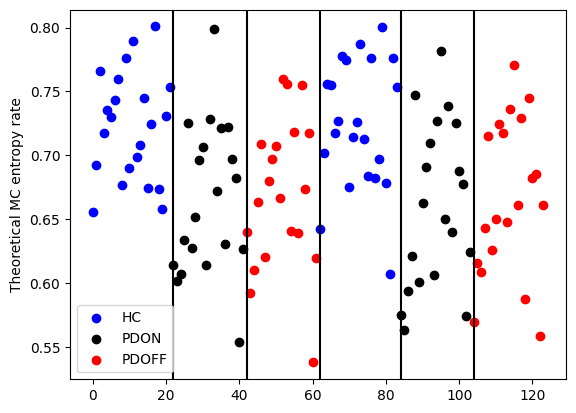

HC vs PDON: p=0.0008
HC vs PDOFF: p=0.0017
PDON vs PDOFF: p=0.8079
HC vs PD-COMB: p=0.4086
(GVS) HC vs PDON: p=0.0009
(GVS) HC vs PDOFF: p=0.0020
(GVS) PDON vs PDOFF: p=0.7300
(GVS) HC vs PD-COMB: p=0.0002
GVS- HC vs GVS+ HC: p=0.9442
GVS- PDON vs GVS+ PDON: p=0.7740
GVS- PDOFF GVS+ PDOFF: p=0.8624
GVS- vs GVS+: p=0.8193
###############################
Cross validation score for 3-class geoTest for Map0: 0.1453 ±0.0547
Cross validation score for 2-class geoTest for Map0: 0.6453 ±0.0107
HC mean: 0.1399 ± 0.2181
PDON mean: 0.2336 ± 0.2836
PDOFF mean: 0.2414 ± 0.2535
PD-COMB mean: 0.2051 ± 0.2529


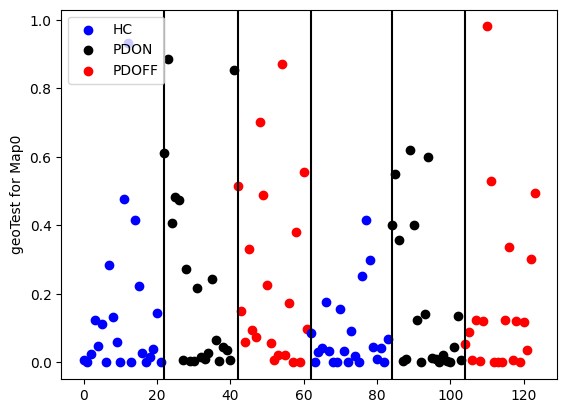

HC vs PDON: p=0.2462
HC vs PDOFF: p=0.1811
PDON vs PDOFF: p=0.9289
HC vs PD-COMB: p=0.3611
(GVS) HC vs PDON: p=0.1007
(GVS) HC vs PDOFF: p=0.1288
(GVS) PDON vs PDOFF: p=0.9978
(GVS) HC vs PD-COMB: p=0.0922
GVS- HC vs GVS+ HC: p=0.2815
GVS- PDON vs GVS+ PDON: p=0.4622
GVS- PDOFF GVS+ PDOFF: p=0.3989
GVS- vs GVS+: p=0.1372
###############################
Cross validation score for 3-class geoTest for Map1: 0.2010 ±0.0552
Cross validation score for 2-class geoTest for Map1: 0.6453 ±0.0107
HC mean: 0.1696 ± 0.1805
PDON mean: 0.1731 ± 0.1940
PDOFF mean: 0.2011 ± 0.2432
PD-COMB mean: 0.1911 ± 0.2185


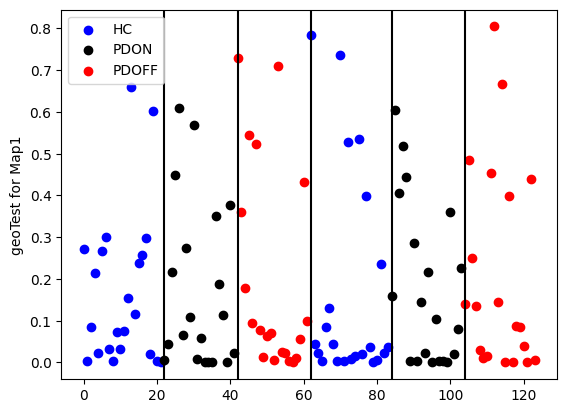

HC vs PDON: p=0.9533
HC vs PDOFF: p=0.6422
PDON vs PDOFF: p=0.6966
HC vs PD-COMB: p=0.8099
(GVS) HC vs PDON: p=0.8680
(GVS) HC vs PDOFF: p=0.5951
(GVS) PDON vs PDOFF: p=0.6754
(GVS) HC vs PD-COMB: p=0.6677
GVS- HC vs GVS+ HC: p=0.9868
GVS- PDON vs GVS+ PDON: p=0.9092
GVS- PDOFF GVS+ PDOFF: p=0.9124
GVS- vs GVS+: p=0.9053
###############################
Cross validation score for 3-class geoTest for Map2: 0.1290 ±0.0156
Cross validation score for 2-class geoTest for Map2: 0.6453 ±0.0107
HC mean: 0.1141 ± 0.1900
PDON mean: 0.0936 ± 0.1634
PDOFF mean: 0.0659 ± 0.1269
PD-COMB mean: 0.1098 ± 0.1822


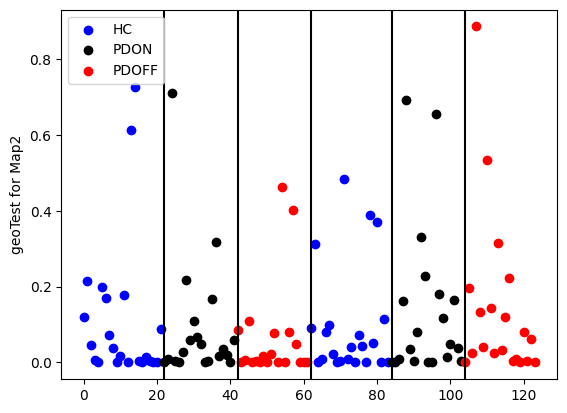

HC vs PDON: p=0.7171
HC vs PDOFF: p=0.3560
PDON vs PDOFF: p=0.5635
HC vs PD-COMB: p=0.7428
(GVS) HC vs PDON: p=0.4817
(GVS) HC vs PDOFF: p=0.4692
(GVS) PDON vs PDOFF: p=0.9636
(GVS) HC vs PD-COMB: p=0.4280
GVS- HC vs GVS+ HC: p=0.7804
GVS- PDON vs GVS+ PDON: p=0.4544
GVS- PDOFF GVS+ PDOFF: p=0.1954
GVS- vs GVS+: p=0.2955
###############################
Cross validation score for 3-class geoTest for Map3: 0.1610 ±0.0347
Cross validation score for 2-class geoTest for Map3: 0.6453 ±0.0107
HC mean: 0.1035 ± 0.1612
PDON mean: 0.1062 ± 0.1383
PDOFF mean: 0.0978 ± 0.1480
PD-COMB mean: 0.1254 ± 0.1660


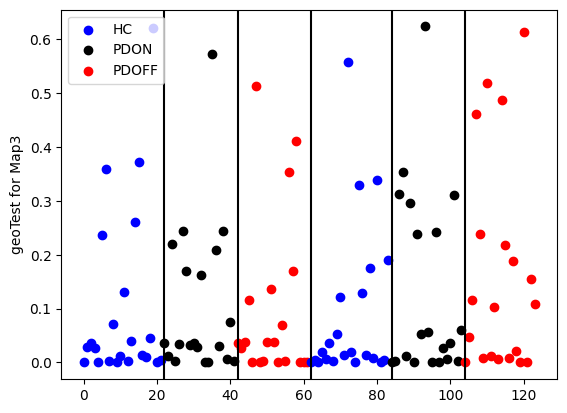

HC vs PDON: p=0.9541
HC vs PDOFF: p=0.9093
PDON vs PDOFF: p=0.8576
HC vs PD-COMB: p=0.7595
(GVS) HC vs PDON: p=0.4266
(GVS) HC vs PDOFF: p=0.1768
(GVS) PDON vs PDOFF: p=0.5702
(GVS) HC vs PD-COMB: p=0.2208
GVS- HC vs GVS+ HC: p=0.8091
GVS- PDON vs GVS+ PDON: p=0.6130
GVS- PDOFF GVS+ PDOFF: p=0.2323
GVS- vs GVS+: p=0.3736
###############################
Cross validation score for 3-class conditional homogeneity: 0.2173 ±0.0853
Cross validation score for 2-class conditional homogeneity: 0.6453 ±0.0107
HC mean: 0.0871 ± 0.1971
PDON mean: 0.1142 ± 0.2091
PDOFF mean: 0.1291 ± 0.2067
PD-COMB mean: 0.1522 ± 0.2325


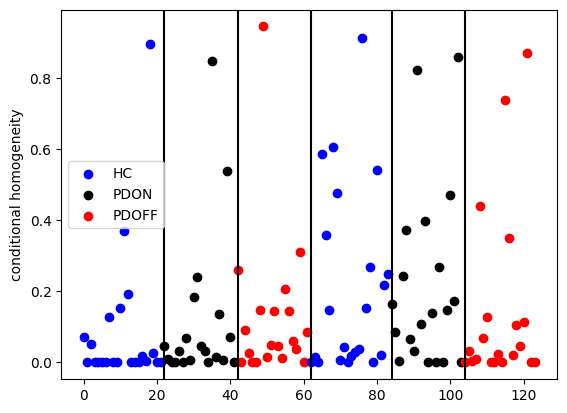

HC vs PDON: p=0.6759
HC vs PDOFF: p=0.5148
PDON vs PDOFF: p=0.8260
HC vs PD-COMB: p=0.3770
(GVS) HC vs PDON: p=0.9522
(GVS) HC vs PDOFF: p=0.4139
(GVS) PDON vs PDOFF: p=0.3873
(GVS) HC vs PD-COMB: p=0.6561
GVS- HC vs GVS+ HC: p=0.0797
GVS- PDON vs GVS+ PDON: p=0.1719
GVS- PDOFF GVS+ PDOFF: p=0.8051
GVS- vs GVS+: p=0.0454
###############################
Cross validation score for 3-class symmetry test: 0.2347 ±0.0678
Cross validation score for 2-class symmetry test: 0.6453 ±0.0107
HC mean: 0.2600 ± 0.3171
PDON mean: 0.5031 ± 0.3360
PDOFF mean: 0.4213 ± 0.3706
PD-COMB mean: 0.3888 ± 0.3626


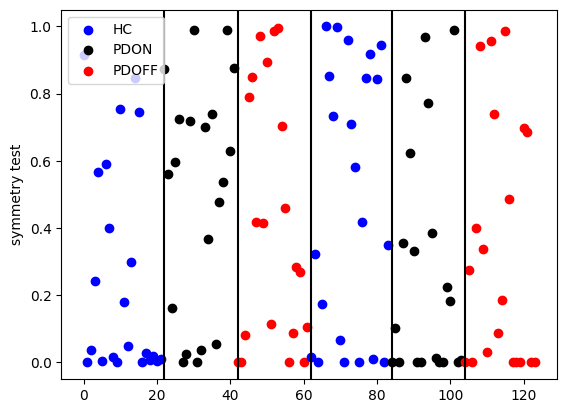

HC vs PDON: p=0.0236
HC vs PDOFF: p=0.1460
PDON vs PDOFF: p=0.4808
HC vs PD-COMB: p=0.3061
(GVS) HC vs PDON: p=0.0990
(GVS) HC vs PDOFF: p=0.2215
(GVS) PDON vs PDOFF: p=0.6633
(GVS) HC vs PD-COMB: p=0.0861
GVS- HC vs GVS+ HC: p=0.0437
GVS- PDON vs GVS+ PDON: p=0.0624
GVS- PDOFF GVS+ PDOFF: p=0.4995
GVS- vs GVS+: p=0.8384
###############################
Cross validation score for 3-class Maximum AIF value in 27-37: 0.2503 ±0.0900
Cross validation score for 2-class Maximum AIF value in 27-37: 0.6037 ±0.0727
HC mean: 0.0020 ± 0.0018
PDON mean: 0.0087 ± 0.0091
PDOFF mean: 0.0074 ± 0.0074
PD-COMB mean: 0.0082 ± 0.0083


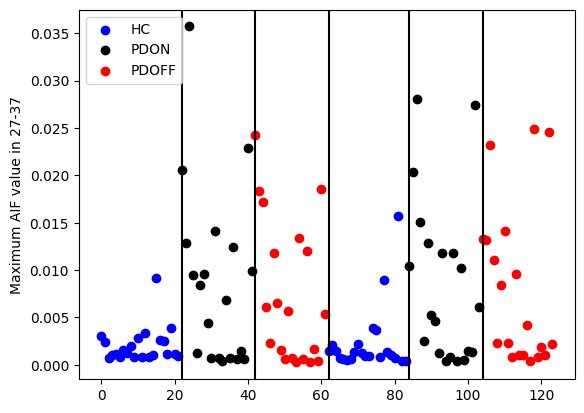

HC vs PDON: p=0.0022
HC vs PDOFF: p=0.0026
PDON vs PDOFF: p=0.6345
HC vs PD-COMB: p=0.3822
(GVS) HC vs PDON: p=0.0033
(GVS) HC vs PDOFF: p=0.0062
(GVS) PDON vs PDOFF: p=0.8191
(GVS) HC vs PD-COMB: p=0.0025
GVS- HC vs GVS+ HC: p=0.7297
GVS- PDON vs GVS+ PDON: p=0.9887
GVS- PDOFF GVS+ PDOFF: p=0.8075
GVS- vs GVS+: p=0.8291
###############################
Cross validation score for 3-class Location of Maximum AIF value after 15: 0.1693 ±0.0390
Cross validation score for 2-class Location of Maximum AIF value after 15: 0.6857 ±0.0277
HC mean: 15.4091 ± 21.4575
PDON mean: 9.0000 ± 6.6332
PDOFF mean: 10.7000 ± 8.4741
PD-COMB mean: 9.5000 ± 7.0658


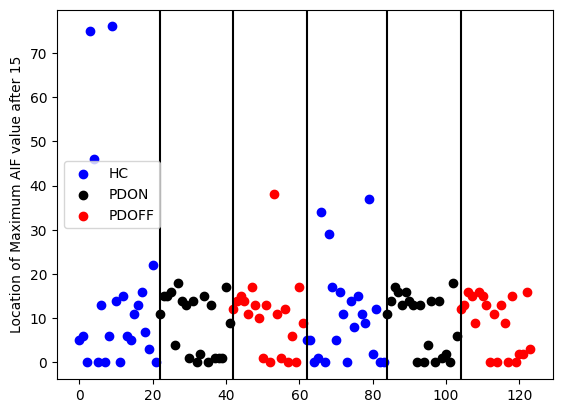

HC vs PDON: p=0.2184
HC vs PDOFF: p=0.3754
PDON vs PDOFF: p=0.4953
HC vs PD-COMB: p=0.7102
(GVS) HC vs PDON: p=0.6750
(GVS) HC vs PDOFF: p=0.5955
(GVS) PDON vs PDOFF: p=0.8859
(GVS) HC vs PD-COMB: p=0.5435
GVS- HC vs GVS+ HC: p=0.3535
GVS- PDON vs GVS+ PDON: p=0.8894
GVS- PDOFF GVS+ PDOFF: p=0.4852
GVS- vs GVS+: p=0.3042
###############################
Cross validation score for 3-class Number of Maxima in AIF between 0-50: 0.2100 ±0.0544
Cross validation score for 2-class Number of Maxima in AIF between 0-50: 0.5953 ±0.0995
HC mean: 5.5000 ± 1.6167
PDON mean: 3.7500 ± 1.9462
PDOFF mean: 4.1000 ± 2.0952
PD-COMB mean: 3.8875 ± 2.1272


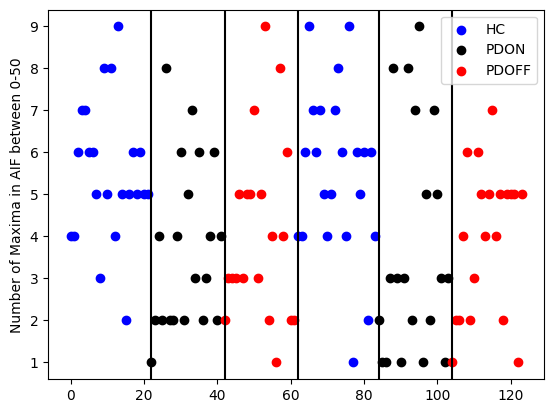

HC vs PDON: p=0.0035
HC vs PDOFF: p=0.0223
PDON vs PDOFF: p=0.5968
HC vs PD-COMB: p=0.3627
(GVS) HC vs PDON: p=0.0207
(GVS) HC vs PDOFF: p=0.0112
(GVS) PDON vs PDOFF: p=0.7825
(GVS) HC vs PD-COMB: p=0.0056
GVS- HC vs GVS+ HC: p=1.0000
GVS- PDON vs GVS+ PDON: p=1.0000
GVS- PDOFF GVS+ PDOFF: p=0.8106
GVS- vs GVS+: p=0.9016
###############################
Cross validation score for 3-class Number of Minima in AIF between 0-50: 0.2260 ±0.0789
Cross validation score for 2-class Number of Minima in AIF between 0-50: 0.6767 ±0.0615
HC mean: 5.9545 ± 1.7183
PDON mean: 4.1500 ± 1.8514
PDOFF mean: 4.8000 ± 1.9131
PD-COMB mean: 4.4500 ± 2.0670


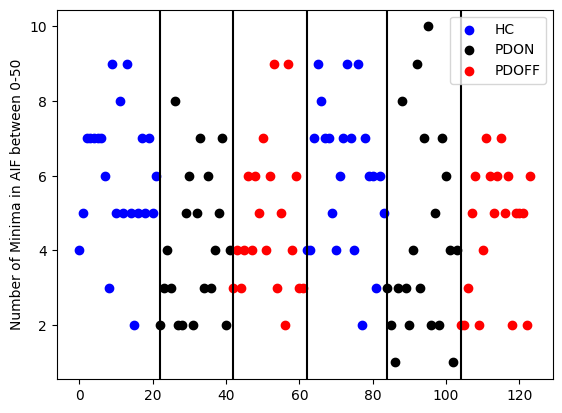

HC vs PDON: p=0.0027
HC vs PDOFF: p=0.0511
PDON vs PDOFF: p=0.2939
HC vs PD-COMB: p=0.2203
(GVS) HC vs PDON: p=0.0229
(GVS) HC vs PDOFF: p=0.0159
(GVS) PDON vs PDOFF: p=0.7291
(GVS) HC vs PD-COMB: p=0.0075
GVS- HC vs GVS+ HC: p=0.9357
GVS- PDON vs GVS+ PDON: p=0.8392
GVS- PDOFF GVS+ PDOFF: p=0.6740
GVS- vs GVS+: p=0.9664
###############################
Cross validation score for 3-class MeanAIFInBand - Alpha: 0.2100 ±0.0699
Cross validation score for 2-class MeanAIFInBand - Alpha: 0.6453 ±0.0107
HC mean: 0.0218 ± 0.0116
PDON mean: 0.0312 ± 0.0162
PDOFF mean: 0.0269 ± 0.0141
PD-COMB mean: 0.0294 ± 0.0179


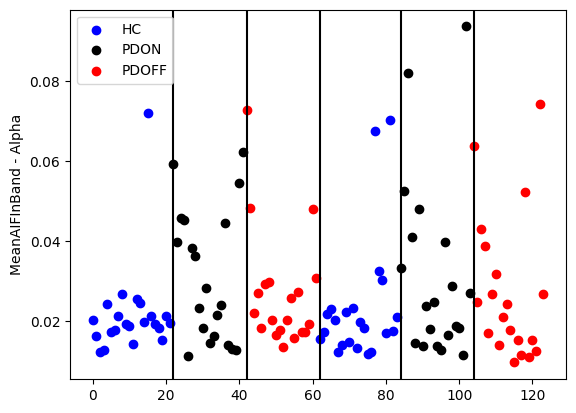

HC vs PDON: p=0.0397
HC vs PDOFF: p=0.2133
PDON vs PDOFF: p=0.3896
HC vs PD-COMB: p=0.4690
(GVS) HC vs PDON: p=0.1786
(GVS) HC vs PDOFF: p=0.4354
(GVS) PDON vs PDOFF: p=0.5372
(GVS) HC vs PD-COMB: p=0.2251
GVS- HC vs GVS+ HC: p=0.6819
GVS- PDON vs GVS+ PDON: p=0.9395
GVS- PDOFF GVS+ PDOFF: p=0.8917
GVS- vs GVS+: p=0.7437
###############################
Cross validation score for 3-class MeanAIFInBand - Beta: 0.2103 ±0.0503
Cross validation score for 2-class MeanAIFInBand - Beta: 0.6207 ±0.0243
HC mean: 0.0566 ± 0.0394
PDON mean: 0.1496 ± 0.1111
PDOFF mean: 0.1260 ± 0.0989
PD-COMB mean: 0.1382 ± 0.1077


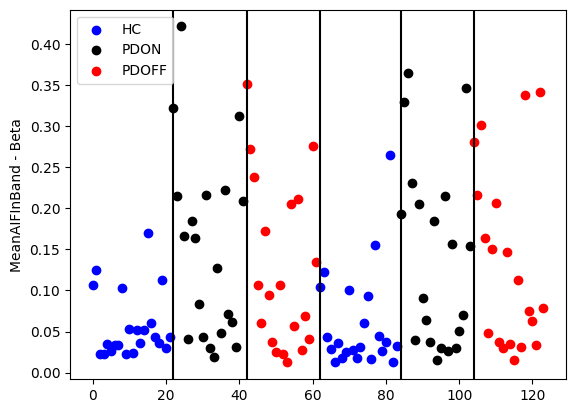

HC vs PDON: p=0.0009
HC vs PDOFF: p=0.0051
PDON vs PDOFF: p=0.4936
HC vs PD-COMB: p=0.2774
(GVS) HC vs PDON: p=0.0052
(GVS) HC vs PDOFF: p=0.0080
(GVS) PDON vs PDOFF: p=0.8565
(GVS) HC vs PD-COMB: p=0.0030
GVS- HC vs GVS+ HC: p=0.8519
GVS- PDON vs GVS+ PDON: p=0.8295
GVS- PDOFF GVS+ PDOFF: p=0.7828
GVS- vs GVS+: p=0.9328
###############################
Cross validation score for 3-class MeanAIFInBand - Gamma: 0.1210 ±0.0566
Cross validation score for 2-class MeanAIFInBand - Gamma: 0.6537 ±0.0273
HC mean: 0.0608 ± 0.0584
PDON mean: 0.0457 ± 0.0434
PDOFF mean: 0.0441 ± 0.0524
PD-COMB mean: 0.0445 ± 0.0464


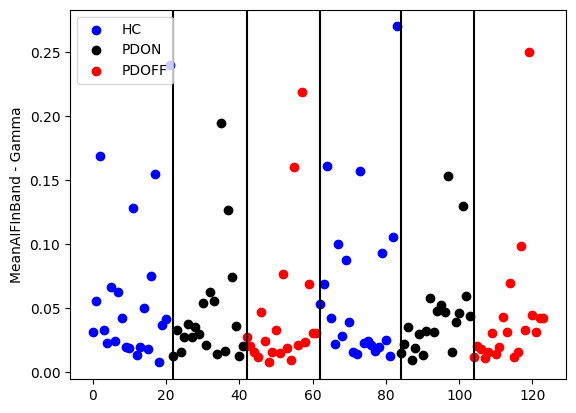

HC vs PDON: p=0.3612
HC vs PDOFF: p=0.3488
PDON vs PDOFF: p=0.9214
HC vs PD-COMB: p=0.8057
(GVS) HC vs PDON: p=0.2604
(GVS) HC vs PDOFF: p=0.2608
(GVS) PDON vs PDOFF: p=0.8768
(GVS) HC vs PD-COMB: p=0.1615
GVS- HC vs GVS+ HC: p=0.8675
GVS- PDON vs GVS+ PDON: p=0.9738
GVS- PDOFF GVS+ PDOFF: p=0.9473
GVS- vs GVS+: p=0.9486
###############################
Cross validation score for 3-class downsized-p_empirical_0: 0.1207 ±0.0350
Cross validation score for 2-class downsized-p_empirical_0: 0.6453 ±0.0107
HC mean: 0.2566 ± 0.0081
PDON mean: 0.2615 ± 0.0102
PDOFF mean: 0.2623 ± 0.0103
PD-COMB mean: 0.2615 ± 0.0117


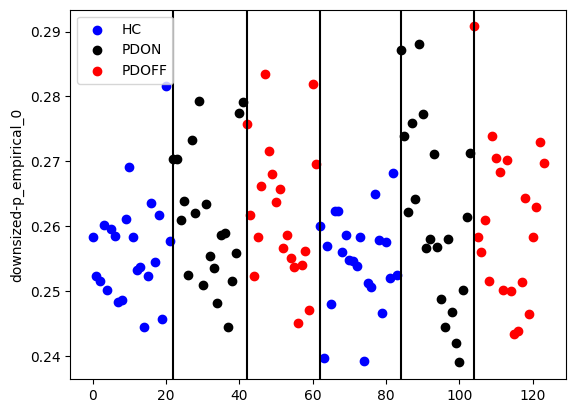

HC vs PDON: p=0.0973
HC vs PDOFF: p=0.0587
PDON vs PDOFF: p=0.8224
HC vs PD-COMB: p=0.6074
(GVS) HC vs PDON: p=0.0552
(GVS) HC vs PDOFF: p=0.0618
(GVS) PDON vs PDOFF: p=0.8165
(GVS) HC vs PD-COMB: p=0.0405
GVS- HC vs GVS+ HC: p=0.4671
GVS- PDON vs GVS+ PDON: p=0.9625
GVS- PDOFF GVS+ PDOFF: p=0.6697
GVS- vs GVS+: p=0.5926
###############################
Cross validation score for 3-class downsized-p_empirical_1: 0.1127 ±0.0292
Cross validation score for 2-class downsized-p_empirical_1: 0.6453 ±0.0107
HC mean: 0.2419 ± 0.0081
PDON mean: 0.2368 ± 0.0095
PDOFF mean: 0.2351 ± 0.0107
PD-COMB mean: 0.2366 ± 0.0116


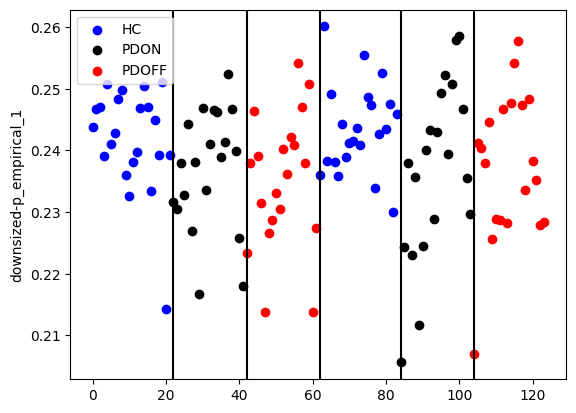

HC vs PDON: p=0.0758
HC vs PDOFF: p=0.0272
PDON vs PDOFF: p=0.5967
HC vs PD-COMB: p=0.6539
(GVS) HC vs PDON: p=0.0655
(GVS) HC vs PDOFF: p=0.0507
(GVS) PDON vs PDOFF: p=0.9042
(GVS) HC vs PD-COMB: p=0.0406
GVS- HC vs GVS+ HC: p=0.5214
GVS- PDON vs GVS+ PDON: p=0.9865
GVS- PDOFF GVS+ PDOFF: p=0.5243
GVS- vs GVS+: p=0.5028
###############################
Cross validation score for 3-class downsized-p_empirical_2: 0.1367 ±0.0308
Cross validation score for 2-class downsized-p_empirical_2: 0.6453 ±0.0107
HC mean: 0.2509 ± 0.0063
PDON mean: 0.2524 ± 0.0058
PDOFF mean: 0.2532 ± 0.0056
PD-COMB mean: 0.2515 ± 0.0063


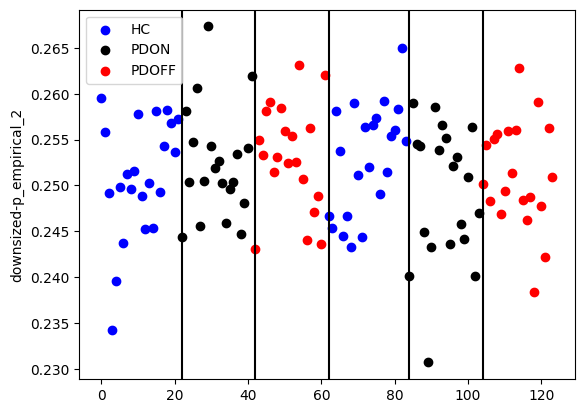

HC vs PDON: p=0.4265
HC vs PDOFF: p=0.2345
PDON vs PDOFF: p=0.6917
HC vs PD-COMB: p=0.6830
(GVS) HC vs PDON: p=0.0800
(GVS) HC vs PDOFF: p=0.3456
(GVS) PDON vs PDOFF: p=0.3536
(GVS) HC vs PD-COMB: p=0.1155
GVS- HC vs GVS+ HC: p=0.2806
GVS- PDON vs GVS+ PDON: p=0.1403
GVS- PDOFF GVS+ PDOFF: p=0.2865
GVS- vs GVS+: p=0.4002
###############################
Cross validation score for 3-class downsized-p_empirical_3: 0.0967 ±0.0317
Cross validation score for 2-class downsized-p_empirical_3: 0.6453 ±0.0107
HC mean: 0.2506 ± 0.0071
PDON mean: 0.2492 ± 0.0058
PDOFF mean: 0.2495 ± 0.0060
PD-COMB mean: 0.2504 ± 0.0064


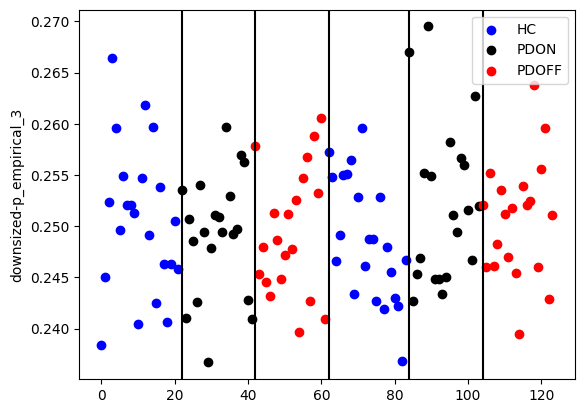

HC vs PDON: p=0.5012
HC vs PDOFF: p=0.5869
PDON vs PDOFF: p=0.8960
HC vs PD-COMB: p=0.5933
(GVS) HC vs PDON: p=0.1182
(GVS) HC vs PDOFF: p=0.3001
(GVS) PDON vs PDOFF: p=0.4895
(GVS) HC vs PD-COMB: p=0.1305
GVS- HC vs GVS+ HC: p=0.3652
GVS- PDON vs GVS+ PDON: p=0.1830
GVS- PDOFF GVS+ PDOFF: p=0.5236
GVS- vs GVS+: p=0.5518
###############################
Cross validation score for 3-class downsized-Transition Matrix[0,1]: 0.2337 ±0.0769
Cross validation score for 2-class downsized-Transition Matrix[0,1]: 0.6933 ±0.0422
HC mean: 0.0642 ± 0.0078
PDON mean: 0.0560 ± 0.0076
PDOFF mean: 0.0540 ± 0.0094
PD-COMB mean: 0.0558 ± 0.0101


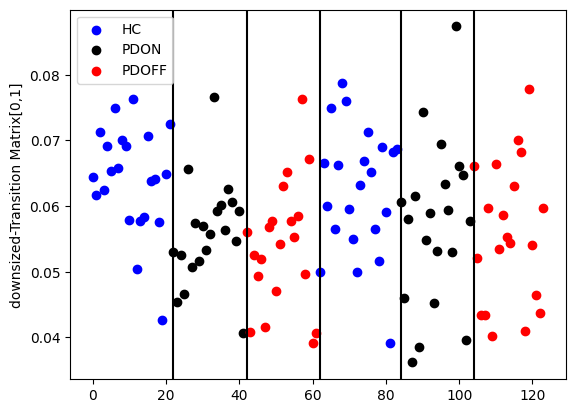

HC vs PDON: p=0.0017
HC vs PDOFF: p=0.0006
PDON vs PDOFF: p=0.4888
HC vs PD-COMB: p=0.6066
(GVS) HC vs PDON: p=0.1557
(GVS) HC vs PDOFF: p=0.0445
(GVS) PDON vs PDOFF: p=0.6737
(GVS) HC vs PD-COMB: p=0.0517
GVS- HC vs GVS+ HC: p=0.5124
GVS- PDON vs GVS+ PDON: p=0.6635
GVS- PDOFF GVS+ PDOFF: p=0.5768
GVS- vs GVS+: p=0.8209
###############################
Cross validation score for 3-class downsized-Transition Matrix[0,2]: 0.1857 ±0.0212
Cross validation score for 2-class downsized-Transition Matrix[0,2]: 0.6453 ±0.0107
HC mean: 0.4660 ± 0.0209
PDON mean: 0.4766 ± 0.0206
PDOFF mean: 0.4762 ± 0.0242
PD-COMB mean: 0.4685 ± 0.0284


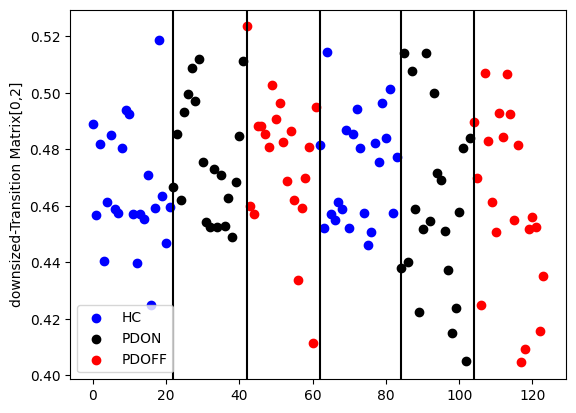

HC vs PDON: p=0.1134
HC vs PDOFF: p=0.1612
PDON vs PDOFF: p=0.9513
HC vs PD-COMB: p=0.2628
(GVS) HC vs PDON: p=0.1132
(GVS) HC vs PDOFF: p=0.1451
(GVS) PDON vs PDOFF: p=0.8882
(GVS) HC vs PD-COMB: p=0.0963
GVS- HC vs GVS+ HC: p=0.2522
GVS- PDON vs GVS+ PDON: p=0.0616
GVS- PDOFF GVS+ PDOFF: p=0.1047
GVS- vs GVS+: p=0.0981
###############################
Cross validation score for 3-class downsized-Transition Matrix[0,3]: 0.1610 ±0.0347
Cross validation score for 2-class downsized-Transition Matrix[0,3]: 0.6453 ±0.0107
HC mean: 0.4699 ± 0.0228
PDON mean: 0.4674 ± 0.0193
PDOFF mean: 0.4698 ± 0.0267
PD-COMB mean: 0.4757 ± 0.0292


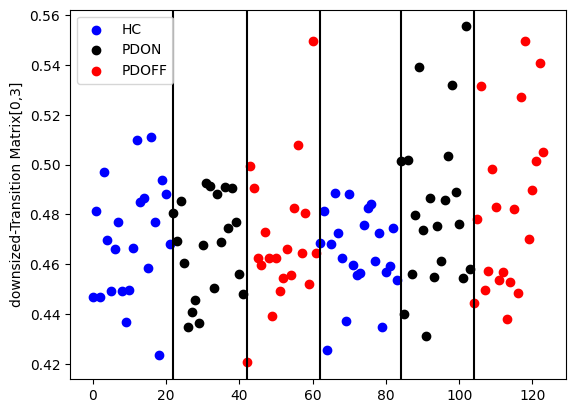

HC vs PDON: p=0.7173
HC vs PDOFF: p=0.9937
PDON vs PDOFF: p=0.7543
HC vs PD-COMB: p=0.3651
(GVS) HC vs PDON: p=0.0263
(GVS) HC vs PDOFF: p=0.0313
(GVS) PDON vs PDOFF: p=0.9905
(GVS) HC vs PD-COMB: p=0.0184
GVS- HC vs GVS+ HC: p=0.3891
GVS- PDON vs GVS+ PDON: p=0.0799
GVS- PDOFF GVS+ PDOFF: p=0.1906
GVS- vs GVS+: p=0.1311
###############################
Cross validation score for 3-class downsized-Transition Matrix[1,0]: 0.2577 ±0.0730
Cross validation score for 2-class downsized-Transition Matrix[1,0]: 0.6620 ±0.0717
HC mean: 0.0636 ± 0.0102
PDON mean: 0.0519 ± 0.0074
PDOFF mean: 0.0528 ± 0.0095
PD-COMB mean: 0.0541 ± 0.0095


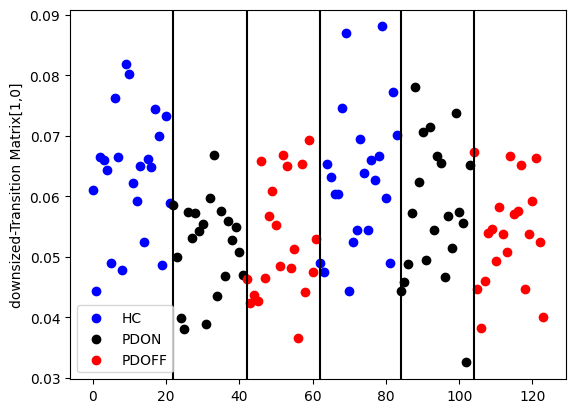

HC vs PDON: p=0.0002
HC vs PDOFF: p=0.0013
PDON vs PDOFF: p=0.7554
HC vs PD-COMB: p=0.1050
(GVS) HC vs PDON: p=0.1509
(GVS) HC vs PDOFF: p=0.0079
(GVS) PDON vs PDOFF: p=0.2566
(GVS) HC vs PD-COMB: p=0.0156
GVS- HC vs GVS+ HC: p=0.8589
GVS- PDON vs GVS+ PDON: p=0.0693
GVS- PDOFF GVS+ PDOFF: p=0.6812
GVS- vs GVS+: p=0.3033
###############################
Cross validation score for 3-class downsized-Transition Matrix[1,2]: 0.1373 ±0.0331
Cross validation score for 2-class downsized-Transition Matrix[1,2]: 0.6533 ±0.0169
HC mean: 0.4729 ± 0.0258
PDON mean: 0.4761 ± 0.0199
PDOFF mean: 0.4800 ± 0.0319
PD-COMB mean: 0.4801 ± 0.0286


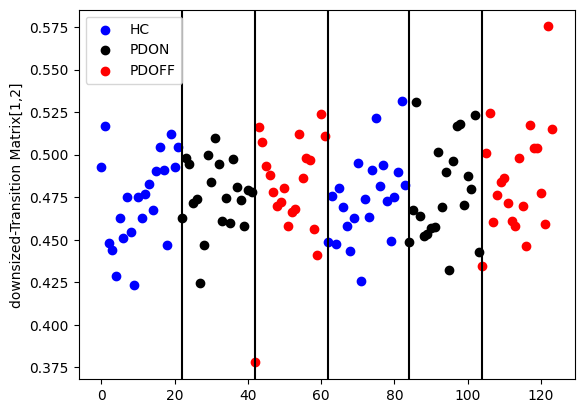

HC vs PDON: p=0.6649
HC vs PDOFF: p=0.4451
PDON vs PDOFF: p=0.6587
HC vs PD-COMB: p=0.6881
(GVS) HC vs PDON: p=0.6467
(GVS) HC vs PDOFF: p=0.1824
(GVS) PDON vs PDOFF: p=0.4046
(GVS) HC vs PD-COMB: p=0.3026
GVS- HC vs GVS+ HC: p=0.8764
GVS- PDON vs GVS+ PDON: p=0.8185
GVS- PDOFF GVS+ PDOFF: p=0.5526
GVS- vs GVS+: p=0.5466
###############################
Cross validation score for 3-class downsized-Transition Matrix[1,3]: 0.1860 ±0.0714
Cross validation score for 2-class downsized-Transition Matrix[1,3]: 0.6453 ±0.0107
HC mean: 0.4635 ± 0.0240
PDON mean: 0.4719 ± 0.0183
PDOFF mean: 0.4672 ± 0.0313
PD-COMB mean: 0.4658 ± 0.0270


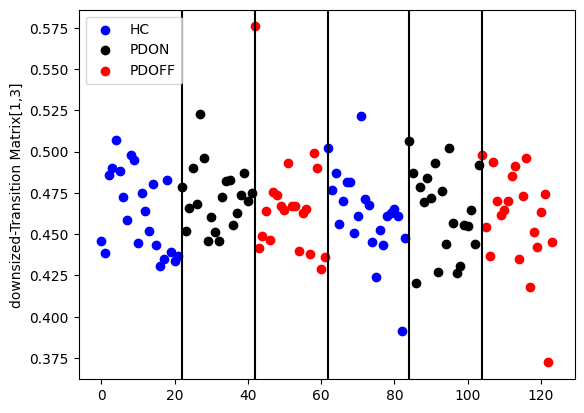

HC vs PDON: p=0.2208
HC vs PDOFF: p=0.6724
PDON vs PDOFF: p=0.5750
HC vs PD-COMB: p=0.2877
(GVS) HC vs PDON: p=0.8587
(GVS) HC vs PDOFF: p=0.7309
(GVS) PDON vs PDOFF: p=0.6202
(GVS) HC vs PD-COMB: p=0.9148
GVS- HC vs GVS+ HC: p=0.9373
GVS- PDON vs GVS+ PDON: p=0.2996
GVS- PDOFF GVS+ PDOFF: p=0.4599
GVS- vs GVS+: p=0.2895
###############################
Cross validation score for 3-class downsized-Transition Matrix[2,0]: 0.2010 ±0.0830
Cross validation score for 2-class downsized-Transition Matrix[2,0]: 0.6127 ±0.0231
HC mean: 0.4839 ± 0.0249
PDON mean: 0.4997 ± 0.0256
PDOFF mean: 0.4997 ± 0.0327
PD-COMB mean: 0.5016 ± 0.0317


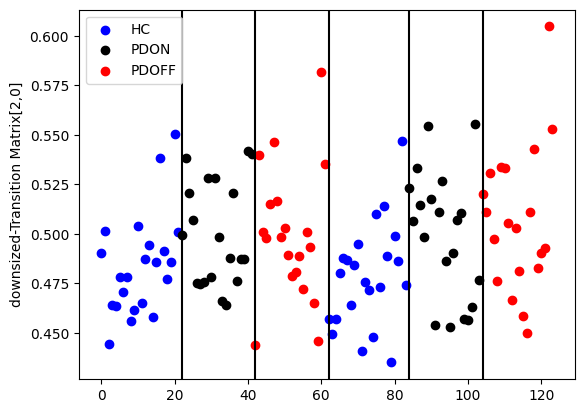

HC vs PDON: p=0.0554
HC vs PDOFF: p=0.0929
PDON vs PDOFF: p=0.9981
HC vs PD-COMB: p=0.6833
(GVS) HC vs PDON: p=0.0222
(GVS) HC vs PDOFF: p=0.0049
(GVS) PDON vs PDOFF: p=0.4919
(GVS) HC vs PD-COMB: p=0.0038
GVS- HC vs GVS+ HC: p=0.4756
GVS- PDON vs GVS+ PDON: p=0.9973
GVS- PDOFF GVS+ PDOFF: p=0.4975
GVS- vs GVS+: p=0.9334
###############################
Cross validation score for 3-class downsized-Transition Matrix[2,1]: 0.1613 ±0.0670
Cross validation score for 2-class downsized-Transition Matrix[2,1]: 0.6053 ±0.0662
HC mean: 0.4446 ± 0.0258
PDON mean: 0.4395 ± 0.0188
PDOFF mean: 0.4352 ± 0.0293
PD-COMB mean: 0.4353 ± 0.0268


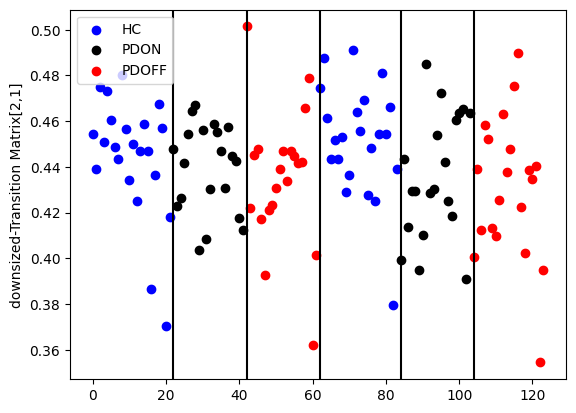

HC vs PDON: p=0.4839
HC vs PDOFF: p=0.2901
PDON vs PDOFF: p=0.5974
HC vs PD-COMB: p=0.9204
(GVS) HC vs PDON: p=0.0556
(GVS) HC vs PDOFF: p=0.0190
(GVS) PDON vs PDOFF: p=0.5685
(GVS) HC vs PD-COMB: p=0.0145
GVS- HC vs GVS+ HC: p=0.3626
GVS- PDON vs GVS+ PDON: p=0.6373
GVS- PDOFF GVS+ PDOFF: p=0.6375
GVS- vs GVS+: p=0.9816
###############################
Cross validation score for 3-class downsized-Transition Matrix[2,3]: 0.1860 ±0.0504
Cross validation score for 2-class downsized-Transition Matrix[2,3]: 0.7100 ±0.0369
HC mean: 0.0715 ± 0.0109
PDON mean: 0.0608 ± 0.0113
PDOFF mean: 0.0651 ± 0.0111
PD-COMB mean: 0.0631 ± 0.0111


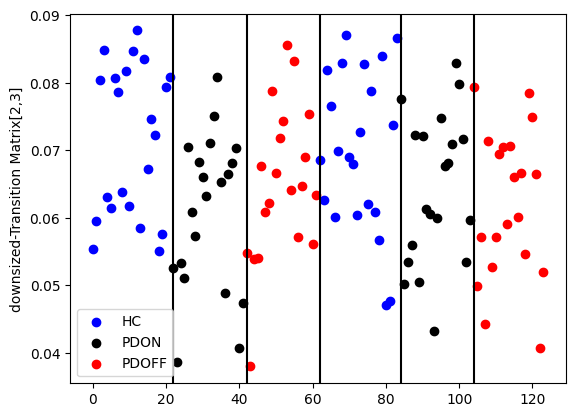

HC vs PDON: p=0.0041
HC vs PDOFF: p=0.0730
PDON vs PDOFF: p=0.2456
HC vs PD-COMB: p=0.1877
(GVS) HC vs PDON: p=0.1165
(GVS) HC vs PDOFF: p=0.0310
(GVS) PDON vs PDOFF: p=0.5266
(GVS) HC vs PD-COMB: p=0.0265
GVS- HC vs GVS+ HC: p=0.6729
GVS- PDON vs GVS+ PDON: p=0.3329
GVS- PDOFF GVS+ PDOFF: p=0.4022
GVS- vs GVS+: p=0.8660
###############################
Cross validation score for 3-class downsized-Transition Matrix[3,0]: 0.1370 ±0.0316
Cross validation score for 2-class downsized-Transition Matrix[3,0]: 0.6453 ±0.0107
HC mean: 0.4779 ± 0.0233
PDON mean: 0.4935 ± 0.0315
PDOFF mean: 0.4939 ± 0.0351
PD-COMB mean: 0.4894 ± 0.0372


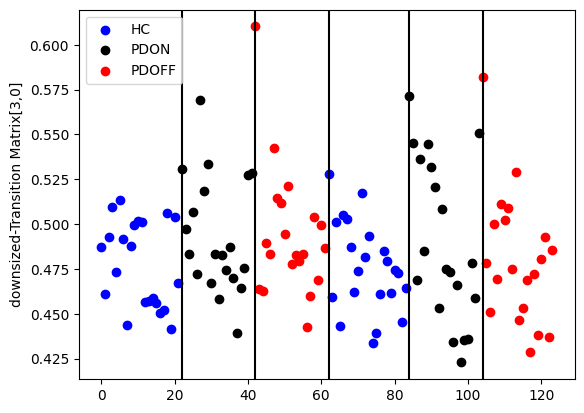

HC vs PDON: p=0.0809
HC vs PDOFF: p=0.0932
PDON vs PDOFF: p=0.9640
HC vs PD-COMB: p=0.4184
(GVS) HC vs PDON: p=0.2232
(GVS) HC vs PDOFF: p=0.6342
(GVS) PDON vs PDOFF: p=0.4799
(GVS) HC vs PD-COMB: p=0.3403
GVS- HC vs GVS+ HC: p=0.7946
GVS- PDON vs GVS+ PDON: p=0.7678
GVS- PDOFF GVS+ PDOFF: p=0.2465
GVS- vs GVS+: p=0.3076
###############################
Cross validation score for 3-class downsized-Transition Matrix[3,1]: 0.1287 ±0.0460
Cross validation score for 2-class downsized-Transition Matrix[3,1]: 0.6453 ±0.0107
HC mean: 0.4548 ± 0.0249
PDON mean: 0.4467 ± 0.0264
PDOFF mean: 0.4444 ± 0.0355
PD-COMB mean: 0.4495 ± 0.0364


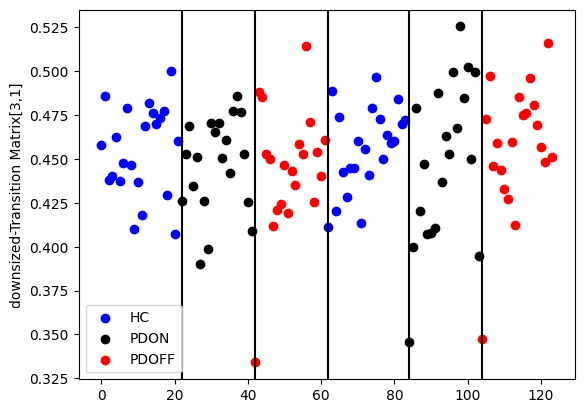

HC vs PDON: p=0.3264
HC vs PDOFF: p=0.2868
PDON vs PDOFF: p=0.8200
HC vs PD-COMB: p=0.6076
(GVS) HC vs PDON: p=0.5390
(GVS) HC vs PDOFF: p=0.8619
(GVS) PDON vs PDOFF: p=0.5183
(GVS) HC vs PD-COMB: p=0.7842
GVS- HC vs GVS+ HC: p=0.8658
GVS- PDON vs GVS+ PDON: p=0.8386
GVS- PDOFF GVS+ PDOFF: p=0.2544
GVS- vs GVS+: p=0.3509
###############################
Cross validation score for 3-class downsized-Transition Matrix[3,2]: 0.1700 ±0.0613
Cross validation score for 2-class downsized-Transition Matrix[3,2]: 0.6613 ±0.0181
HC mean: 0.0674 ± 0.0111
PDON mean: 0.0598 ± 0.0107
PDOFF mean: 0.0617 ± 0.0103
PD-COMB mean: 0.0611 ± 0.0108


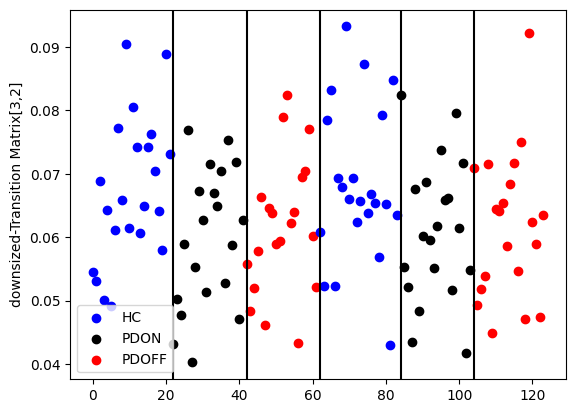

HC vs PDON: p=0.0353
HC vs PDOFF: p=0.1025
PDON vs PDOFF: p=0.5939
HC vs PD-COMB: p=0.3236
(GVS) HC vs PDON: p=0.0620
(GVS) HC vs PDOFF: p=0.0990
(GVS) PDON vs PDOFF: p=0.8402
(GVS) HC vs PD-COMB: p=0.0361
GVS- HC vs GVS+ HC: p=0.8500
GVS- PDON vs GVS+ PDON: p=0.7207
GVS- PDOFF GVS+ PDOFF: p=0.9663
GVS- vs GVS+: p=0.7397
###############################
Cross validation score for 3-class downsized-Empirical entropy: 0.2340 ±0.0692
Cross validation score for 2-class downsized-Empirical entropy: 0.6453 ±0.0107
HC mean: 1.3856 ± 0.0010
PDON mean: 1.3851 ± 0.0014
PDOFF mean: 1.3849 ± 0.0014
PD-COMB mean: 1.3850 ± 0.0017


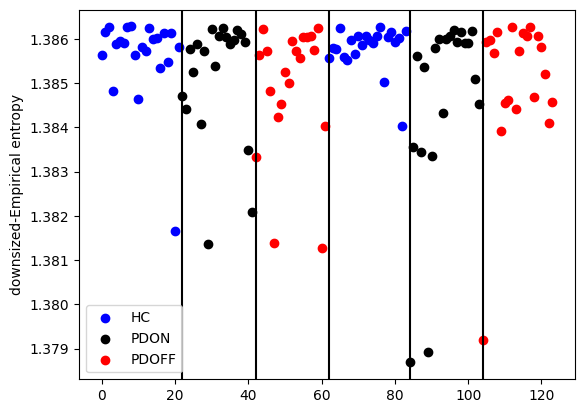

HC vs PDON: p=0.1981
HC vs PDOFF: p=0.0814
PDON vs PDOFF: p=0.6650
HC vs PD-COMB: p=0.9858
(GVS) HC vs PDON: p=0.0219
(GVS) HC vs PDOFF: p=0.0443
(GVS) PDON vs PDOFF: p=0.5027
(GVS) HC vs PD-COMB: p=0.0267
GVS- HC vs GVS+ HC: p=0.4542
GVS- PDON vs GVS+ PDON: p=0.4088
GVS- PDOFF GVS+ PDOFF: p=0.8034
GVS- vs GVS+: p=0.8338
###############################
Cross validation score for 3-class downsized-Empirical entropy rate: 0.2180 ±0.0705
Cross validation score for 2-class downsized-Empirical entropy rate: 0.6850 ±0.0615
HC mean: 0.7118 ± 0.0301
PDON mean: 0.6838 ± 0.0257
PDOFF mean: 0.6855 ± 0.0279
PD-COMB mean: 0.6881 ± 0.0268


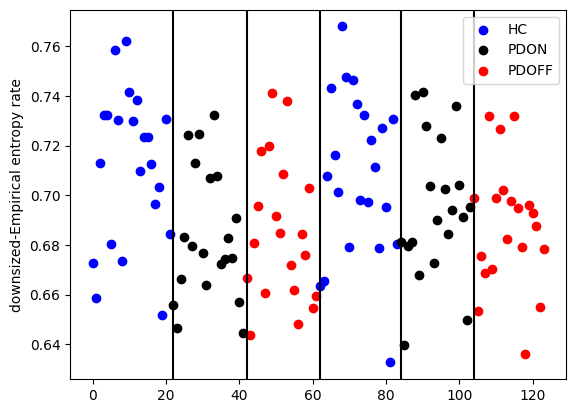

HC vs PDON: p=0.0031
HC vs PDOFF: p=0.0067
PDON vs PDOFF: p=0.8517
HC vs PD-COMB: p=0.2243
(GVS) HC vs PDON: p=0.1820
(GVS) HC vs PDOFF: p=0.0314
(GVS) PDON vs PDOFF: p=0.3841
(GVS) HC vs PD-COMB: p=0.0348
GVS- HC vs GVS+ HC: p=0.7139
GVS- PDON vs GVS+ PDON: p=0.1898
GVS- PDOFF GVS+ PDOFF: p=0.7769
GVS- vs GVS+: p=0.5558
###############################
Cross validation score for 3-class downsized-Theoretical MC entropy rate: 0.2337 ±0.0380
Cross validation score for 2-class downsized-Theoretical MC entropy rate: 0.7103 ±0.0435
HC mean: 0.8893 ± 0.0139
PDON mean: 0.8698 ± 0.0164
PDOFF mean: 0.8711 ± 0.0199
PD-COMB mean: 0.8715 ± 0.0193


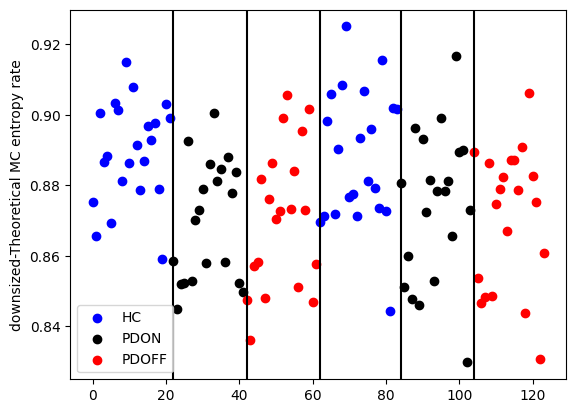

HC vs PDON: p=0.0002
HC vs PDOFF: p=0.0016
PDON vs PDOFF: p=0.8223
HC vs PD-COMB: p=0.2817
(GVS) HC vs PDON: p=0.0342
(GVS) HC vs PDOFF: p=0.0077
(GVS) PDON vs PDOFF: p=0.6260
(GVS) HC vs PD-COMB: p=0.0055
GVS- HC vs GVS+ HC: p=0.7730
GVS- PDON vs GVS+ PDON: p=0.4749
GVS- PDOFF GVS+ PDOFF: p=0.9808
GVS- vs GVS+: p=0.8169
###############################
Cross validation score for 3-class downsized-p-value of 2-Markovity: 0.2260 ±0.0418
Cross validation score for 2-class downsized-p-value of 2-Markovity: 0.5957 ±0.0704
HC mean: 0.2843 ± 0.3787
PDON mean: 0.1717 ± 0.2738
PDOFF mean: 0.1060 ± 0.1823
PD-COMB mean: 0.2249 ± 0.2798


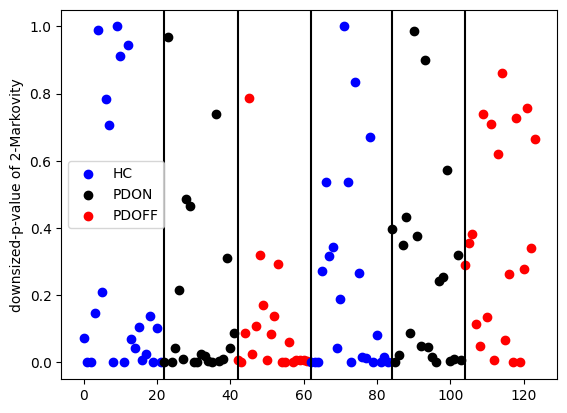

HC vs PDON: p=0.2919
HC vs PDOFF: p=0.0691
PDON vs PDOFF: p=0.3889
HC vs PD-COMB: p=0.4302
(GVS) HC vs PDON: p=0.8315
(GVS) HC vs PDOFF: p=0.1551
(GVS) PDON vs PDOFF: p=0.2293
(GVS) HC vs PD-COMB: p=0.3369
GVS- HC vs GVS+ HC: p=0.6325
GVS- PDON vs GVS+ PDON: p=0.3755
GVS- PDOFF GVS+ PDOFF: p=0.0019
GVS- vs GVS+: p=0.0892
###############################
Dataset is entirely NaN, skipping.
Cross validation score for 3-class downsized-geoTest for Map0: 0.0000 ±0.0000
Dataset is entirely NaN, skipping.
Cross validation score for 2-class downsized-geoTest for Map0: 0.0000 ±0.0000
HC mean: nan ± nan
PDON mean: nan ± nan
PDOFF mean: nan ± nan
PD-COMB mean: nan ± nan


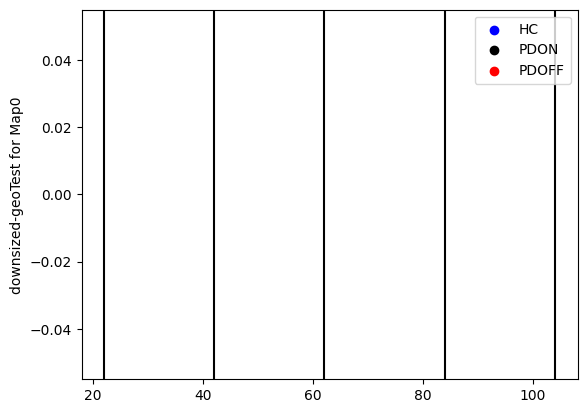

HC vs PDON: p=nan
HC vs PDOFF: p=nan
PDON vs PDOFF: p=nan
HC vs PD-COMB: p=nan
(GVS) HC vs PDON: p=nan
(GVS) HC vs PDOFF: p=nan
(GVS) PDON vs PDOFF: p=nan
(GVS) HC vs PD-COMB: p=nan
GVS- HC vs GVS+ HC: p=nan
GVS- PDON vs GVS+ PDON: p=nan
GVS- PDOFF GVS+ PDOFF: p=nan
GVS- vs GVS+: p=nan
###############################
Dataset is entirely NaN, skipping.
Cross validation score for 3-class downsized-geoTest for Map1: 0.0000 ±0.0000
Dataset is entirely NaN, skipping.
Cross validation score for 2-class downsized-geoTest for Map1: 0.0000 ±0.0000
HC mean: nan ± nan
PDON mean: nan ± nan
PDOFF mean: nan ± nan
PD-COMB mean: nan ± nan


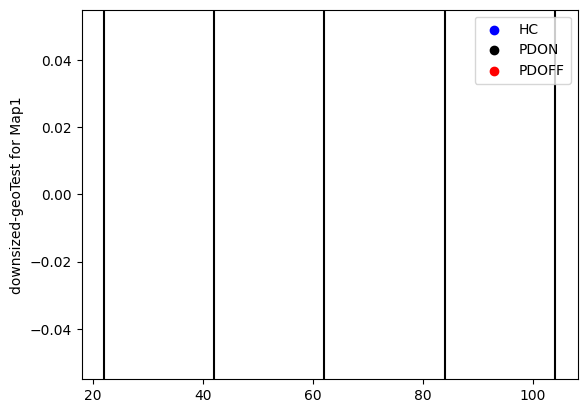

HC vs PDON: p=nan
HC vs PDOFF: p=nan
PDON vs PDOFF: p=nan
HC vs PD-COMB: p=nan
(GVS) HC vs PDON: p=nan
(GVS) HC vs PDOFF: p=nan
(GVS) PDON vs PDOFF: p=nan
(GVS) HC vs PD-COMB: p=nan
GVS- HC vs GVS+ HC: p=nan
GVS- PDON vs GVS+ PDON: p=nan
GVS- PDOFF GVS+ PDOFF: p=nan
GVS- vs GVS+: p=nan
###############################
Dataset is entirely NaN, skipping.
Cross validation score for 3-class downsized-geoTest for Map2: 0.0000 ±0.0000
Dataset is entirely NaN, skipping.
Cross validation score for 2-class downsized-geoTest for Map2: 0.0000 ±0.0000
HC mean: nan ± nan
PDON mean: nan ± nan
PDOFF mean: nan ± nan
PD-COMB mean: nan ± nan


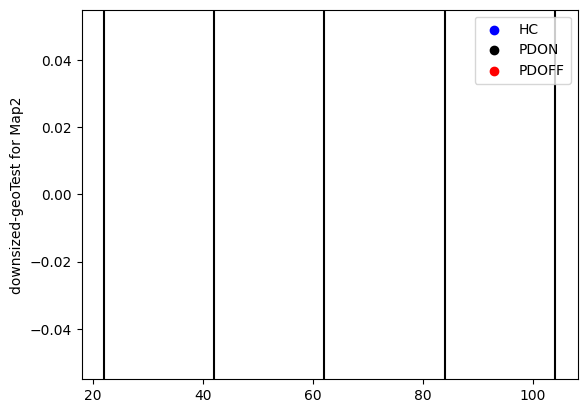

HC vs PDON: p=nan
HC vs PDOFF: p=nan
PDON vs PDOFF: p=nan
HC vs PD-COMB: p=nan
(GVS) HC vs PDON: p=nan
(GVS) HC vs PDOFF: p=nan
(GVS) PDON vs PDOFF: p=nan
(GVS) HC vs PD-COMB: p=nan
GVS- HC vs GVS+ HC: p=nan
GVS- PDON vs GVS+ PDON: p=nan
GVS- PDOFF GVS+ PDOFF: p=nan
GVS- vs GVS+: p=nan
###############################
Dataset is entirely NaN, skipping.
Cross validation score for 3-class downsized-geoTest for Map3: 0.0000 ±0.0000
Dataset is entirely NaN, skipping.
Cross validation score for 2-class downsized-geoTest for Map3: 0.0000 ±0.0000
HC mean: nan ± nan
PDON mean: nan ± nan
PDOFF mean: nan ± nan
PD-COMB mean: nan ± nan


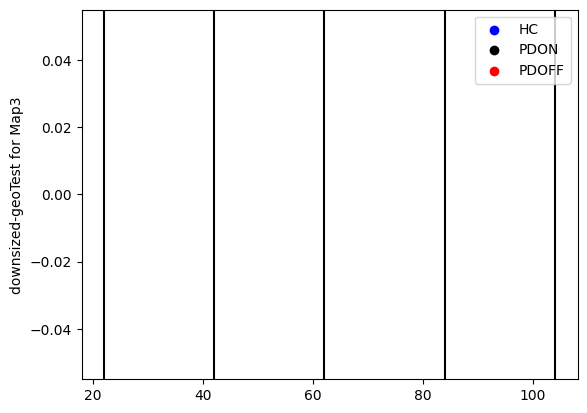

HC vs PDON: p=nan
HC vs PDOFF: p=nan
PDON vs PDOFF: p=nan
HC vs PD-COMB: p=nan
(GVS) HC vs PDON: p=nan
(GVS) HC vs PDOFF: p=nan
(GVS) PDON vs PDOFF: p=nan
(GVS) HC vs PD-COMB: p=nan
GVS- HC vs GVS+ HC: p=nan
GVS- PDON vs GVS+ PDON: p=nan
GVS- PDOFF GVS+ PDOFF: p=nan
GVS- vs GVS+: p=nan
###############################
Dataset is entirely NaN, skipping.
Cross validation score for 3-class downsized-conditional homogeneity: 0.0000 ±0.0000
Dataset is entirely NaN, skipping.
Cross validation score for 2-class downsized-conditional homogeneity: 0.0000 ±0.0000
HC mean: nan ± nan
PDON mean: nan ± nan
PDOFF mean: nan ± nan
PD-COMB mean: nan ± nan


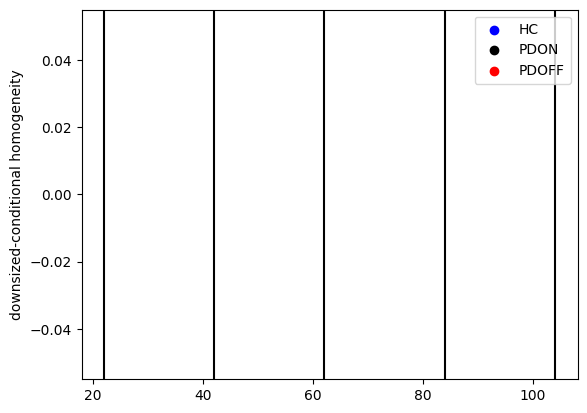

HC vs PDON: p=nan
HC vs PDOFF: p=nan
PDON vs PDOFF: p=nan
HC vs PD-COMB: p=nan
(GVS) HC vs PDON: p=nan
(GVS) HC vs PDOFF: p=nan
(GVS) PDON vs PDOFF: p=nan
(GVS) HC vs PD-COMB: p=nan
GVS- HC vs GVS+ HC: p=nan
GVS- PDON vs GVS+ PDON: p=nan
GVS- PDOFF GVS+ PDOFF: p=nan
GVS- vs GVS+: p=nan
###############################
Cross validation score for 3-class downsized-symmetry test: 0.2587 ±0.0451
Cross validation score for 2-class downsized-symmetry test: 0.6453 ±0.0107
HC mean: 0.2624 ± 0.3287
PDON mean: 0.4987 ± 0.3470
PDOFF mean: 0.4295 ± 0.3785
PD-COMB mean: 0.3911 ± 0.3682


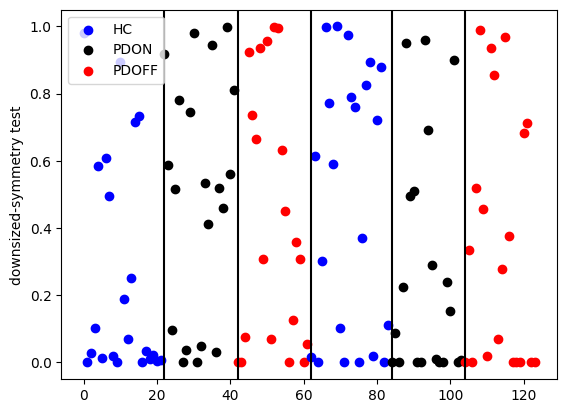

HC vs PDON: p=0.0328
HC vs PDOFF: p=0.1430
PDON vs PDOFF: p=0.5605
HC vs PD-COMB: p=0.3436
(GVS) HC vs PDON: p=0.0736
(GVS) HC vs PDOFF: p=0.2898
(GVS) PDON vs PDOFF: p=0.4714
(GVS) HC vs PD-COMB: p=0.0914
GVS- HC vs GVS+ HC: p=0.0471
GVS- PDON vs GVS+ PDON: p=0.0533
GVS- PDOFF GVS+ PDOFF: p=0.5699
GVS- vs GVS+: p=0.8344
###############################
Cross validation score for 3-class downsized-Maximum AIF value in 27-37: 0.2180 ±0.0337
Cross validation score for 2-class downsized-Maximum AIF value in 27-37: 0.7177 ±0.0671
HC mean: 0.0019 ± 0.0020
PDON mean: 0.0026 ± 0.0016
PDOFF mean: 0.0032 ± 0.0020
PD-COMB mean: 0.0029 ± 0.0019


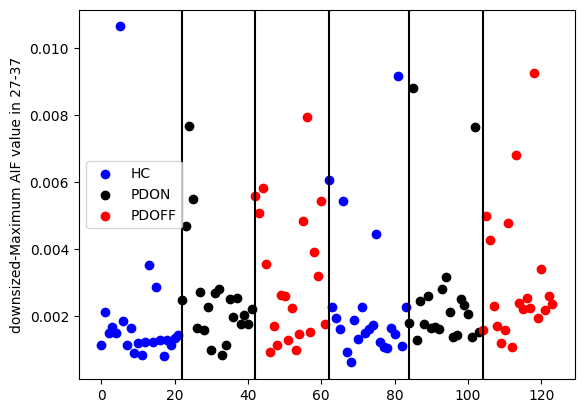

HC vs PDON: p=0.2513
HC vs PDOFF: p=0.0512
PDON vs PDOFF: p=0.3141
HC vs PD-COMB: p=0.7169
(GVS) HC vs PDON: p=0.7430
(GVS) HC vs PDOFF: p=0.2916
(GVS) PDON vs PDOFF: p=0.4655
(GVS) HC vs PD-COMB: p=0.4140
GVS- HC vs GVS+ HC: p=0.4522
GVS- PDON vs GVS+ PDON: p=0.9879
GVS- PDOFF GVS+ PDOFF: p=0.8657
GVS- vs GVS+: p=0.7067
###############################
Cross validation score for 3-class downsized-Location of Maximum AIF value after 15: 0.1453 ±0.0208
Cross validation score for 2-class downsized-Location of Maximum AIF value after 15: 0.6453 ±0.0275
HC mean: 5.9091 ± 18.9279
PDON mean: 0.0000 ± 0.0000
PDOFF mean: 0.0000 ± 0.0000
PD-COMB mean: 1.1000 ± 7.8479


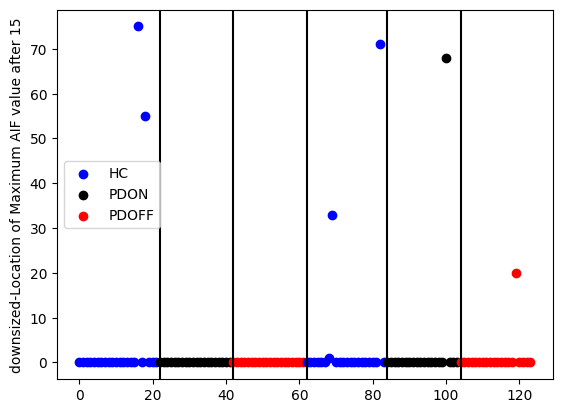

HC vs PDON: p=0.1807
HC vs PDOFF: p=0.1807
PDON vs PDOFF: p=nan
HC vs PD-COMB: p=0.4161
(GVS) HC vs PDON: p=0.7804
(GVS) HC vs PDOFF: p=0.3251
(GVS) PDON vs PDOFF: p=0.5024
(GVS) HC vs PD-COMB: p=0.4658
GVS- HC vs GVS+ HC: p=0.8346
GVS- PDON vs GVS+ PDON: p=0.3236
GVS- PDOFF GVS+ PDOFF: p=0.3236
GVS- vs GVS+: p=0.6505
###############################
Cross validation score for 3-class downsized-Number of Maxima in AIF between 0-50: 0.1613 ±0.0254
Cross validation score for 2-class downsized-Number of Maxima in AIF between 0-50: 0.6133 ±0.0513
HC mean: 10.1364 ± 2.0954
PDON mean: 9.4500 ± 2.4182
PDOFF mean: 9.2000 ± 1.6912
PD-COMB mean: 8.9125 ± 2.1166


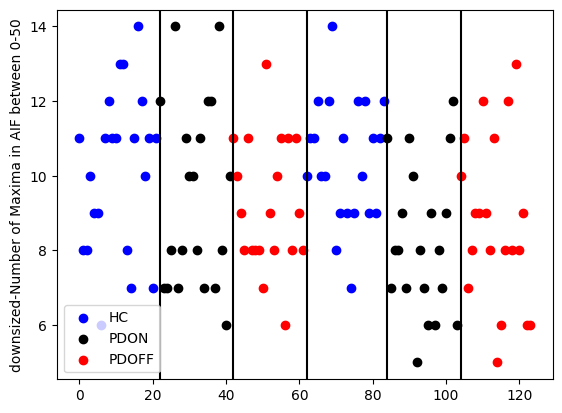

HC vs PDON: p=0.3421
HC vs PDOFF: p=0.1301
PDON vs PDOFF: p=0.7140
HC vs PD-COMB: p=0.6876
(GVS) HC vs PDON: p=0.0004
(GVS) HC vs PDOFF: p=0.0082
(GVS) PDON vs PDOFF: p=0.4560
(GVS) HC vs PD-COMB: p=0.0005
GVS- HC vs GVS+ HC: p=0.6368
GVS- PDON vs GVS+ PDON: p=0.0985
GVS- PDOFF GVS+ PDOFF: p=0.4796
GVS- vs GVS+: p=0.2590
###############################
Cross validation score for 3-class downsized-Number of Minima in AIF between 0-50: 0.1537 ±0.0701
Cross validation score for 2-class downsized-Number of Minima in AIF between 0-50: 0.6133 ±0.0513
HC mean: 10.5000 ± 2.0394
PDON mean: 9.9500 ± 2.3125
PDOFF mean: 9.5500 ± 1.5644
PD-COMB mean: 9.4875 ± 2.0248


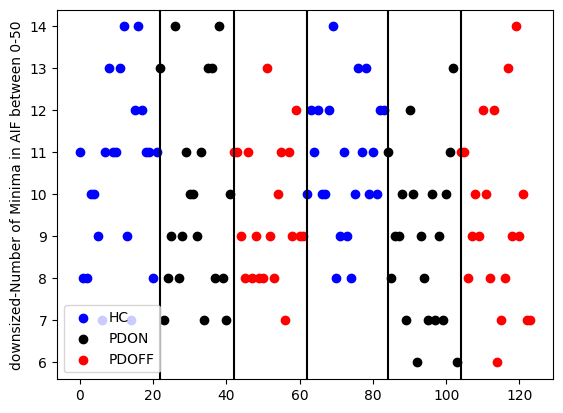

HC vs PDON: p=0.4289
HC vs PDOFF: p=0.1086
PDON vs PDOFF: p=0.5360
HC vs PD-COMB: p=0.7306
(GVS) HC vs PDON: p=0.0015
(GVS) HC vs PDOFF: p=0.0292
(GVS) PDON vs PDOFF: p=0.4048
(GVS) HC vs PD-COMB: p=0.0026
GVS- HC vs GVS+ HC: p=0.5728
GVS- PDON vs GVS+ PDON: p=0.1543
GVS- PDOFF GVS+ PDOFF: p=0.9343
GVS- vs GVS+: p=0.5403
###############################
Cross validation score for 3-class downsized-Number of samples: 0.2420 ±0.0256
Cross validation score for 2-class downsized-Number of samples: 0.7093 ±0.0331
HC mean: 6644.4545 ± 546.2781
PDON mean: 5949.2500 ± 721.0412
PDOFF mean: 6012.3000 ± 695.5524
PD-COMB mean: 5950.0250 ± 725.3232


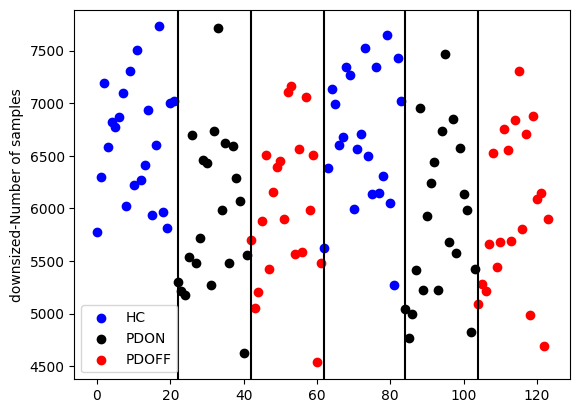

HC vs PDON: p=0.0013
HC vs PDOFF: p=0.0026
PDON vs PDOFF: p=0.7853
HC vs PD-COMB: p=0.4066
(GVS) HC vs PDON: p=0.0009
(GVS) HC vs PDOFF: p=0.0019
(GVS) PDON vs PDOFF: p=0.7156
(GVS) HC vs PD-COMB: p=0.0002
GVS- HC vs GVS+ HC: p=0.8970
GVS- PDON vs GVS+ PDON: p=0.7603
GVS- PDOFF GVS+ PDOFF: p=0.8314
GVS- vs GVS+: p=0.8204
###############################
Cross validation score for 3-class downsized-MeanAIFInBand - Alpha: 0.1617 ±0.0280
Cross validation score for 2-class downsized-MeanAIFInBand - Alpha: 0.6133 ±0.0446
HC mean: 0.0320 ± 0.0173
PDON mean: 0.0323 ± 0.0130
PDOFF mean: 0.0365 ± 0.0142
PD-COMB mean: 0.0381 ± 0.0172


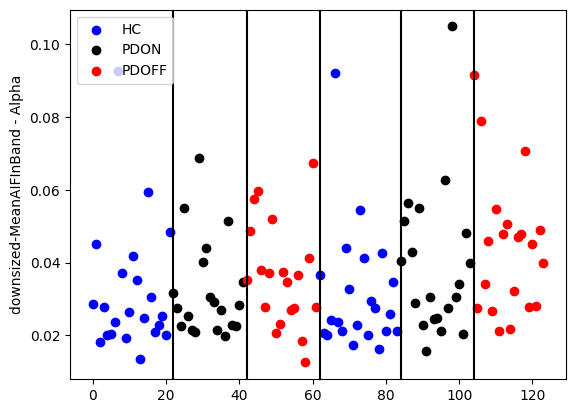

HC vs PDON: p=0.9538
HC vs PDOFF: p=0.3706
PDON vs PDOFF: p=0.3392
HC vs PD-COMB: p=0.2871
(GVS) HC vs PDON: p=0.1876
(GVS) HC vs PDOFF: p=0.0229
(GVS) PDON vs PDOFF: p=0.4006
(GVS) HC vs PD-COMB: p=0.0407
GVS- HC vs GVS+ HC: p=0.9122
GVS- PDON vs GVS+ PDON: p=0.2158
GVS- PDOFF GVS+ PDOFF: p=0.1452
GVS- vs GVS+: p=0.1452
###############################
Cross validation score for 3-class downsized-MeanAIFInBand - Beta: 0.2180 ±0.0658
Cross validation score for 2-class downsized-MeanAIFInBand - Beta: 0.7180 ±0.0553
HC mean: 0.0617 ± 0.0527
PDON mean: 0.0961 ± 0.0519
PDOFF mean: 0.1128 ± 0.0682
PD-COMB mean: 0.1042 ± 0.0622


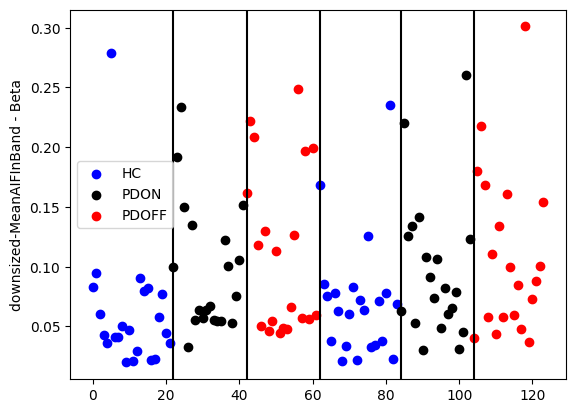

HC vs PDON: p=0.0445
HC vs PDOFF: p=0.0111
PDON vs PDOFF: p=0.4006
HC vs PD-COMB: p=0.9434
(GVS) HC vs PDON: p=0.1374
(GVS) HC vs PDOFF: p=0.0398
(GVS) PDON vs PDOFF: p=0.5057
(GVS) HC vs PD-COMB: p=0.0438
GVS- HC vs GVS+ HC: p=0.5431
GVS- PDON vs GVS+ PDON: p=0.9533
GVS- PDOFF GVS+ PDOFF: p=0.9291
GVS- vs GVS+: p=0.7779
###############################
Cross validation score for 3-class downsized-MeanAIFInBand - Gamma: 0.1697 ±0.0318
Cross validation score for 2-class downsized-MeanAIFInBand - Gamma: 0.6617 ±0.0809
HC mean: 0.5505 ± 0.2179
PDON mean: 0.7827 ± 0.2544
PDOFF mean: 0.8446 ± 0.3469
PD-COMB mean: 0.7938 ± 0.3203


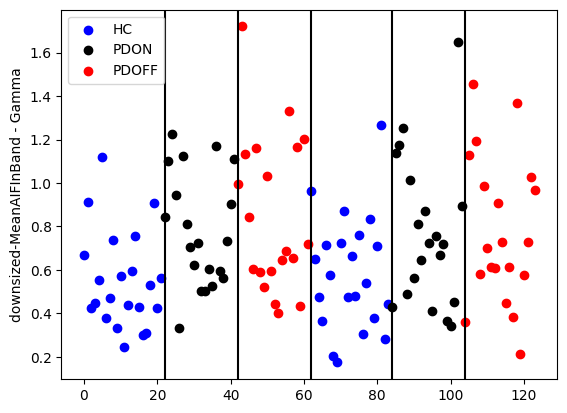

HC vs PDON: p=0.0035
HC vs PDOFF: p=0.0024
PDON vs PDOFF: p=0.5345
HC vs PD-COMB: p=0.6570
(GVS) HC vs PDON: p=0.0579
(GVS) HC vs PDOFF: p=0.0433
(GVS) PDON vs PDOFF: p=0.9155
(GVS) HC vs PD-COMB: p=0.0265
GVS- HC vs GVS+ HC: p=0.6487
GVS- PDON vs GVS+ PDON: p=0.8817
GVS- PDOFF GVS+ PDOFF: p=0.5596
GVS- vs GVS+: p=0.8120
###############################
Cross validation score for 3-class Mean time in state1: 0.1850 ±0.0640
Cross validation score for 2-class Mean time in state1: 0.6927 ±0.0653
HC mean: 0.0096 ± 0.0017
PDON mean: 0.0122 ± 0.0026
PDOFF mean: 0.0120 ± 0.0030
PD-COMB mean: 0.0121 ± 0.0032


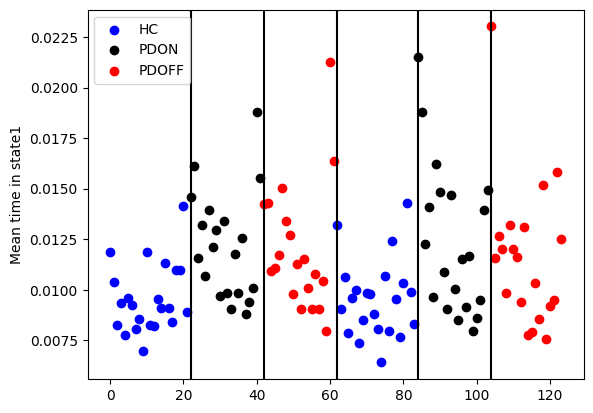

HC vs PDON: p=0.0005
HC vs PDOFF: p=0.0030
PDON vs PDOFF: p=0.8401
HC vs PD-COMB: p=0.3753
(GVS) HC vs PDON: p=0.0029
(GVS) HC vs PDOFF: p=0.0218
(GVS) PDON vs PDOFF: p=0.5177
(GVS) HC vs PD-COMB: p=0.0043
GVS- HC vs GVS+ HC: p=0.9604
GVS- PDON vs GVS+ PDON: p=0.8458
GVS- PDOFF GVS+ PDOFF: p=0.7341
GVS- vs GVS+: p=0.9099
###############################
Cross validation score for 3-class Max time in state1: 0.1843 ±0.0818
Cross validation score for 2-class Max time in state1: 0.6453 ±0.0107
HC mean: 0.0637 ± 0.0131
PDON mean: 0.0750 ± 0.0191
PDOFF mean: 0.0759 ± 0.0214
PD-COMB mean: 0.0762 ± 0.0217


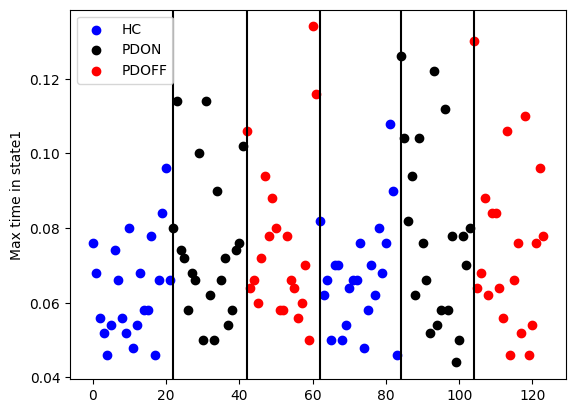

HC vs PDON: p=0.0342
HC vs PDOFF: p=0.0340
PDON vs PDOFF: p=0.8919
HC vs PD-COMB: p=0.8856
(GVS) HC vs PDON: p=0.0787
(GVS) HC vs PDOFF: p=0.1778
(GVS) PDON vs PDOFF: p=0.6695
(GVS) HC vs PD-COMB: p=0.0872
GVS- HC vs GVS+ HC: p=0.3940
GVS- PDON vs GVS+ PDON: p=0.6216
GVS- PDOFF GVS+ PDOFF: p=0.9322
GVS- vs GVS+: p=0.5377
###############################
Cross validation score for 3-class Std of time in state1: 0.2007 ±0.0704
Cross validation score for 2-class Std of time in state1: 0.6850 ±0.0500
HC mean: 0.0083 ± 0.0012
PDON mean: 0.0104 ± 0.0022
PDOFF mean: 0.0103 ± 0.0023
PD-COMB mean: 0.0103 ± 0.0025


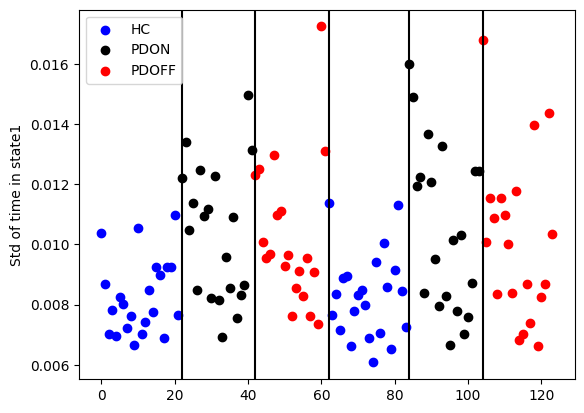

HC vs PDON: p=0.0005
HC vs PDOFF: p=0.0014
PDON vs PDOFF: p=0.8795
HC vs PD-COMB: p=0.4062
(GVS) HC vs PDON: p=0.0015
(GVS) HC vs PDOFF: p=0.0080
(GVS) PDON vs PDOFF: p=0.6124
(GVS) HC vs PD-COMB: p=0.0016
GVS- HC vs GVS+ HC: p=0.9691
GVS- PDON vs GVS+ PDON: p=0.8262
GVS- PDOFF GVS+ PDOFF: p=0.8502
GVS- vs GVS+: p=0.9761
###############################
Cross validation score for 3-class Skew of time in state1: 0.2093 ±0.0376
Cross validation score for 2-class Skew of time in state1: 0.6530 ±0.0340
HC mean: 1.8000 ± 0.1911
PDON mean: 1.6125 ± 0.2085
PDOFF mean: 1.6466 ± 0.2336
PD-COMB mean: 1.6548 ± 0.2308


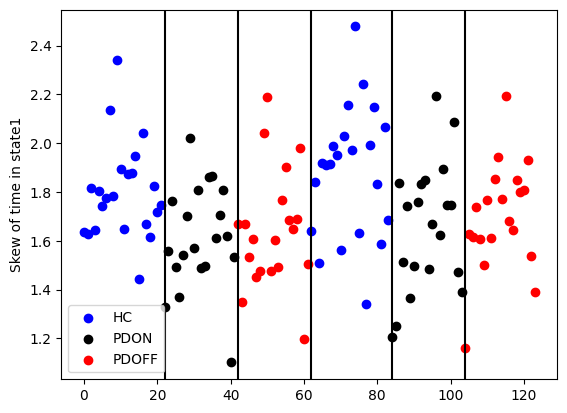

HC vs PDON: p=0.0050
HC vs PDOFF: p=0.0280
PDON vs PDOFF: p=0.6377
HC vs PD-COMB: p=0.1388
(GVS) HC vs PDON: p=0.0092
(GVS) HC vs PDOFF: p=0.0231
(GVS) PDON vs PDOFF: p=0.5692
(GVS) HC vs PD-COMB: p=0.0035
GVS- HC vs GVS+ HC: p=0.2532
GVS- PDON vs GVS+ PDON: p=0.5496
GVS- PDOFF GVS+ PDOFF: p=0.4514
GVS- vs GVS+: p=0.1691
###############################
Cross validation score for 3-class Number of distinct occurrences of state1: 0.1770 ±0.0533
Cross validation score for 2-class Number of distinct occurrences of state1: 0.6860 ±0.0504
HC mean: 1705.2727 ± 155.2851
PDON mean: 1551.4500 ± 161.2360
PDOFF mean: 1574.0000 ± 168.6932
PD-COMB mean: 1551.6625 ± 163.4772


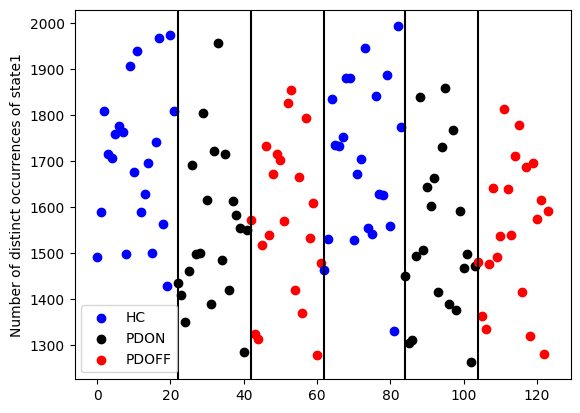

HC vs PDON: p=0.0038
HC vs PDOFF: p=0.0143
PDON vs PDOFF: p=0.6760
HC vs PD-COMB: p=0.4538
(GVS) HC vs PDON: p=0.0033
(GVS) HC vs PDOFF: p=0.0050
(GVS) PDON vs PDOFF: p=0.7416
(GVS) HC vs PD-COMB: p=0.0006
GVS- HC vs GVS+ HC: p=0.9079
GVS- PDON vs GVS+ PDON: p=0.7193
GVS- PDOFF GVS+ PDOFF: p=0.6353
GVS- vs GVS+: p=0.6131
###############################
Cross validation score for 3-class Median time in state1: 0.1843 ±0.0893
Cross validation score for 2-class Median time in state1: 0.6203 ±0.0468
HC mean: 0.0068 ± 0.0015
PDON mean: 0.0091 ± 0.0020
PDOFF mean: 0.0086 ± 0.0025
PD-COMB mean: 0.0088 ± 0.0028


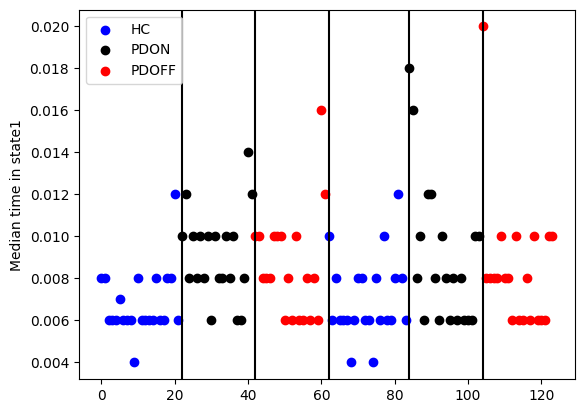

HC vs PDON: p=0.0002
HC vs PDOFF: p=0.0069
PDON vs PDOFF: p=0.4997
HC vs PD-COMB: p=0.2750
(GVS) HC vs PDON: p=0.0226
(GVS) HC vs PDOFF: p=0.0870
(GVS) PDON vs PDOFF: p=0.5664
(GVS) HC vs PD-COMB: p=0.0288
GVS- HC vs GVS+ HC: p=0.6704
GVS- PDON vs GVS+ PDON: p=0.9115
GVS- PDOFF GVS+ PDOFF: p=0.8258
GVS- vs GVS+: p=0.9729
###############################
Cross validation score for 3-class Mean time in state2: 0.1613 ±0.0254
Cross validation score for 2-class Mean time in state2: 0.6453 ±0.0107
HC mean: 0.0082 ± 0.0012
PDON mean: 0.0082 ± 0.0012
PDOFF mean: 0.0083 ± 0.0015
PD-COMB mean: 0.0084 ± 0.0014


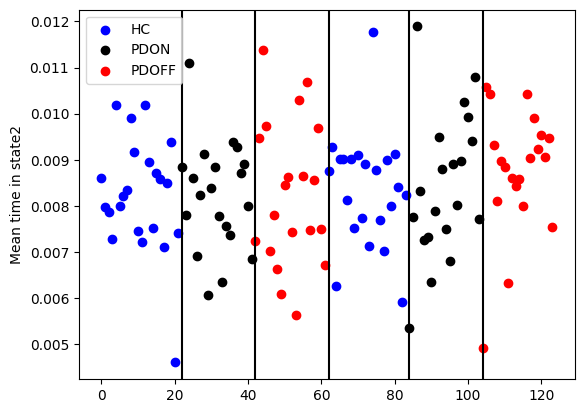

HC vs PDON: p=0.9407
HC vs PDOFF: p=0.9644
PDON vs PDOFF: p=0.9146
HC vs PD-COMB: p=0.5536
(GVS) HC vs PDON: p=0.8469
(GVS) HC vs PDOFF: p=0.3086
(GVS) PDON vs PDOFF: p=0.4865
(GVS) HC vs PD-COMB: p=0.5025
GVS- HC vs GVS+ HC: p=0.7499
GVS- PDON vs GVS+ PDON: p=0.6027
GVS- PDOFF GVS+ PDOFF: p=0.2798
GVS- vs GVS+: p=0.2471
###############################
Cross validation score for 3-class Max time in state2: 0.1933 ±0.0286
Cross validation score for 2-class Max time in state2: 0.6453 ±0.0107
HC mean: 0.0561 ± 0.0133
PDON mean: 0.0521 ± 0.0081
PDOFF mean: 0.0540 ± 0.0094
PD-COMB mean: 0.0544 ± 0.0109


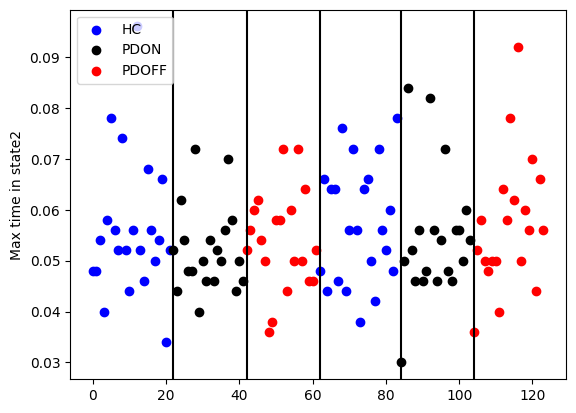

HC vs PDON: p=0.2632
HC vs PDOFF: p=0.5726
PDON vs PDOFF: p=0.5094
HC vs PD-COMB: p=0.2622
(GVS) HC vs PDON: p=0.4636
(GVS) HC vs PDOFF: p=0.9243
(GVS) PDON vs PDOFF: p=0.5558
(GVS) HC vs PD-COMB: p=0.6342
GVS- HC vs GVS+ HC: p=0.7404
GVS- PDON vs GVS+ PDON: p=0.4620
GVS- PDOFF GVS+ PDOFF: p=0.4128
GVS- vs GVS+: p=0.2854
###############################
Cross validation score for 3-class Std of time in state2: 0.2177 ±0.0539
Cross validation score for 2-class Std of time in state2: 0.6453 ±0.0107
HC mean: 0.0070 ± 0.0010
PDON mean: 0.0073 ± 0.0010
PDOFF mean: 0.0072 ± 0.0012
PD-COMB mean: 0.0074 ± 0.0012


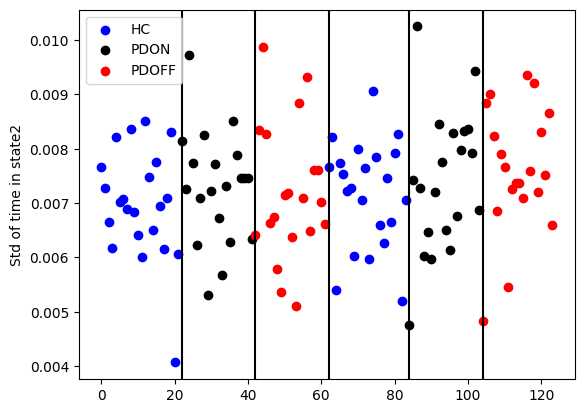

HC vs PDON: p=0.3244
HC vs PDOFF: p=0.5411
PDON vs PDOFF: p=0.7877
HC vs PD-COMB: p=0.8675
(GVS) HC vs PDON: p=0.5289
(GVS) HC vs PDOFF: p=0.1999
(GVS) PDON vs PDOFF: p=0.5967
(GVS) HC vs PD-COMB: p=0.2842
GVS- HC vs GVS+ HC: p=0.4872
GVS- PDON vs GVS+ PDON: p=0.7488
GVS- PDOFF GVS+ PDOFF: p=0.2740
GVS- vs GVS+: p=0.2147
###############################
Cross validation score for 3-class Skew of time in state2: 0.1290 ±0.0465
Cross validation score for 2-class Skew of time in state2: 0.6373 ±0.0213
HC mean: 1.8365 ± 0.2568
PDON mean: 1.8826 ± 0.1989
PDOFF mean: 1.8644 ± 0.2599
PD-COMB mean: 1.8624 ± 0.2449


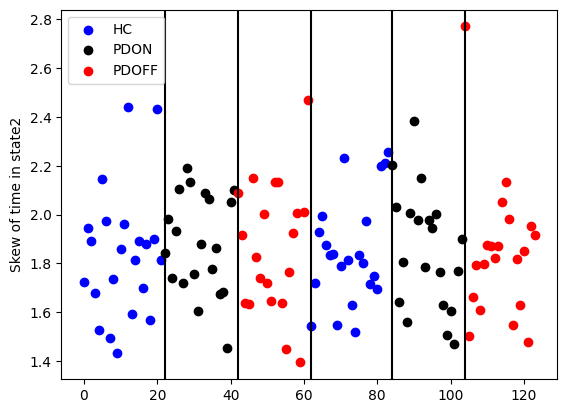

HC vs PDON: p=0.5319
HC vs PDOFF: p=0.7350
PDON vs PDOFF: p=0.8092
HC vs PD-COMB: p=0.6907
(GVS) HC vs PDON: p=0.9397
(GVS) HC vs PDOFF: p=0.9706
(GVS) PDON vs PDOFF: p=0.9206
(GVS) HC vs PD-COMB: p=0.9843
GVS- HC vs GVS+ HC: p=0.8549
GVS- PDON vs GVS+ PDON: p=0.7055
GVS- PDOFF GVS+ PDOFF: p=0.8430
GVS- vs GVS+: p=0.8282
###############################
Cross validation score for 3-class Number of distinct occurrences of state2: 0.2743 ±0.0894
Cross validation score for 2-class Number of distinct occurrences of state2: 0.6850 ±0.0349
HC mean: 1606.6364 ± 134.1250
PDON mean: 1412.6000 ± 207.2075
PDOFF mean: 1416.0500 ± 193.1783
PD-COMB mean: 1411.7375 ± 213.8327


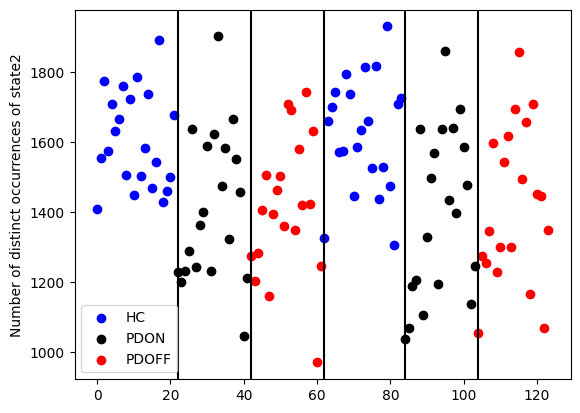

HC vs PDON: p=0.0010
HC vs PDOFF: p=0.0007
PDON vs PDOFF: p=0.9579
HC vs PD-COMB: p=0.4086
(GVS) HC vs PDON: p=0.0009
(GVS) HC vs PDOFF: p=0.0016
(GVS) PDON vs PDOFF: p=0.7567
(GVS) HC vs PD-COMB: p=0.0003
GVS- HC vs GVS+ HC: p=0.7171
GVS- PDON vs GVS+ PDON: p=0.8367
GVS- PDOFF GVS+ PDOFF: p=0.9460
GVS- vs GVS+: p=0.9485
###############################
Cross validation score for 3-class Median time in state2: 0.1693 ±0.0155
Cross validation score for 2-class Median time in state2: 0.6453 ±0.0107
HC mean: 0.0062 ± 0.0010
PDON mean: 0.0056 ± 0.0010
PDOFF mean: 0.0059 ± 0.0015
PD-COMB mean: 0.0059 ± 0.0012


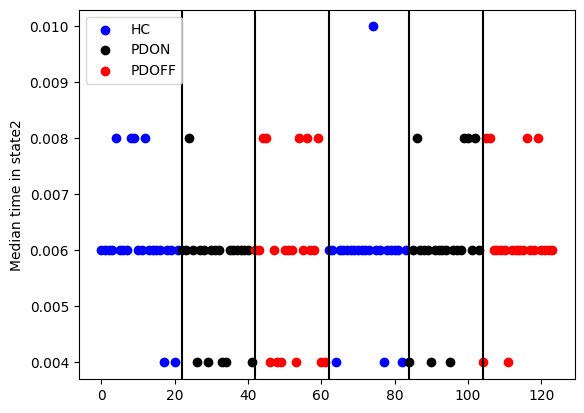

HC vs PDON: p=0.0804
HC vs PDOFF: p=0.4853
PDON vs PDOFF: p=0.4713
HC vs PD-COMB: p=0.2413
(GVS) HC vs PDON: p=0.6032
(GVS) HC vs PDOFF: p=0.4094
(GVS) PDON vs PDOFF: p=0.7864
(GVS) HC vs PD-COMB: p=0.4318
GVS- HC vs GVS+ HC: p=0.4168
GVS- PDON vs GVS+ PDON: p=0.1702
GVS- PDOFF GVS+ PDOFF: p=0.4793
GVS- vs GVS+: p=0.4498
###############################
Cross validation score for 3-class Mean time in state3: 0.1853 ±0.0401
Cross validation score for 2-class Mean time in state3: 0.6693 ±0.0155
HC mean: 0.0093 ± 0.0013
PDON mean: 0.0101 ± 0.0011
PDOFF mean: 0.0098 ± 0.0010
PD-COMB mean: 0.0100 ± 0.0013


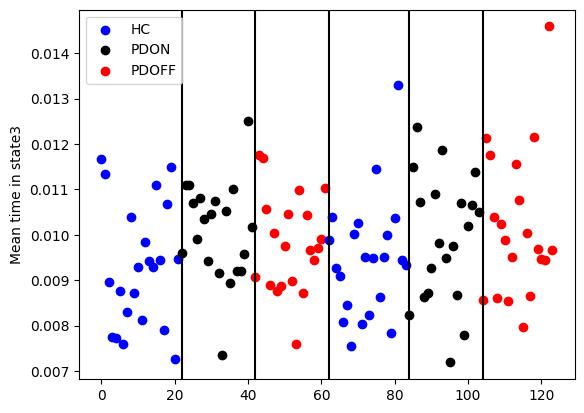

HC vs PDON: p=0.0439
HC vs PDOFF: p=0.1794
PDON vs PDOFF: p=0.4258
HC vs PD-COMB: p=0.5118
(GVS) HC vs PDON: p=0.2820
(GVS) HC vs PDOFF: p=0.1160
(GVS) PDON vs PDOFF: p=0.5819
(GVS) HC vs PD-COMB: p=0.1266
GVS- HC vs GVS+ HC: p=0.6826
GVS- PDON vs GVS+ PDON: p=0.6662
GVS- PDOFF GVS+ PDOFF: p=0.4000
GVS- vs GVS+: p=0.6147
###############################
Cross validation score for 3-class Max time in state3: 0.1617 ±0.0377
Cross validation score for 2-class Max time in state3: 0.6453 ±0.0107
HC mean: 0.0636 ± 0.0115
PDON mean: 0.0698 ± 0.0185
PDOFF mean: 0.0673 ± 0.0128
PD-COMB mean: 0.0663 ± 0.0156


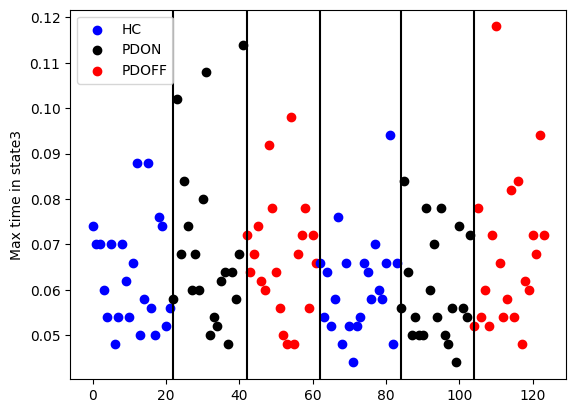

HC vs PDON: p=0.2083
HC vs PDOFF: p=0.3472
PDON vs PDOFF: p=0.6307
HC vs PD-COMB: p=0.2207
(GVS) HC vs PDON: p=0.8591
(GVS) HC vs PDOFF: p=0.1054
(GVS) PDON vs PDOFF: p=0.0968
(GVS) HC vs PD-COMB: p=0.3661
GVS- HC vs GVS+ HC: p=0.4018
GVS- PDON vs GVS+ PDON: p=0.0592
GVS- PDOFF GVS+ PDOFF: p=0.8854
GVS- vs GVS+: p=0.1279
###############################
Cross validation score for 3-class Std of time in state3: 0.2173 ±0.0390
Cross validation score for 2-class Std of time in state3: 0.6777 ±0.0489
HC mean: 0.0079 ± 0.0011
PDON mean: 0.0087 ± 0.0010
PDOFF mean: 0.0085 ± 0.0010
PD-COMB mean: 0.0086 ± 0.0011


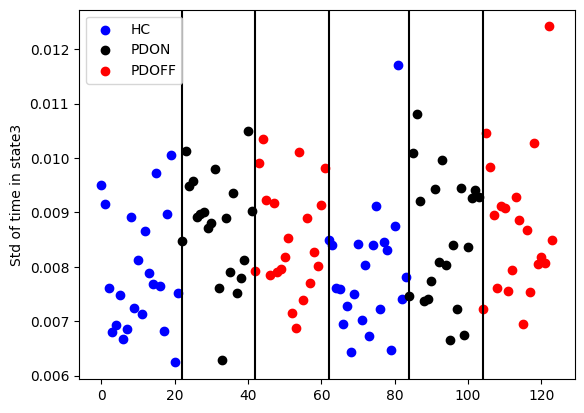

HC vs PDON: p=0.0119
HC vs PDOFF: p=0.0617
PDON vs PDOFF: p=0.4801
HC vs PD-COMB: p=0.3282
(GVS) HC vs PDON: p=0.0998
(GVS) HC vs PDOFF: p=0.0364
(GVS) PDON vs PDOFF: p=0.5975
(GVS) HC vs PD-COMB: p=0.0299
GVS- HC vs GVS+ HC: p=0.9464
GVS- PDON vs GVS+ PDON: p=0.5178
GVS- PDOFF GVS+ PDOFF: p=0.5724
GVS- vs GVS+: p=0.9894
###############################
Cross validation score for 3-class Skew of time in state3: 0.1453 ±0.0328
Cross validation score for 2-class Skew of time in state3: 0.6453 ±0.0107
HC mean: 1.7663 ± 0.1923
PDON mean: 1.8071 ± 0.2348
PDOFF mean: 1.8107 ± 0.2872
PD-COMB mean: 1.7750 ± 0.2628


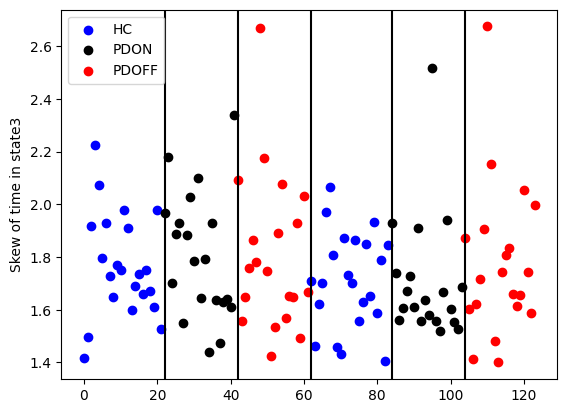

HC vs PDON: p=0.5499
HC vs PDOFF: p=0.5659
PDON vs PDOFF: p=0.9664
HC vs PD-COMB: p=0.4519
(GVS) HC vs PDON: p=0.9217
(GVS) HC vs PDOFF: p=0.3811
(GVS) PDON vs PDOFF: p=0.3911
(GVS) HC vs PD-COMB: p=0.6384
GVS- HC vs GVS+ HC: p=0.3421
GVS- PDON vs GVS+ PDON: p=0.1792
GVS- PDOFF GVS+ PDOFF: p=0.7197
GVS- vs GVS+: p=0.1436
###############################
Cross validation score for 3-class Number of distinct occurrences of state3: 0.2820 ±0.0553
Cross validation score for 2-class Number of distinct occurrences of state3: 0.6697 ±0.0365
HC mean: 1665.9091 ± 131.8711
PDON mean: 1502.1500 ± 188.3811
PDOFF mean: 1523.1000 ± 185.7969
PD-COMB mean: 1497.2250 ± 191.8839


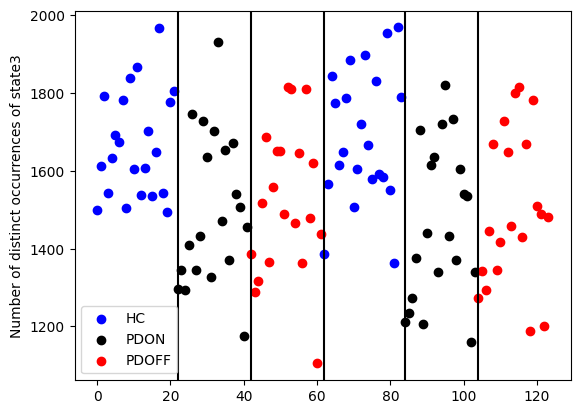

HC vs PDON: p=0.0026
HC vs PDOFF: p=0.0074
PDON vs PDOFF: p=0.7319
HC vs PD-COMB: p=0.4677
(GVS) HC vs PDON: p=0.0004
(GVS) HC vs PDOFF: p=0.0021
(GVS) PDON vs PDOFF: p=0.5858
(GVS) HC vs PD-COMB: p=0.0001
GVS- HC vs GVS+ HC: p=0.6555
GVS- PDON vs GVS+ PDON: p=0.5494
GVS- PDOFF GVS+ PDOFF: p=0.6988
GVS- vs GVS+: p=0.7284
###############################
Cross validation score for 3-class Median time in state3: 0.1283 ±0.0460
Cross validation score for 2-class Median time in state3: 0.6453 ±0.0107
HC mean: 0.0069 ± 0.0010
PDON mean: 0.0072 ± 0.0012
PDOFF mean: 0.0071 ± 0.0010
PD-COMB mean: 0.0072 ± 0.0012


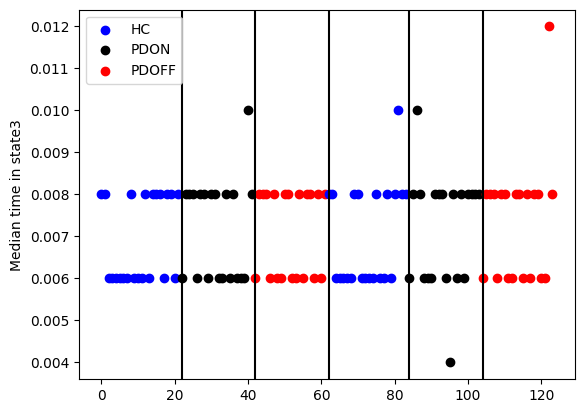

HC vs PDON: p=0.4001
HC vs PDOFF: p=0.5481
PDON vs PDOFF: p=0.7777
HC vs PD-COMB: p=0.9379
(GVS) HC vs PDON: p=0.6149
(GVS) HC vs PDOFF: p=0.3363
(GVS) PDON vs PDOFF: p=0.6573
(GVS) HC vs PD-COMB: p=0.3994
GVS- HC vs GVS+ HC: p=0.7874
GVS- PDON vs GVS+ PDON: p=1.0000
GVS- PDOFF GVS+ PDOFF: p=0.4571
GVS- vs GVS+: p=0.5525
###############################
Cross validation score for 3-class Mean time in state4: 0.2427 ±0.0866
Cross validation score for 2-class Mean time in state4: 0.6533 ±0.0304
HC mean: 0.0091 ± 0.0010
PDON mean: 0.0101 ± 0.0013
PDOFF mean: 0.0100 ± 0.0013
PD-COMB mean: 0.0101 ± 0.0013


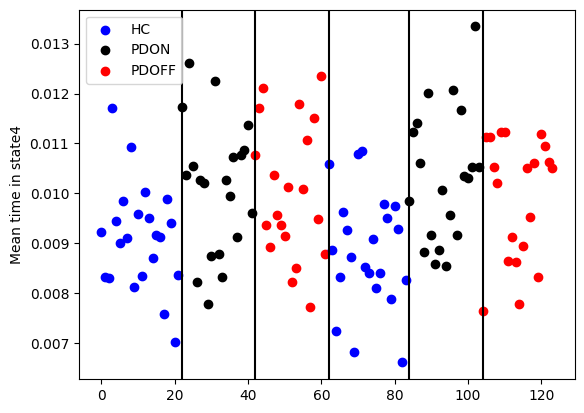

HC vs PDON: p=0.0097
HC vs PDOFF: p=0.0179
PDON vs PDOFF: p=0.8528
HC vs PD-COMB: p=0.3863
(GVS) HC vs PDON: p=0.0004
(GVS) HC vs PDOFF: p=0.0058
(GVS) PDON vs PDOFF: p=0.3119
(GVS) HC vs PD-COMB: p=0.0002
GVS- HC vs GVS+ HC: p=0.4141
GVS- PDON vs GVS+ PDON: p=0.6195
GVS- PDOFF GVS+ PDOFF: p=0.7664
GVS- vs GVS+: p=0.7744
###############################
Cross validation score for 3-class Max time in state4: 0.1540 ±0.0504
Cross validation score for 2-class Max time in state4: 0.5880 ±0.0993
HC mean: 0.0636 ± 0.0132
PDON mean: 0.0604 ± 0.0089
PDOFF mean: 0.0640 ± 0.0138
PD-COMB mean: 0.0624 ± 0.0110


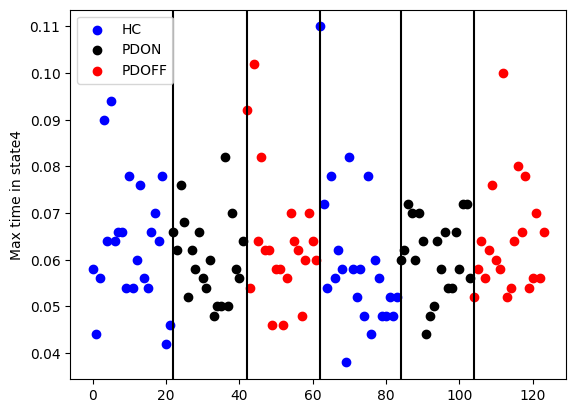

HC vs PDON: p=0.3738
HC vs PDOFF: p=0.9326
PDON vs PDOFF: p=0.3451
HC vs PD-COMB: p=0.6324
(GVS) HC vs PDON: p=0.7345
(GVS) HC vs PDOFF: p=0.3153
(GVS) PDON vs PDOFF: p=0.3468
(GVS) HC vs PD-COMB: p=0.3861
GVS- HC vs GVS+ HC: p=0.3754
GVS- PDON vs GVS+ PDON: p=0.8291
GVS- PDOFF GVS+ PDOFF: p=0.9809
GVS- vs GVS+: p=0.5953
###############################
Cross validation score for 3-class Std of time in state4: 0.2420 ±0.0671
Cross validation score for 2-class Std of time in state4: 0.6700 ±0.0663
HC mean: 0.0078 ± 0.0009
PDON mean: 0.0086 ± 0.0012
PDOFF mean: 0.0085 ± 0.0012
PD-COMB mean: 0.0086 ± 0.0012


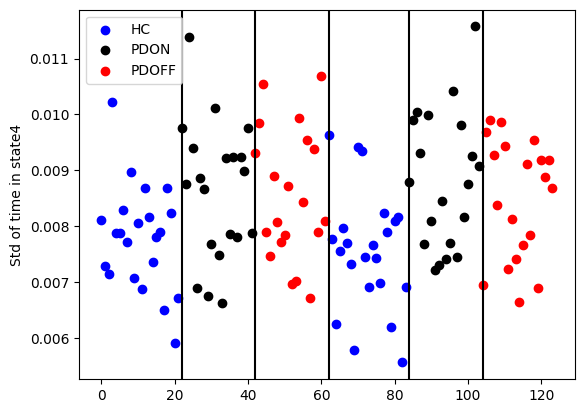

HC vs PDON: p=0.0178
HC vs PDOFF: p=0.0256
PDON vs PDOFF: p=0.8542
HC vs PD-COMB: p=0.4459
(GVS) HC vs PDON: p=0.0009
(GVS) HC vs PDOFF: p=0.0072
(GVS) PDON vs PDOFF: p=0.3734
(GVS) HC vs PD-COMB: p=0.0005
GVS- HC vs GVS+ HC: p=0.4403
GVS- PDON vs GVS+ PDON: p=0.6058
GVS- PDOFF GVS+ PDOFF: p=0.8797
GVS- vs GVS+: p=0.8654
###############################
Cross validation score for 3-class Skew of time in state4: 0.1380 ±0.0770
Cross validation score for 2-class Skew of time in state4: 0.6853 ±0.0311
HC mean: 1.8156 ± 0.2080
PDON mean: 1.6639 ± 0.1992
PDOFF mean: 1.6830 ± 0.1977
PD-COMB mean: 1.6904 ± 0.2043


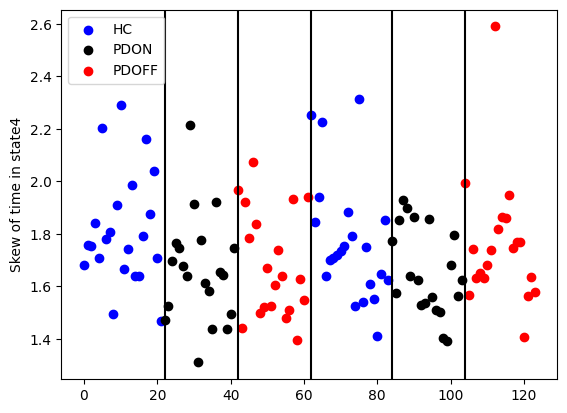

HC vs PDON: p=0.0237
HC vs PDOFF: p=0.0457
PDON vs PDOFF: p=0.7683
HC vs PD-COMB: p=0.3934
(GVS) HC vs PDON: p=0.0696
(GVS) HC vs PDOFF: p=0.8402
(GVS) PDON vs PDOFF: p=0.1216
(GVS) HC vs PD-COMB: p=0.2576
GVS- HC vs GVS+ HC: p=0.5430
GVS- PDON vs GVS+ PDON: p=0.8872
GVS- PDOFF GVS+ PDOFF: p=0.2867
GVS- vs GVS+: p=0.8565
###############################
Cross validation score for 3-class Number of distinct occurrences of state4: 0.1530 ±0.0289
Cross validation score for 2-class Number of distinct occurrences of state4: 0.7337 ±0.0335
HC mean: 1666.6364 ± 158.1689
PDON mean: 1483.0500 ± 184.7946
PDOFF mean: 1499.1500 ± 171.1404
PD-COMB mean: 1489.4000 ± 181.6825


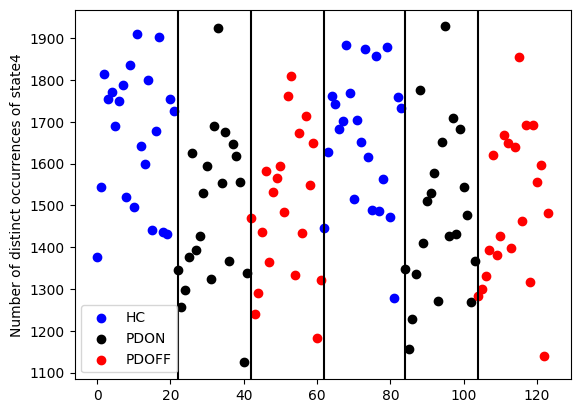

HC vs PDON: p=0.0016
HC vs PDOFF: p=0.0026
PDON vs PDOFF: p=0.7820
HC vs PD-COMB: p=0.3601
(GVS) HC vs PDON: p=0.0028
(GVS) HC vs PDOFF: p=0.0034
(GVS) PDON vs PDOFF: p=0.8283
(GVS) HC vs PD-COMB: p=0.0006
GVS- HC vs GVS+ HC: p=0.8721
GVS- PDON vs GVS+ PDON: p=0.9755
GVS- PDOFF GVS+ PDOFF: p=0.9312
GVS- vs GVS+: p=0.8862
###############################
Cross validation score for 3-class Median time in state4: 0.2107 ±0.0853
Cross validation score for 2-class Median time in state4: 0.6697 ±0.0263
HC mean: 0.0065 ± 0.0011
PDON mean: 0.0074 ± 0.0011
PDOFF mean: 0.0070 ± 0.0010
PD-COMB mean: 0.0073 ± 0.0011


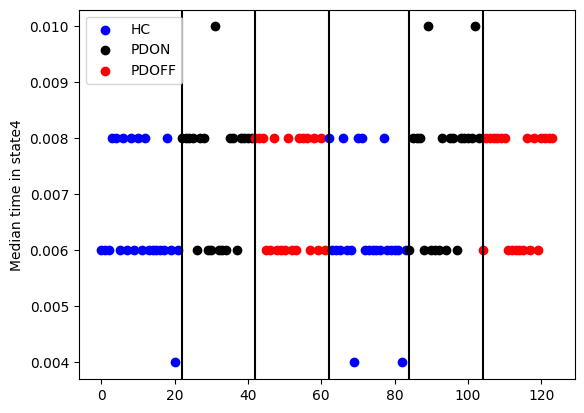

HC vs PDON: p=0.0180
HC vs PDOFF: p=0.1752
PDON vs PDOFF: p=0.2513
HC vs PD-COMB: p=0.2385
(GVS) HC vs PDON: p=0.0019
(GVS) HC vs PDOFF: p=0.0076
(GVS) PDON vs PDOFF: p=0.4143
(GVS) HC vs PD-COMB: p=0.0007
GVS- HC vs GVS+ HC: p=0.4200
GVS- PDON vs GVS+ PDON: p=0.7955
GVS- PDOFF GVS+ PDOFF: p=0.5372
GVS- vs GVS+: p=1.0000
###############################
Cross validation score for 3-class Mean meta-state component 1: 0.2253 ±0.0387
Cross validation score for 2-class Mean meta-state component 1: 0.6453 ±0.0107
HC mean: -0.0316 ± 0.0877
PDON mean: 0.0285 ± 0.0744
PDOFF mean: 0.0268 ± 0.1003
PD-COMB mean: 0.0192 ± 0.1029


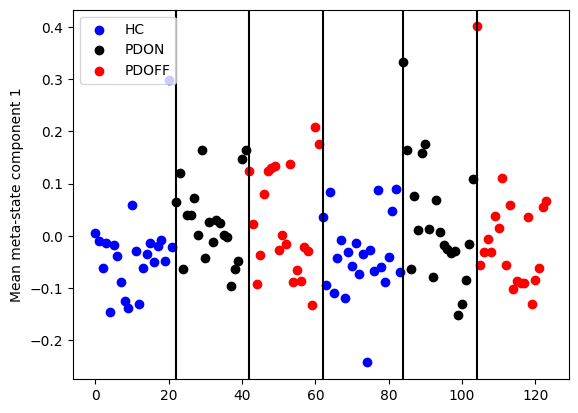

HC vs PDON: p=0.0254
HC vs PDOFF: p=0.0566
PDON vs PDOFF: p=0.9540
HC vs PD-COMB: p=0.3651
(GVS) HC vs PDON: p=0.0473
(GVS) HC vs PDOFF: p=0.2411
(GVS) PDON vs PDOFF: p=0.4795
(GVS) HC vs PD-COMB: p=0.0810
GVS- HC vs GVS+ HC: p=0.7889
GVS- PDON vs GVS+ PDON: p=0.8890
GVS- PDOFF GVS+ PDOFF: p=0.4054
GVS- vs GVS+: p=0.4615
###############################
Cross validation score for 3-class Mean meta-state component 2: 0.1617 ±0.0726
Cross validation score for 2-class Mean meta-state component 2: 0.6290 ±0.0156
HC mean: 0.0017 ± 0.0468
PDON mean: -0.0029 ± 0.0324
PDOFF mean: -0.0061 ± 0.0356
PD-COMB mean: -0.0055 ± 0.0396


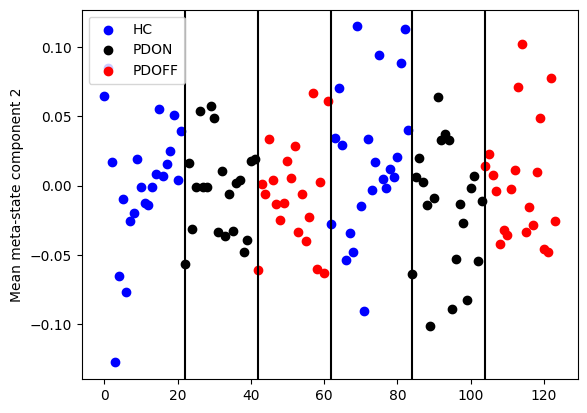

HC vs PDON: p=0.7237
HC vs PDOFF: p=0.5607
PDON vs PDOFF: p=0.7738
HC vs PD-COMB: p=0.8113
(GVS) HC vs PDON: p=0.0323
(GVS) HC vs PDOFF: p=0.3069
(GVS) PDON vs PDOFF: p=0.1948
(GVS) HC vs PD-COMB: p=0.0553
GVS- HC vs GVS+ HC: p=0.2834
GVS- PDON vs GVS+ PDON: p=0.3060
GVS- PDOFF GVS+ PDOFF: p=0.4973
GVS- vs GVS+: p=0.5732
###############################
Cross validation score for 3-class Mean meta-state component 3: 0.2017 ±0.0439
Cross validation score for 2-class Mean meta-state component 3: 0.6697 ±0.0365
HC mean: 0.0305 ± 0.0473
PDON mean: -0.0180 ± 0.0528
PDOFF mean: -0.0114 ± 0.0510
PD-COMB mean: -0.0166 ± 0.0535


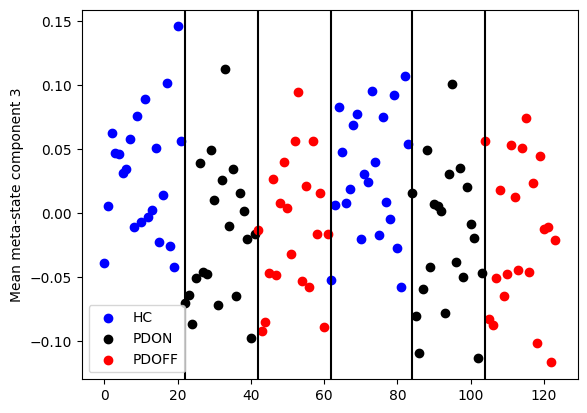

HC vs PDON: p=0.0039
HC vs PDOFF: p=0.0103
PDON vs PDOFF: p=0.6962
HC vs PD-COMB: p=0.4012
(GVS) HC vs PDON: p=0.0039
(GVS) HC vs PDOFF: p=0.0059
(GVS) PDON vs PDOFF: p=0.9426
(GVS) HC vs PD-COMB: p=0.0012
GVS- HC vs GVS+ HC: p=0.9635
GVS- PDON vs GVS+ PDON: p=0.9522
GVS- PDOFF GVS+ PDOFF: p=0.7162
GVS- vs GVS+: p=0.7958
###############################
Cross validation score for 3-class Mean meta-state component 4: 0.1530 ±0.0684
Cross validation score for 2-class Mean meta-state component 4: 0.7097 ±0.0155
HC mean: 0.0055 ± 0.0232
PDON mean: -0.0079 ± 0.0161
PDOFF mean: -0.0044 ± 0.0149
PD-COMB mean: -0.0042 ± 0.0187


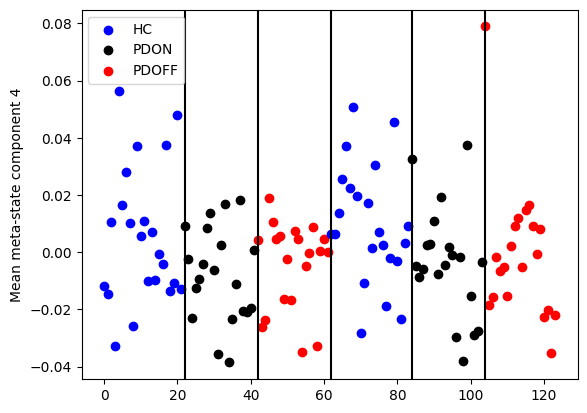

HC vs PDON: p=0.0415
HC vs PDOFF: p=0.1187
PDON vs PDOFF: p=0.4914
HC vs PD-COMB: p=0.1606
(GVS) HC vs PDON: p=0.0401
(GVS) HC vs PDOFF: p=0.1313
(GVS) PDON vs PDOFF: p=0.7047
(GVS) HC vs PD-COMB: p=0.0389
GVS- HC vs GVS+ HC: p=0.5418
GVS- PDON vs GVS+ PDON: p=0.4438
GVS- PDOFF GVS+ PDOFF: p=0.5797
GVS- vs GVS+: p=0.2817
###############################
Cross validation score for 3-class Mean meta-state component 5: 0.1130 ±0.0166
Cross validation score for 2-class Mean meta-state component 5: 0.6453 ±0.0107
HC mean: 0.0022 ± 0.0145
PDON mean: -0.0041 ± 0.0098
PDOFF mean: -0.0014 ± 0.0160
PD-COMB mean: -0.0007 ± 0.0132


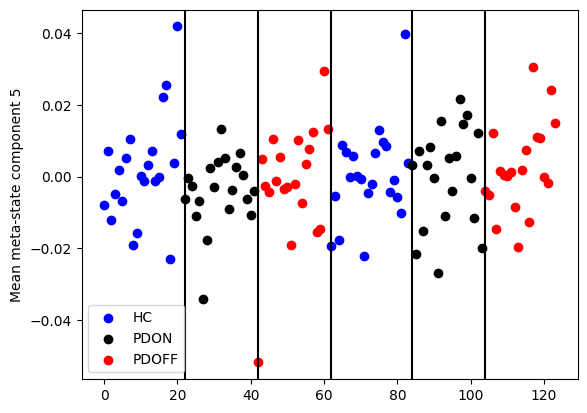

HC vs PDON: p=0.1233
HC vs PDOFF: p=0.4695
PDON vs PDOFF: p=0.5332
HC vs PD-COMB: p=0.2510
(GVS) HC vs PDON: p=0.9436
(GVS) HC vs PDOFF: p=0.6057
(GVS) PDON vs PDOFF: p=0.5779
(GVS) HC vs PD-COMB: p=0.8012
GVS- HC vs GVS+ HC: p=0.6804
GVS- PDON vs GVS+ PDON: p=0.2809
GVS- PDOFF GVS+ PDOFF: p=0.4114
GVS- vs GVS+: p=0.4194


In [8]:
# Labels we are interested in
y = full_combined_class

# We are interested in a binary class of whether or not they are HC or PD
# So: (HC classes) 0,3 -> 0 and (PD classes) 1,2,4,5 -> 1 
y_hcpd = np.sign(full_combined_class % 3)


# Normal features on downsized sequence
for f_,f in enumerate(feature_matrix.T):
    
    print("###############################")

    # Calculate cross validation scores
    mean, std = mod.compare_svm(f,y)
    mod.print_crossval(mean,std,len(np.unique(y)),"3-class "+feat_names[f_])

    mean, std = mod.compare_svm(f,y_hcpd)
    mod.print_crossval(mean,std,len(np.unique(y_hcpd)),"2-class "+feat_names[f_])

    
    # Print the means of this feature for each class set
    hcmean = np.mean(f[y==0]); hcstd = np.std(f[y==0])
    print(f'HC mean: {hcmean:.4f} ± {hcstd:.4f}')
    
    pdonmean = np.mean(f[y==1]); pdonstd = np.std(f[y==1])
    print(f'PDON mean: {pdonmean:.4f} ± {pdonstd:.4f}')

    pdoffmean = np.mean(f[y==2]); pdoffstd = np.std(f[y==2])
    print(f'PDOFF mean: {pdoffmean:.4f} ± {pdoffstd:.4f}')
    
    pdcombmean = np.mean(f[y_hcpd==1]); pdcombstd = np.std(f[y_hcpd==1])
    print(f'PD-COMB mean: {pdcombmean:.4f} ± {pdcombstd:.4f}')

    # Plot six classes of data, separated
    legend_names=["HC","PDON","PDOFF",None,None,None]
    label_names=["HC","PDON","PDOFF",None,None,None]
    mod.plot_classes_for_feat(f,y,feat_names[f_],legend_names,label_names)
  
    # Print t-test results for every interesting combination of classes
    ttest_comparisons = {
        "HC vs PDON": [y==0,y==1],
        "HC vs PDOFF": [y==0,y==2],
        "PDON vs PDOFF": [y==1,y==2],
        "HC vs PD-COMB": [y==1,y>0],

        "(GVS) HC vs PDON": [y==3,y==4],
        "(GVS) HC vs PDOFF": [y==3,y==5],
        "(GVS) PDON vs PDOFF": [y==4,y==5],
        "(GVS) HC vs PD-COMB": [y==3,np.logical_or(y==4,y==5)],
        
        "GVS- HC vs GVS+ HC": [y==0,y==3],
        "GVS- PDON vs GVS+ PDON": [y==1,y==4],
        "GVS- PDOFF GVS+ PDOFF": [y==2,y==5],
        "GVS- vs GVS+": [y<3,y>=3],
    }
    for test_name in ttest_comparisons:
        mod.display_ttest(f,ttest_comparisons[test_name][0],ttest_comparisons[test_name][1],test_name)



## 6) GVS Linear Model Prediction

- Using a linear model, we attempt to see if there is a relationship between our extracted features and the amount by which a feature improves


"['Grip Strength'] 0"

SKIPPED. downsized-geoTest for Map0
SKIPPED. downsized-geoTest for Map1
SKIPPED. downsized-geoTest for Map2
SKIPPED. downsized-geoTest for Map3
SKIPPED. downsized-conditional homogeneity


"['Grip Strength'] 1"

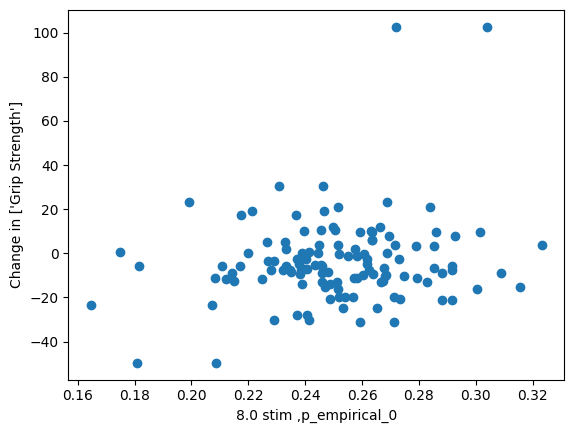

"['Grip Strength'], 8.0 stim ,p_empirical_0 --- --- --- 0.0419, 0.0471"

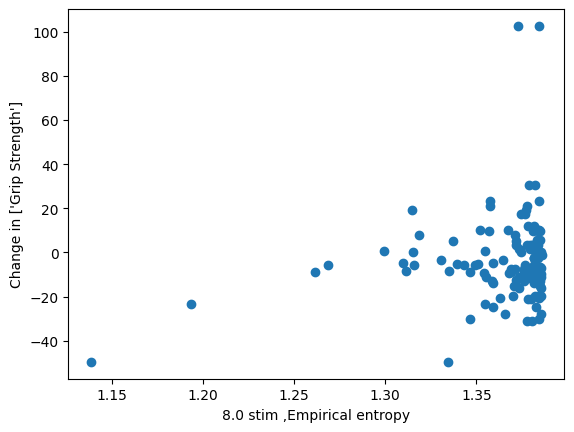

"['Grip Strength'], 8.0 stim ,Empirical entropy --- --- --- 0.0165, 0.0182"

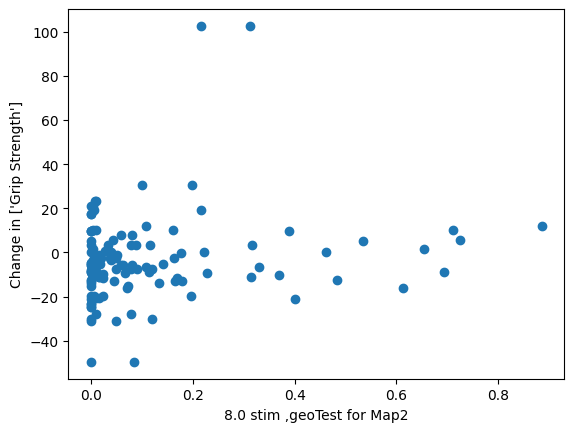

"['Grip Strength'], 8.0 stim ,geoTest for Map2 --- --- --- 0.3780, 0.0492"

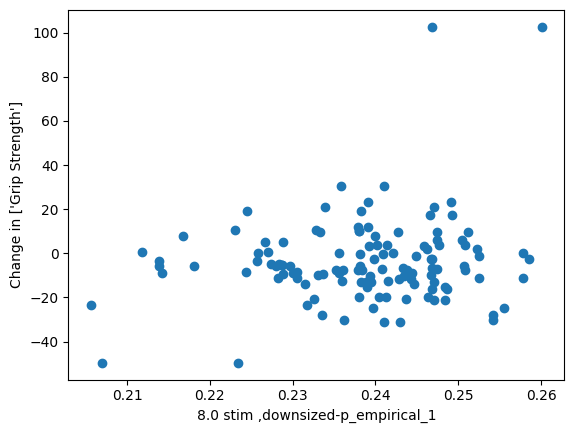

"['Grip Strength'], 8.0 stim ,downsized-p_empirical_1 --- --- --- 0.0264, 0.0302"

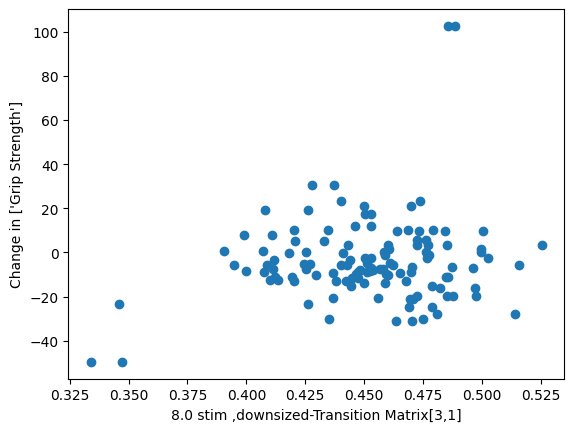

"['Grip Strength'], 8.0 stim ,downsized-Transition Matrix[3,1] --- --- --- 0.0319, 0.0364"

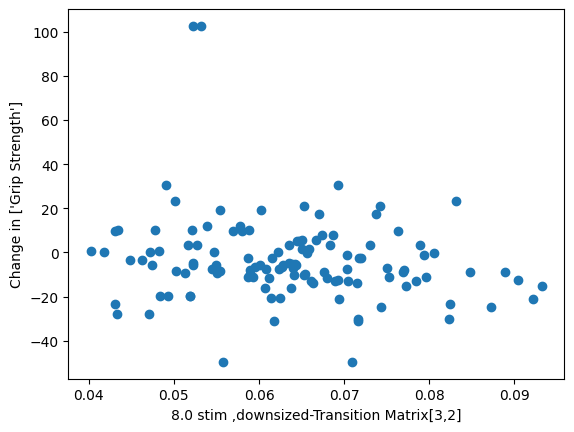

"['Grip Strength'], 8.0 stim ,downsized-Transition Matrix[3,2] --- --- --- 0.1242, 0.0275"

SKIPPED. downsized-geoTest for Map0
SKIPPED. downsized-geoTest for Map1
SKIPPED. downsized-geoTest for Map2
SKIPPED. downsized-geoTest for Map3
SKIPPED. downsized-conditional homogeneity


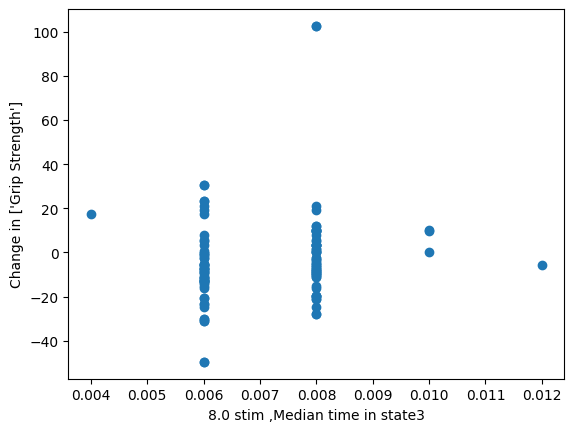

"['Grip Strength'], 8.0 stim ,Median time in state3 --- --- --- 0.0410, 0.0366"

"['Strength Velocity'] 2"

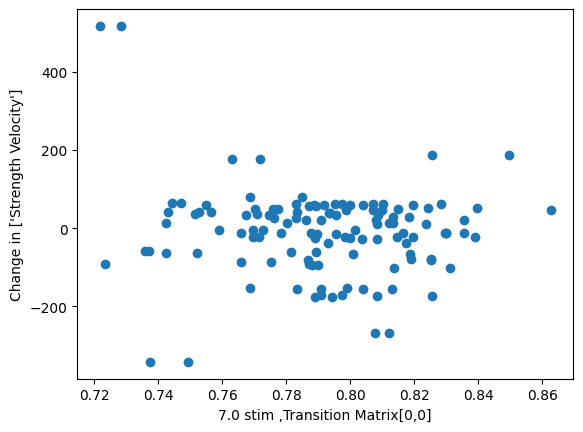

"['Strength Velocity'], 7.0 stim ,Transition Matrix[0,0] --- --- --- 0.0290, 0.0349"

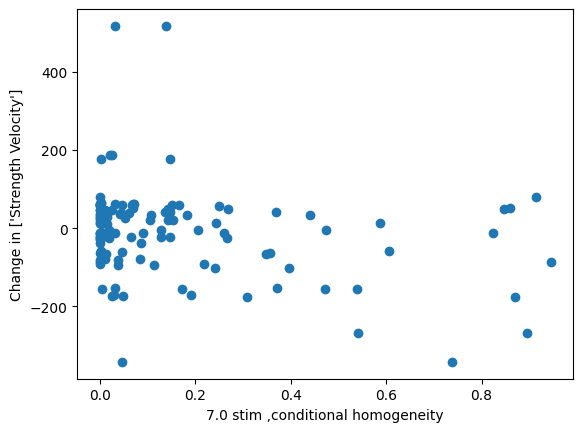

"['Strength Velocity'], 7.0 stim ,conditional homogeneity --- --- --- 0.4080, 0.0033"

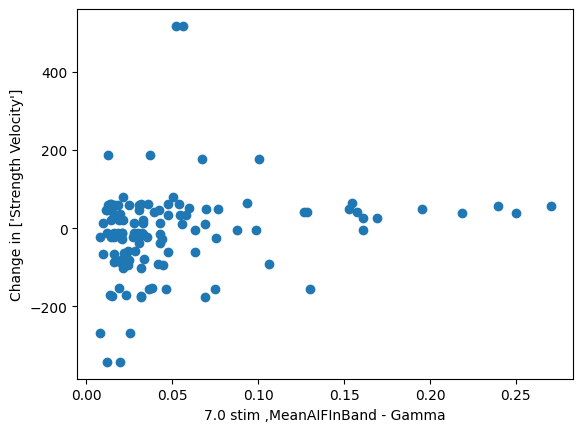

"['Strength Velocity'], 7.0 stim ,MeanAIFInBand - Gamma --- --- --- 0.0392, 0.0334"

SKIPPED. downsized-geoTest for Map0
SKIPPED. downsized-geoTest for Map1
SKIPPED. downsized-geoTest for Map2
SKIPPED. downsized-geoTest for Map3
SKIPPED. downsized-conditional homogeneity


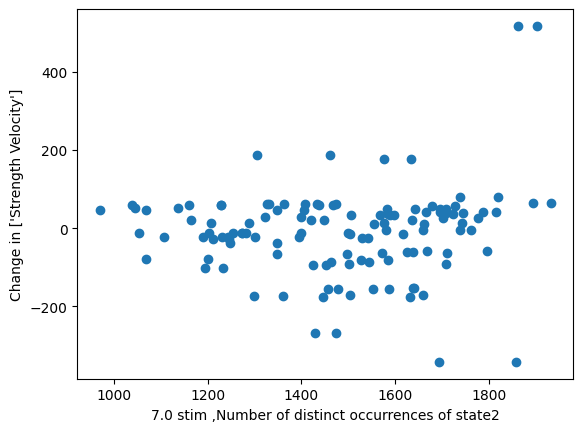

"['Strength Velocity'], 7.0 stim ,Number of distinct occurrences of state2 --- --- --- 0.0403, 0.0001"

"['Strength Velocity'] 3"

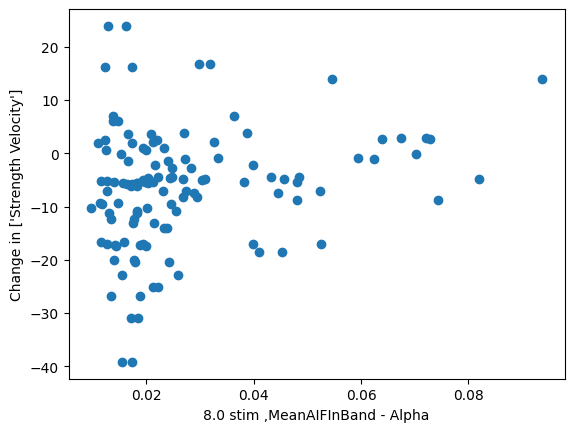

"['Strength Velocity'], 8.0 stim ,MeanAIFInBand - Alpha --- --- --- 1.0000, 0.0274"

SKIPPED. downsized-geoTest for Map0
SKIPPED. downsized-geoTest for Map1
SKIPPED. downsized-geoTest for Map2
SKIPPED. downsized-geoTest for Map3
SKIPPED. downsized-conditional homogeneity


"['Movement Time (ms)'] 4"

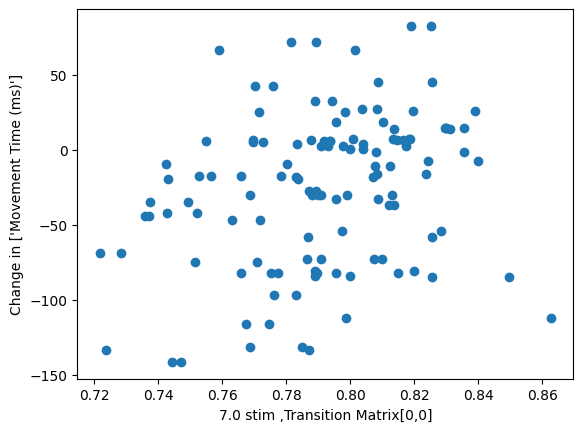

"['Movement Time (ms)'], 7.0 stim ,Transition Matrix[0,0] --- --- --- 0.0007, 0.0014"

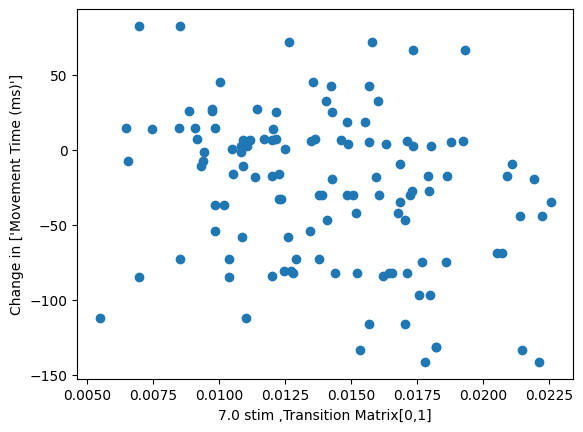

"['Movement Time (ms)'], 7.0 stim ,Transition Matrix[0,1] --- --- --- 1.0000, 0.0008"

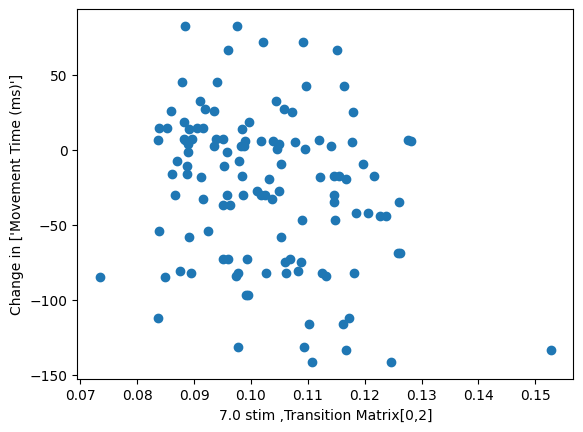

"['Movement Time (ms)'], 7.0 stim ,Transition Matrix[0,2] --- --- --- 0.0477, 0.0067"

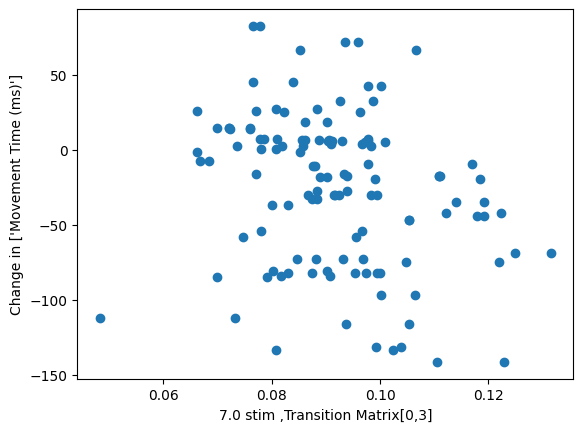

"['Movement Time (ms)'], 7.0 stim ,Transition Matrix[0,3] --- --- --- 0.0500, 0.0037"

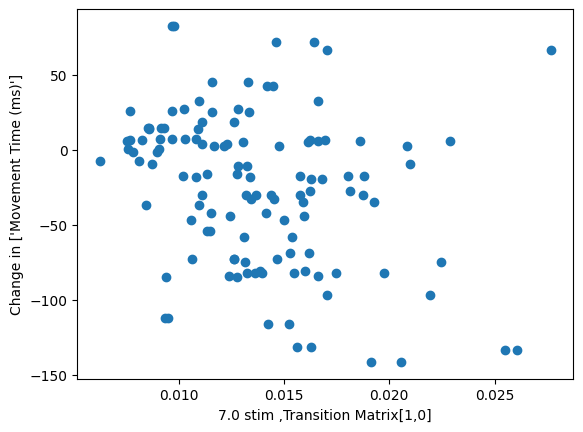

"['Movement Time (ms)'], 7.0 stim ,Transition Matrix[1,0] --- --- --- 0.1005, 0.0005"

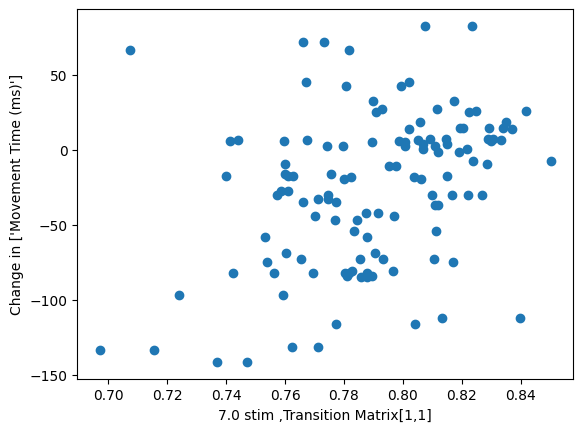

"['Movement Time (ms)'], 7.0 stim ,Transition Matrix[1,1] --- --- --- 0.0000, 0.0000"

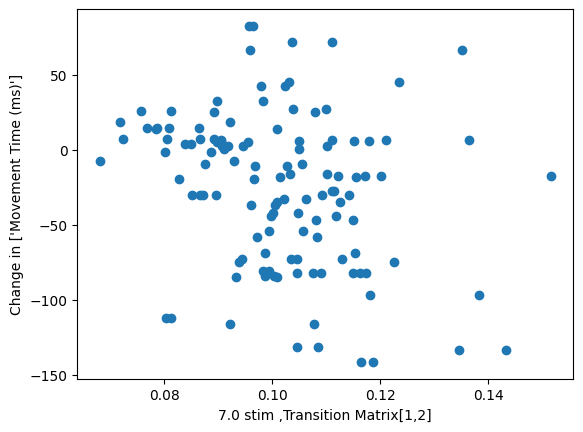

"['Movement Time (ms)'], 7.0 stim ,Transition Matrix[1,2] --- --- --- 0.0217, 0.0015"

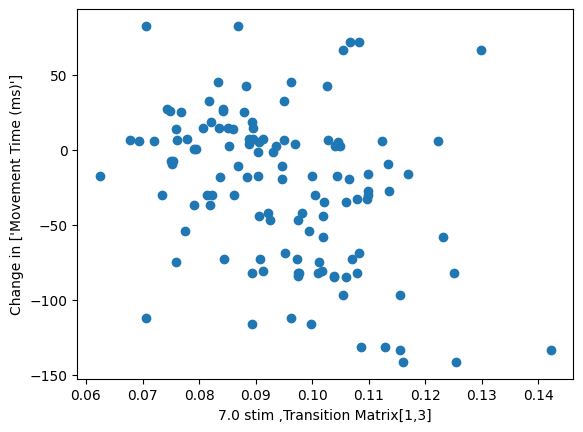

"['Movement Time (ms)'], 7.0 stim ,Transition Matrix[1,3] --- --- --- 0.0003, 0.0000"

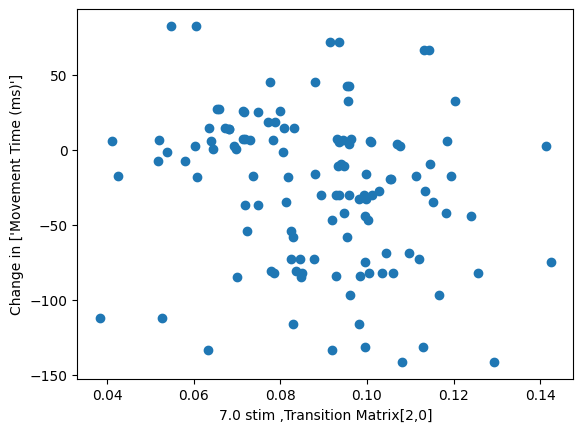

"['Movement Time (ms)'], 7.0 stim ,Transition Matrix[2,0] --- --- --- 0.3202, 0.0198"

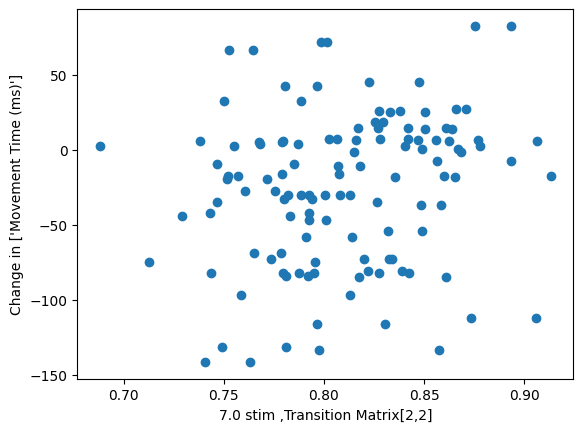

"['Movement Time (ms)'], 7.0 stim ,Transition Matrix[2,2] --- --- --- 0.0214, 0.0457"

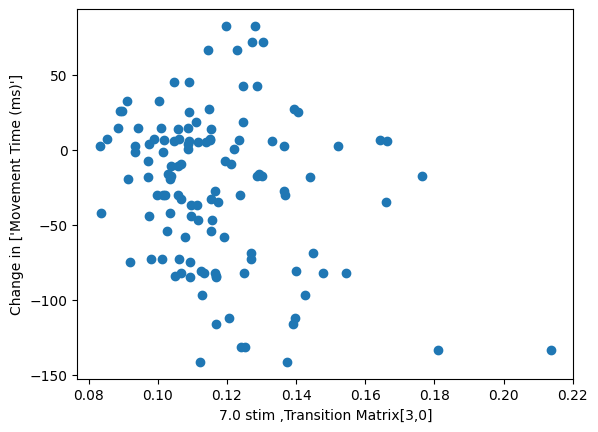

"['Movement Time (ms)'], 7.0 stim ,Transition Matrix[3,0] --- --- --- 0.0829, 0.0056"

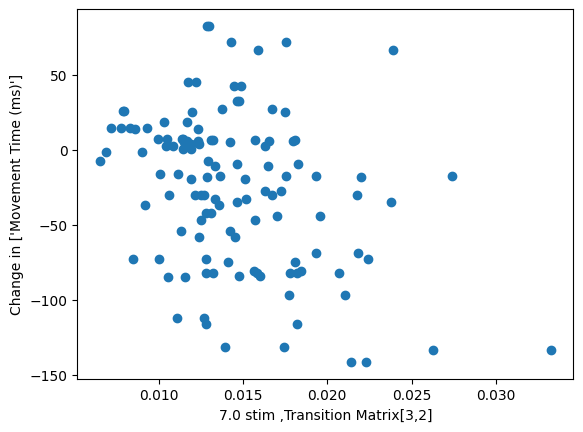

"['Movement Time (ms)'], 7.0 stim ,Transition Matrix[3,2] --- --- --- 0.0276, 0.0000"

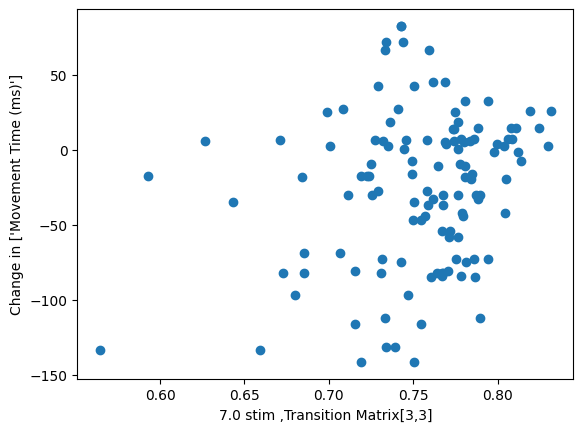

"['Movement Time (ms)'], 7.0 stim ,Transition Matrix[3,3] --- --- --- 0.0030, 0.0082"

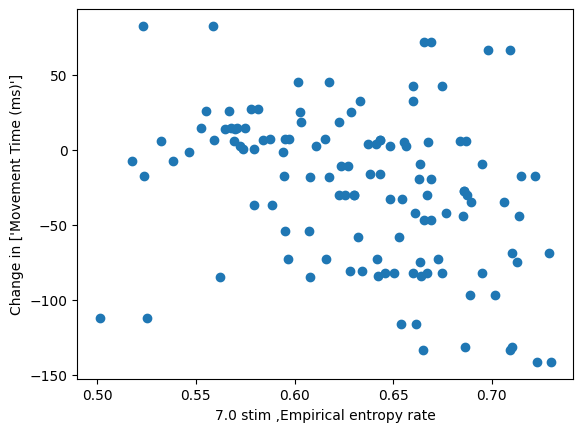

"['Movement Time (ms)'], 7.0 stim ,Empirical entropy rate --- --- --- 0.0000, 0.0000"

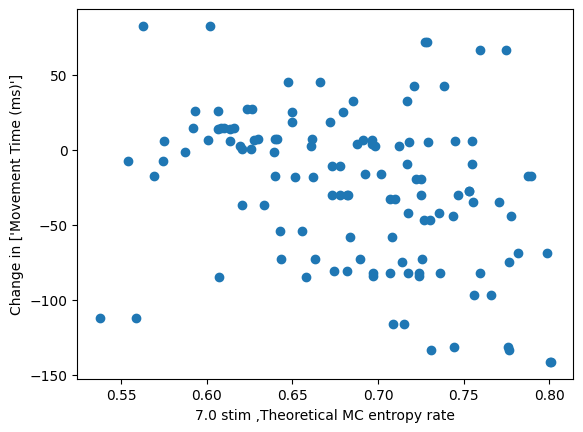

"['Movement Time (ms)'], 7.0 stim ,Theoretical MC entropy rate --- --- --- 0.0000, 0.0000"

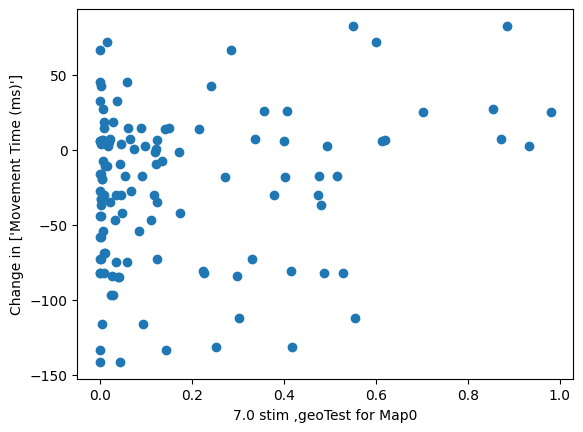

"['Movement Time (ms)'], 7.0 stim ,geoTest for Map0 --- --- --- 0.0000, 0.0290"

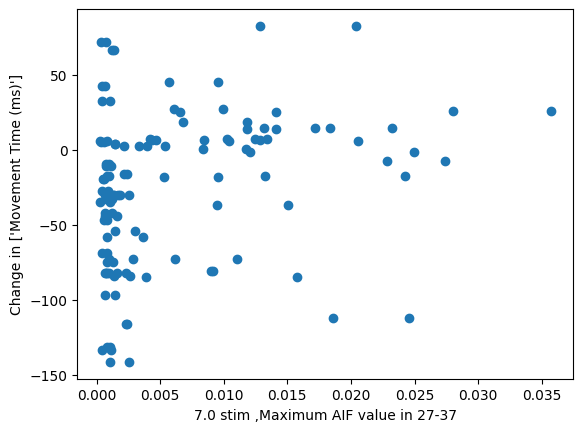

"['Movement Time (ms)'], 7.0 stim ,Maximum AIF value in 27-37 --- --- --- 0.0000, 0.0021"

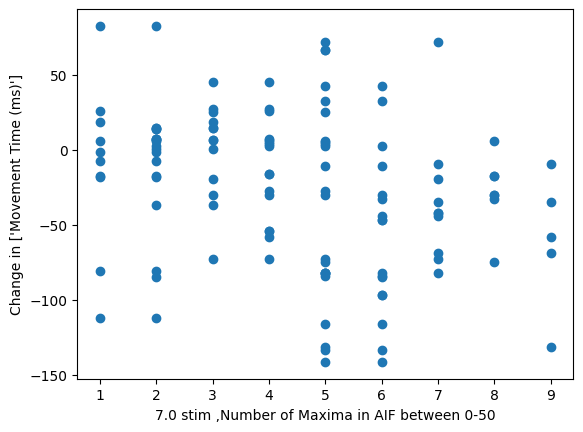

"['Movement Time (ms)'], 7.0 stim ,Number of Maxima in AIF between 0-50 --- --- --- 0.6011, 0.0003"

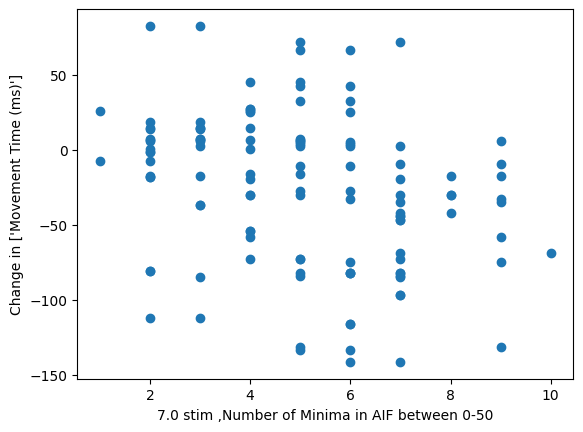

"['Movement Time (ms)'], 7.0 stim ,Number of Minima in AIF between 0-50 --- --- --- 0.1369, 0.0000"

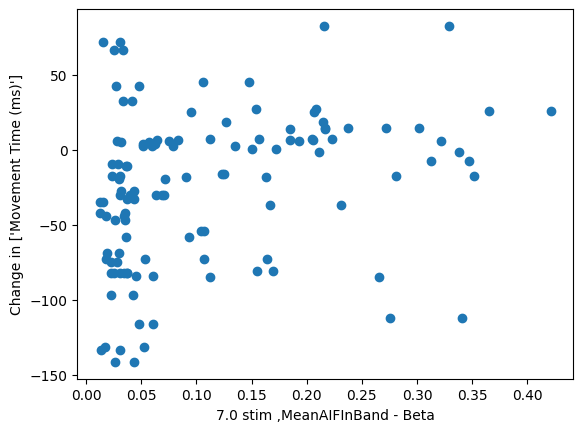

"['Movement Time (ms)'], 7.0 stim ,MeanAIFInBand - Beta --- --- --- 0.0000, 0.0004"

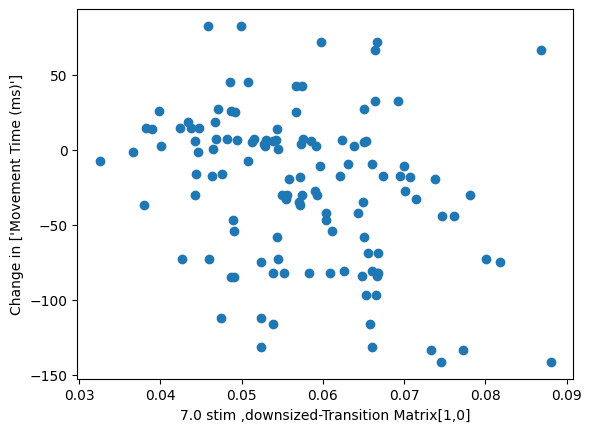

"['Movement Time (ms)'], 7.0 stim ,downsized-Transition Matrix[1,0] --- --- --- 0.0182, 0.0005"

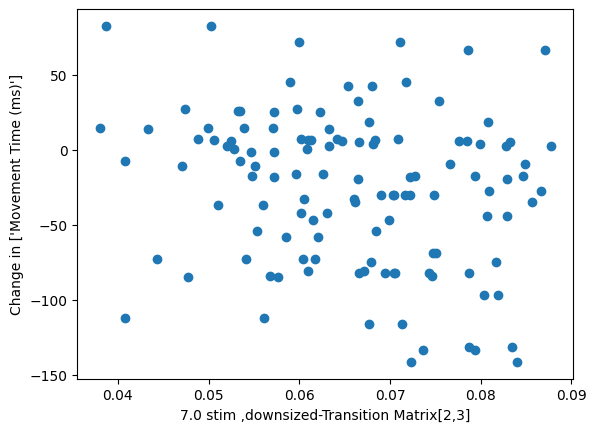

"['Movement Time (ms)'], 7.0 stim ,downsized-Transition Matrix[2,3] --- --- --- 0.1726, 0.0161"

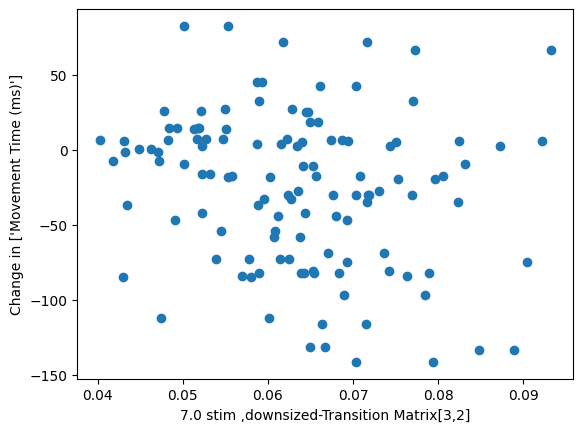

"['Movement Time (ms)'], 7.0 stim ,downsized-Transition Matrix[3,2] --- --- --- 0.2359, 0.0252"

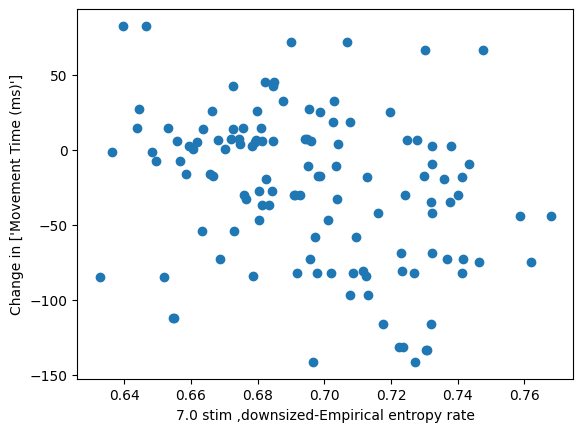

"['Movement Time (ms)'], 7.0 stim ,downsized-Empirical entropy rate --- --- --- 0.0009, 0.0004"

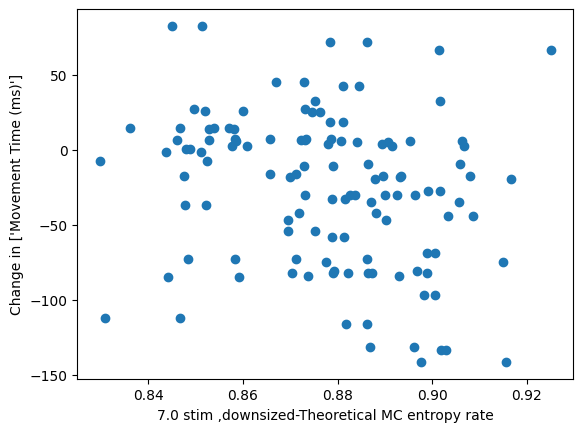

"['Movement Time (ms)'], 7.0 stim ,downsized-Theoretical MC entropy rate --- --- --- 0.0128, 0.0088"

SKIPPED. downsized-geoTest for Map0
SKIPPED. downsized-geoTest for Map1
SKIPPED. downsized-geoTest for Map2
SKIPPED. downsized-geoTest for Map3
SKIPPED. downsized-conditional homogeneity


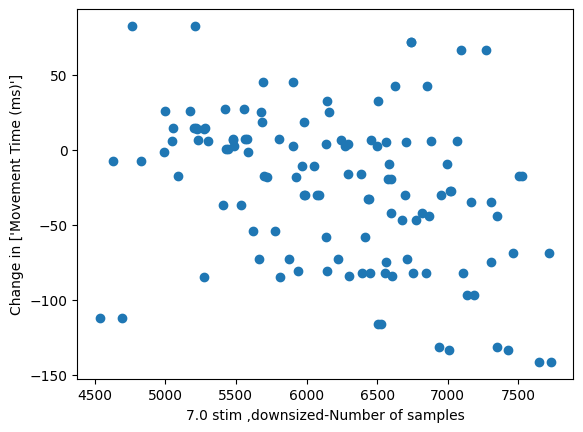

"['Movement Time (ms)'], 7.0 stim ,downsized-Number of samples --- --- --- 0.0173, 0.0033"

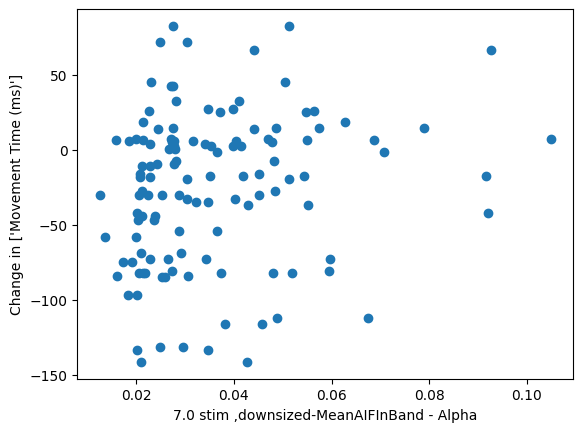

"['Movement Time (ms)'], 7.0 stim ,downsized-MeanAIFInBand - Alpha --- --- --- 0.0000, 0.0465"

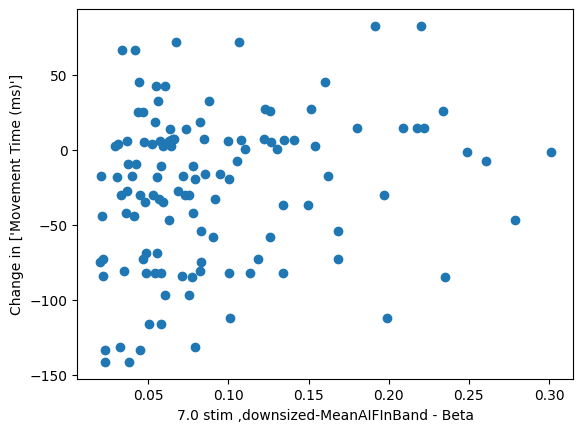

"['Movement Time (ms)'], 7.0 stim ,downsized-MeanAIFInBand - Beta --- --- --- 0.0000, 0.0210"

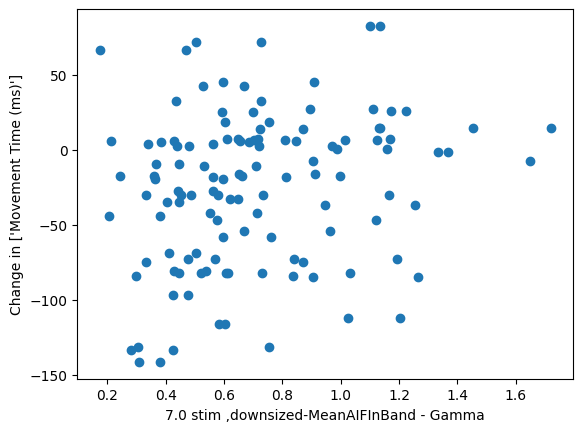

"['Movement Time (ms)'], 7.0 stim ,downsized-MeanAIFInBand - Gamma --- --- --- 0.0000, 0.0152"

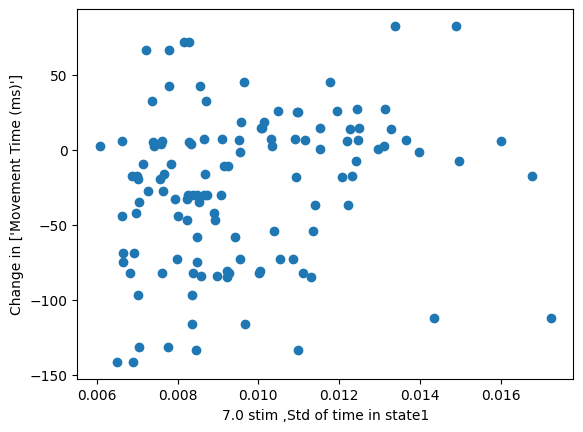

"['Movement Time (ms)'], 7.0 stim ,Std of time in state1 --- --- --- 0.0003, 0.0201"

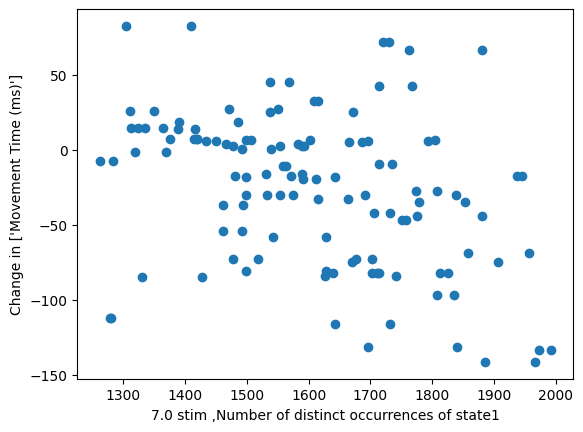

"['Movement Time (ms)'], 7.0 stim ,Number of distinct occurrences of state1 --- --- --- 0.0000, 0.0000"

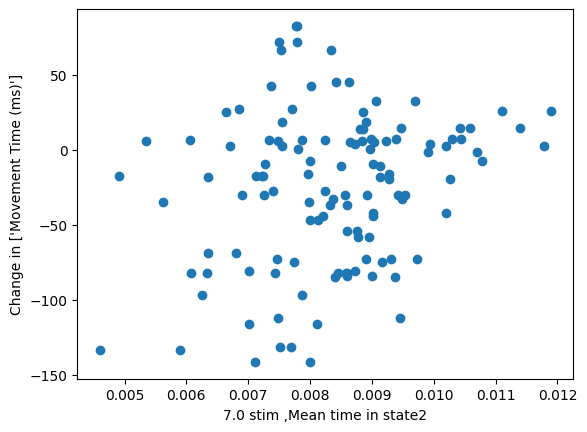

"['Movement Time (ms)'], 7.0 stim ,Mean time in state2 --- --- --- 0.0004, 0.0075"

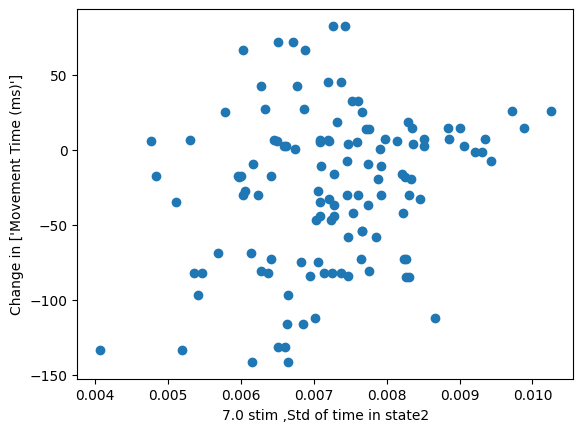

"['Movement Time (ms)'], 7.0 stim ,Std of time in state2 --- --- --- 0.0003, 0.0051"

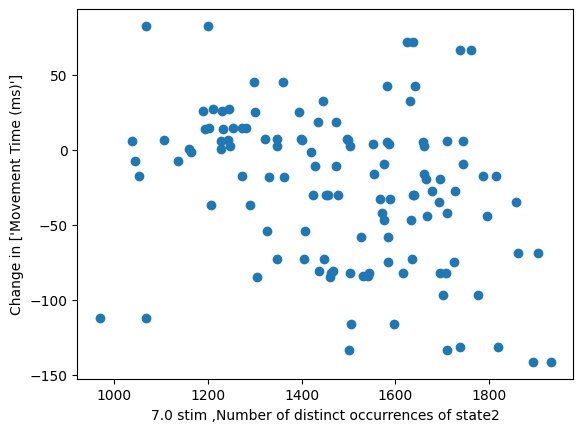

"['Movement Time (ms)'], 7.0 stim ,Number of distinct occurrences of state2 --- --- --- 0.0000, 0.0000"

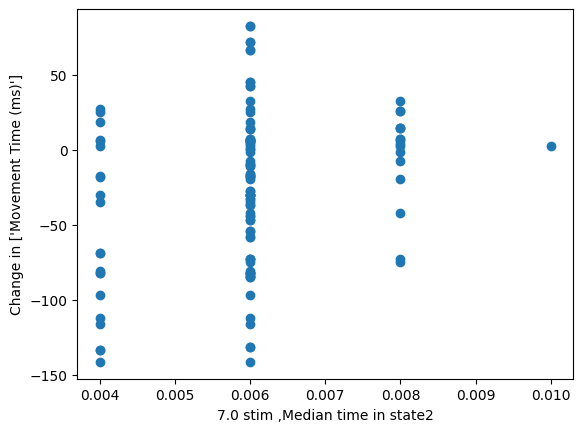

"['Movement Time (ms)'], 7.0 stim ,Median time in state2 --- --- --- 0.0000, 0.0013"

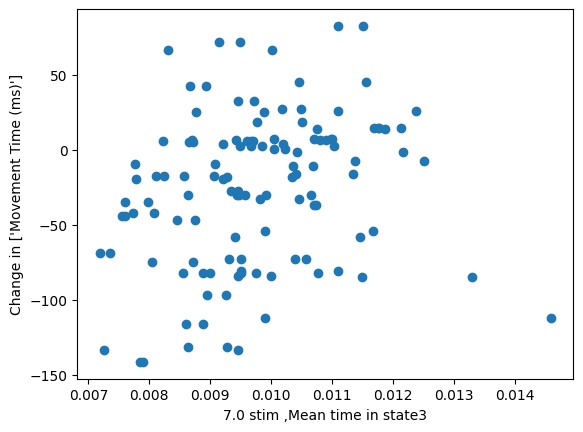

"['Movement Time (ms)'], 7.0 stim ,Mean time in state3 --- --- --- 0.0006, 0.0072"

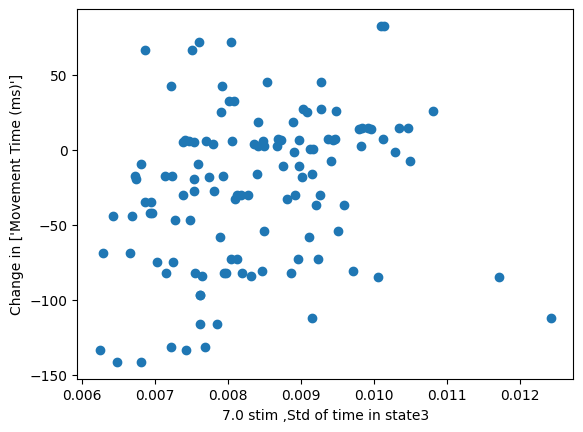

"['Movement Time (ms)'], 7.0 stim ,Std of time in state3 --- --- --- 0.0004, 0.0052"

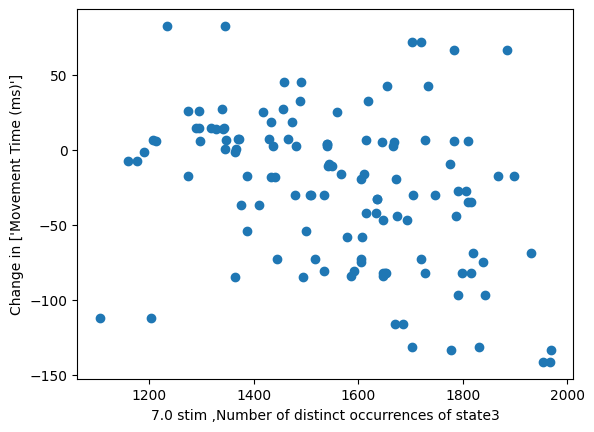

"['Movement Time (ms)'], 7.0 stim ,Number of distinct occurrences of state3 --- --- --- 0.0156, 0.0024"

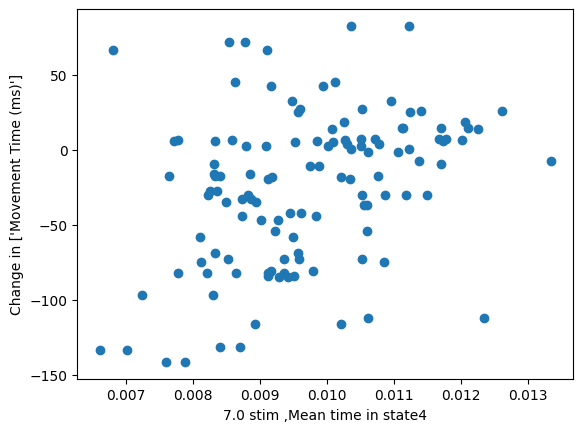

"['Movement Time (ms)'], 7.0 stim ,Mean time in state4 --- --- --- 0.0000, 0.0000"

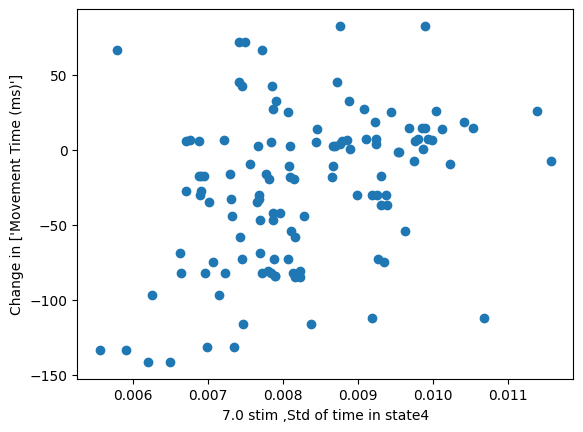

"['Movement Time (ms)'], 7.0 stim ,Std of time in state4 --- --- --- 0.0000, 0.0000"

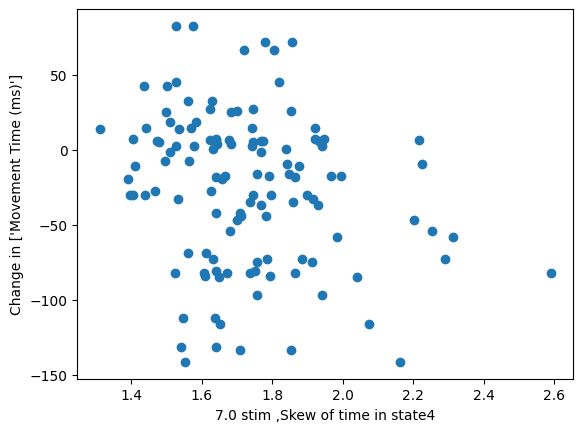

"['Movement Time (ms)'], 7.0 stim ,Skew of time in state4 --- --- --- 0.0819, 0.0137"

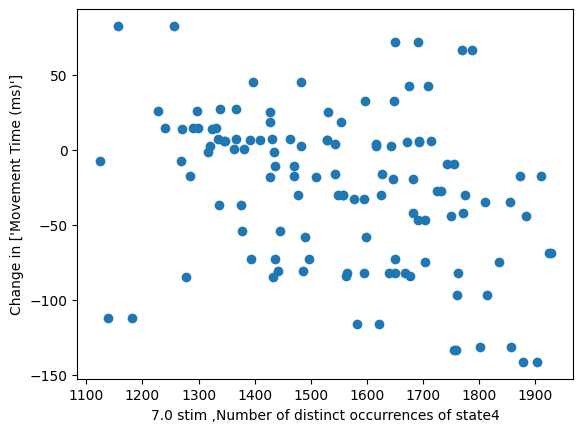

"['Movement Time (ms)'], 7.0 stim ,Number of distinct occurrences of state4 --- --- --- 1.0000, 0.0000"

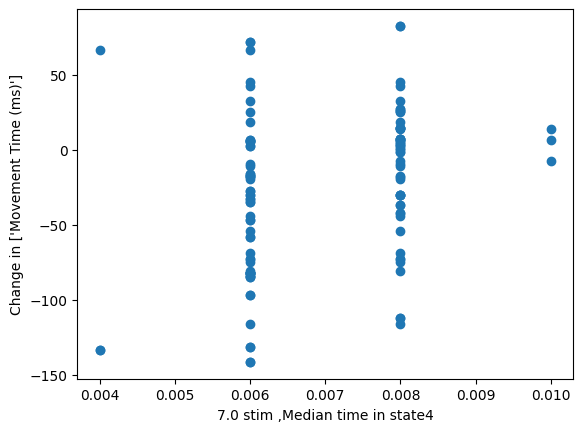

"['Movement Time (ms)'], 7.0 stim ,Median time in state4 --- --- --- 0.0000, 0.0005"

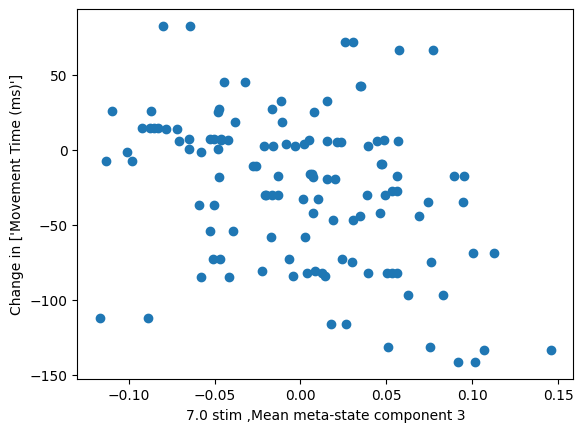

"['Movement Time (ms)'], 7.0 stim ,Mean meta-state component 3 --- --- --- 0.0000, 0.0000"

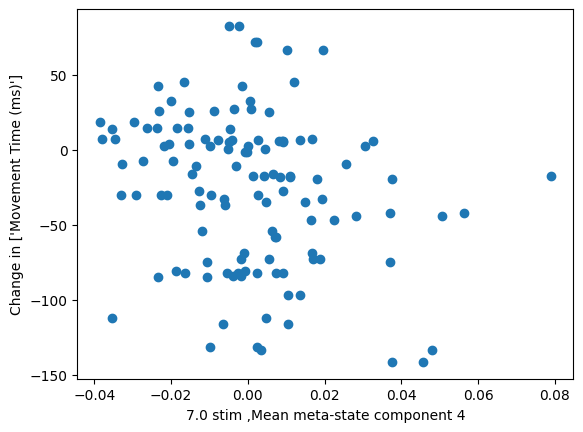

"['Movement Time (ms)'], 7.0 stim ,Mean meta-state component 4 --- --- --- 0.0000, 0.0075"

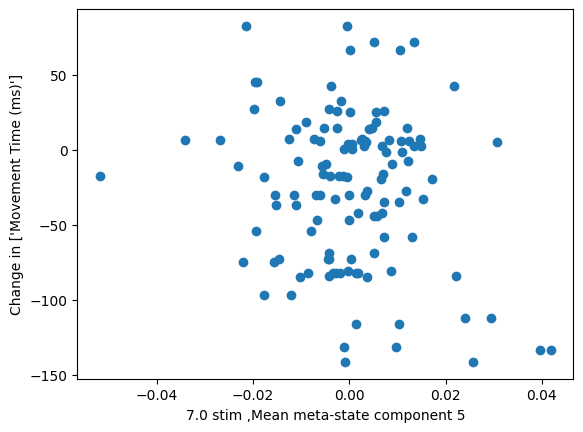

"['Movement Time (ms)'], 7.0 stim ,Mean meta-state component 5 --- --- --- 0.0000, 0.0369"

"['Movement Time (ms)'] 5"

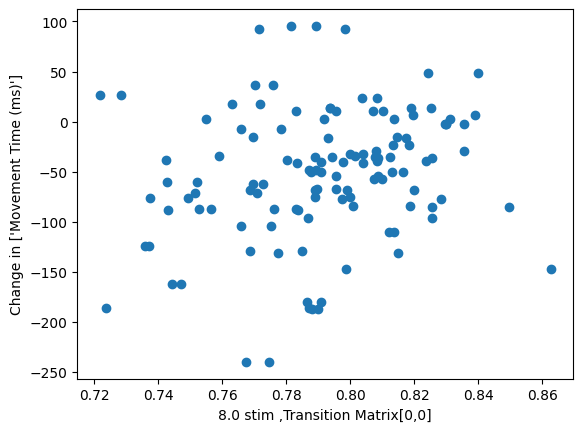

"['Movement Time (ms)'], 8.0 stim ,Transition Matrix[0,0] --- --- --- 0.0083, 0.0203"

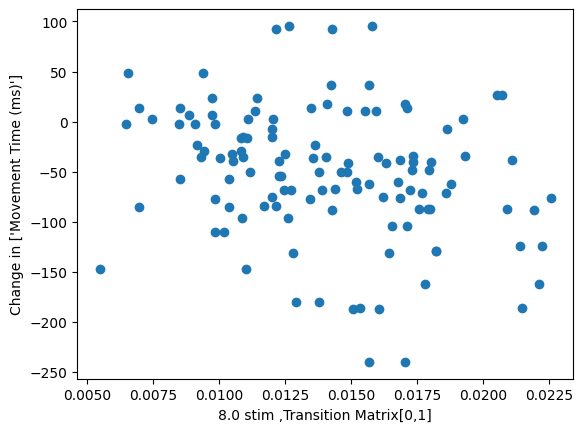

"['Movement Time (ms)'], 8.0 stim ,Transition Matrix[0,1] --- --- --- 0.8762, 0.0013"

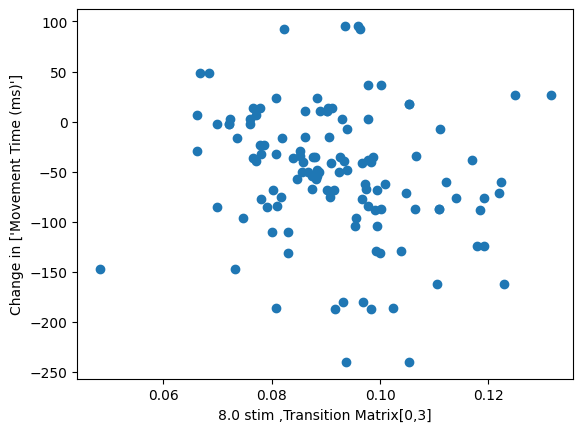

"['Movement Time (ms)'], 8.0 stim ,Transition Matrix[0,3] --- --- --- 0.5601, 0.0325"

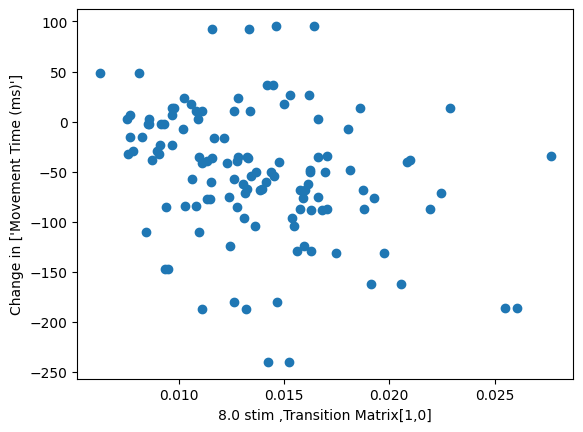

"['Movement Time (ms)'], 8.0 stim ,Transition Matrix[1,0] --- --- --- 0.5213, 0.0007"

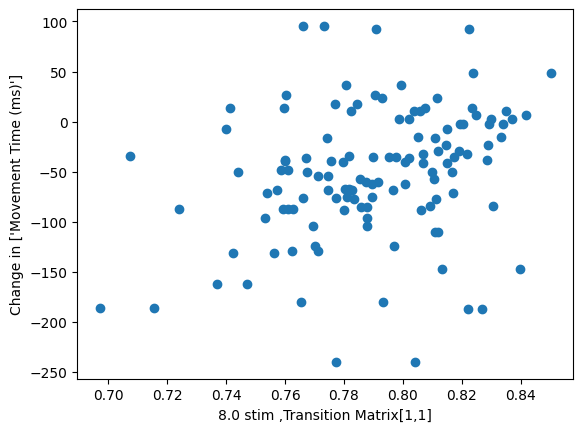

"['Movement Time (ms)'], 8.0 stim ,Transition Matrix[1,1] --- --- --- 0.0003, 0.0012"

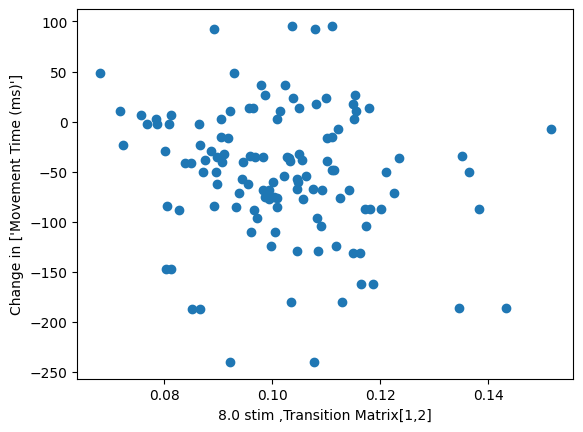

"['Movement Time (ms)'], 8.0 stim ,Transition Matrix[1,2] --- --- --- 0.4865, 0.0454"

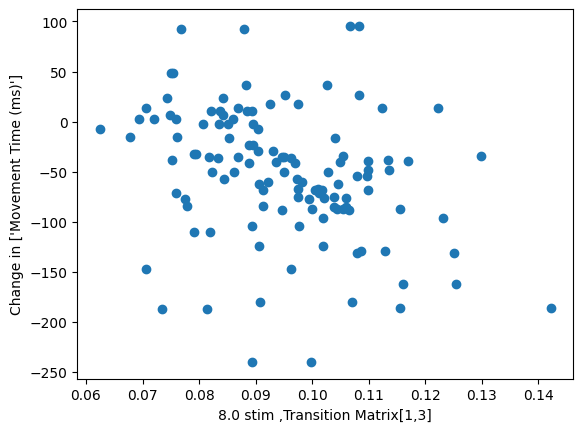

"['Movement Time (ms)'], 8.0 stim ,Transition Matrix[1,3] --- --- --- 0.0361, 0.0004"

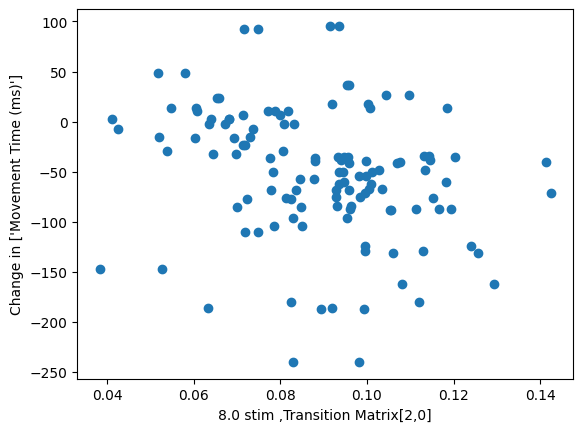

"['Movement Time (ms)'], 8.0 stim ,Transition Matrix[2,0] --- --- --- 0.3433, 0.0021"

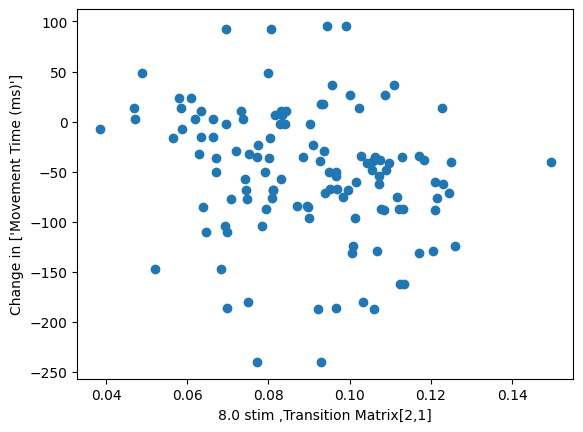

"['Movement Time (ms)'], 8.0 stim ,Transition Matrix[2,1] --- --- --- 0.9772, 0.0170"

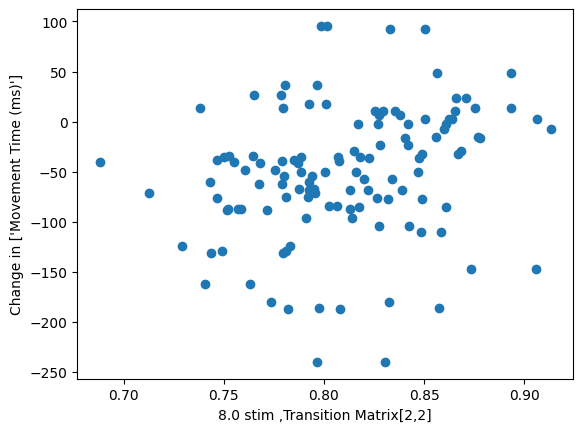

"['Movement Time (ms)'], 8.0 stim ,Transition Matrix[2,2] --- --- --- 0.0012, 0.0061"

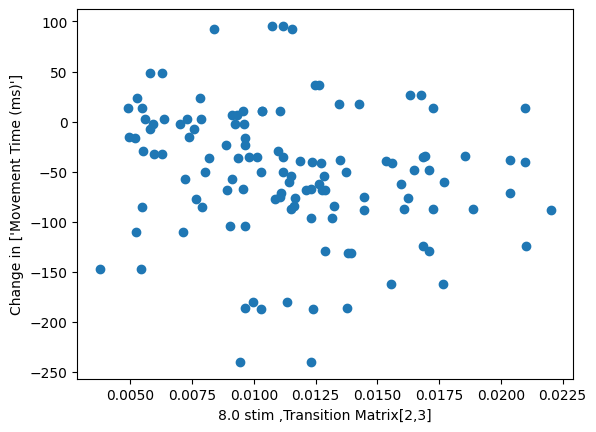

"['Movement Time (ms)'], 8.0 stim ,Transition Matrix[2,3] --- --- --- 0.2559, 0.0439"

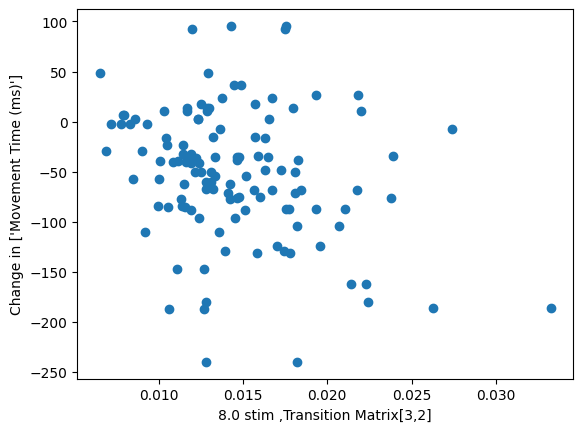

"['Movement Time (ms)'], 8.0 stim ,Transition Matrix[3,2] --- --- --- 0.7701, 0.0023"

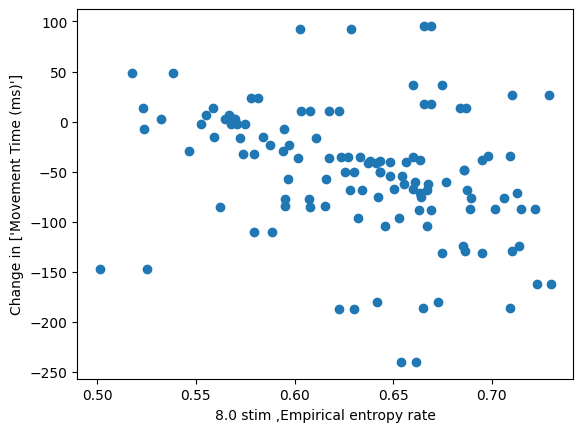

"['Movement Time (ms)'], 8.0 stim ,Empirical entropy rate --- --- --- 0.0025, 0.0001"

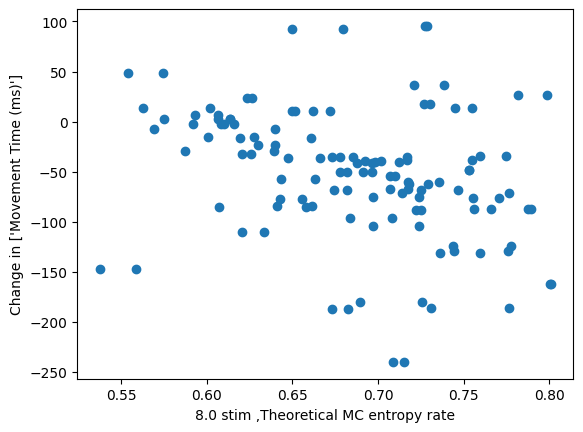

"['Movement Time (ms)'], 8.0 stim ,Theoretical MC entropy rate --- --- --- 0.0053, 0.0002"

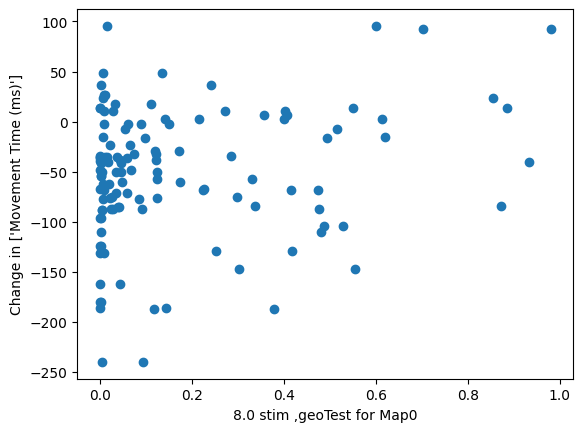

"['Movement Time (ms)'], 8.0 stim ,geoTest for Map0 --- --- --- 0.0000, 0.0217"

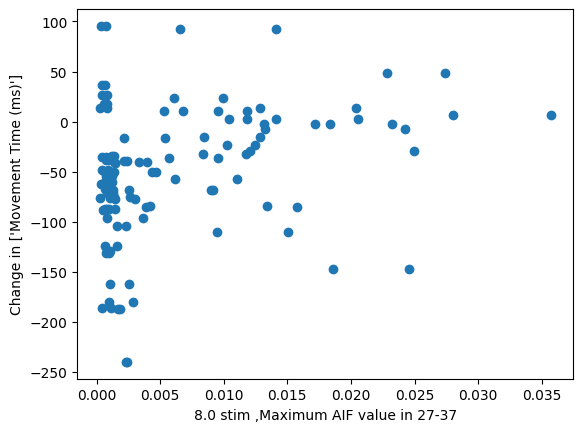

"['Movement Time (ms)'], 8.0 stim ,Maximum AIF value in 27-37 --- --- --- 0.0000, 0.0001"

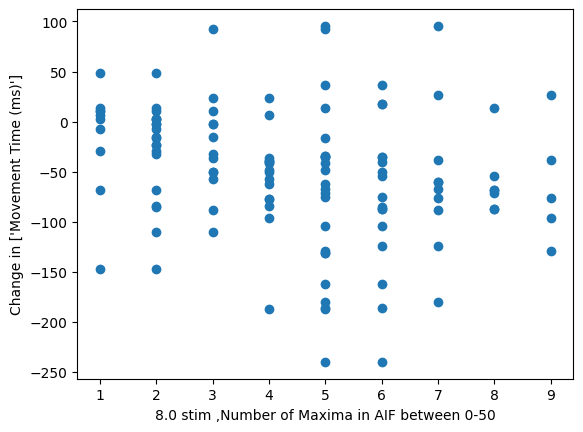

"['Movement Time (ms)'], 8.0 stim ,Number of Maxima in AIF between 0-50 --- --- --- 0.1804, 0.0032"

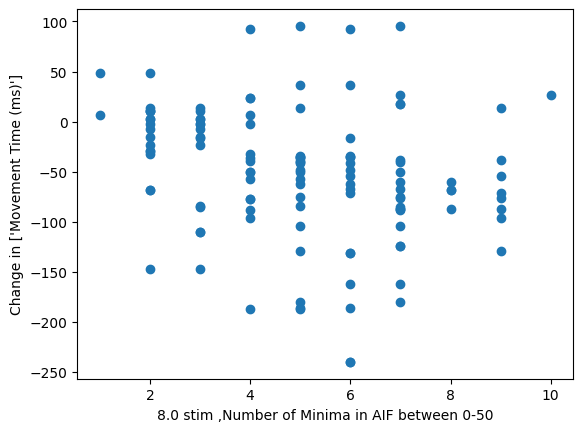

"['Movement Time (ms)'], 8.0 stim ,Number of Minima in AIF between 0-50 --- --- --- 0.3828, 0.0026"

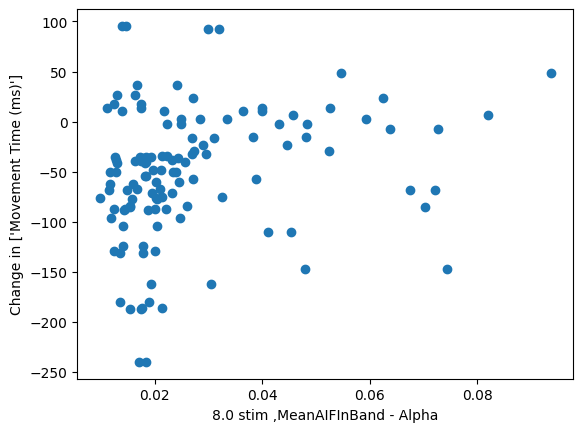

"['Movement Time (ms)'], 8.0 stim ,MeanAIFInBand - Alpha --- --- --- 0.0000, 0.0116"

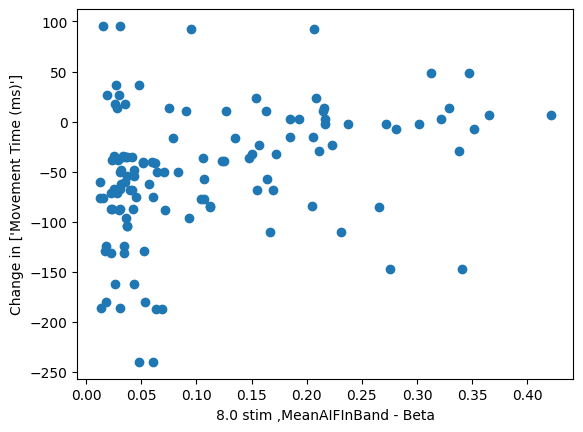

"['Movement Time (ms)'], 8.0 stim ,MeanAIFInBand - Beta --- --- --- nan, 0.0000"

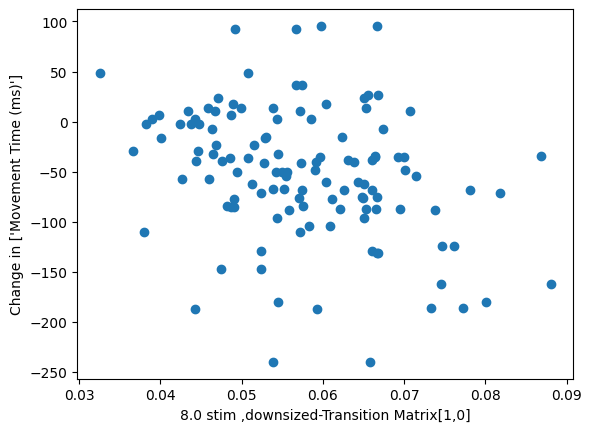

"['Movement Time (ms)'], 8.0 stim ,downsized-Transition Matrix[1,0] --- --- --- 0.0955, 0.0003"

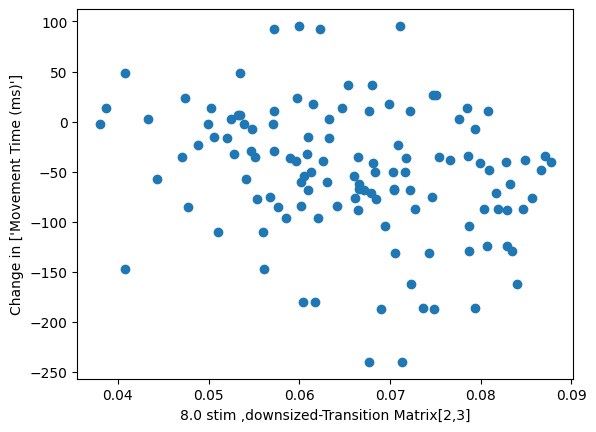

"['Movement Time (ms)'], 8.0 stim ,downsized-Transition Matrix[2,3] --- --- --- 0.4388, 0.0012"

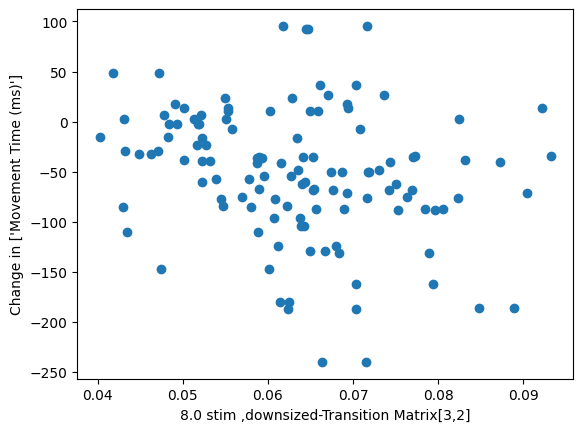

"['Movement Time (ms)'], 8.0 stim ,downsized-Transition Matrix[3,2] --- --- --- 0.2679, 0.0058"

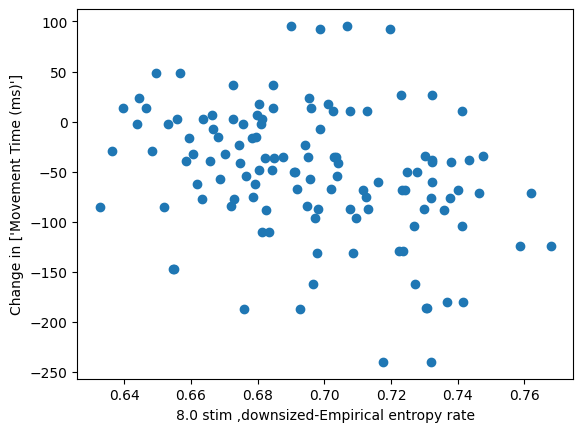

"['Movement Time (ms)'], 8.0 stim ,downsized-Empirical entropy rate --- --- --- 0.0020, 0.0004"

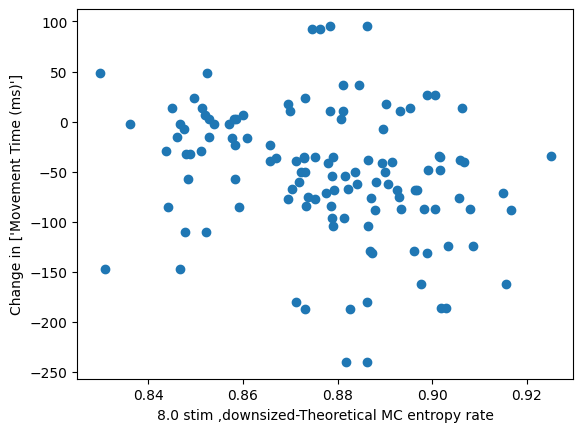

"['Movement Time (ms)'], 8.0 stim ,downsized-Theoretical MC entropy rate --- --- --- 0.0069, 0.0036"

SKIPPED. downsized-geoTest for Map0
SKIPPED. downsized-geoTest for Map1
SKIPPED. downsized-geoTest for Map2
SKIPPED. downsized-geoTest for Map3
SKIPPED. downsized-conditional homogeneity


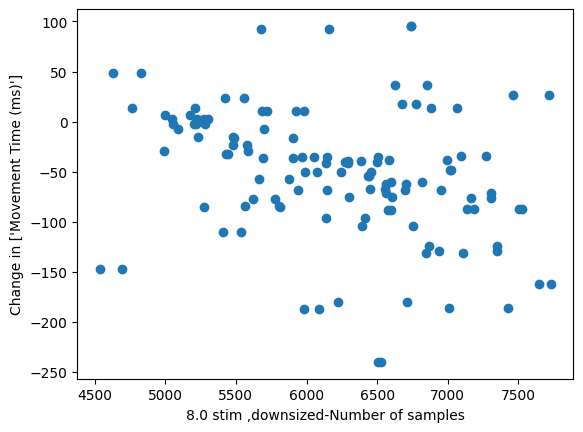

"['Movement Time (ms)'], 8.0 stim ,downsized-Number of samples --- --- --- 0.0082, 0.0000"

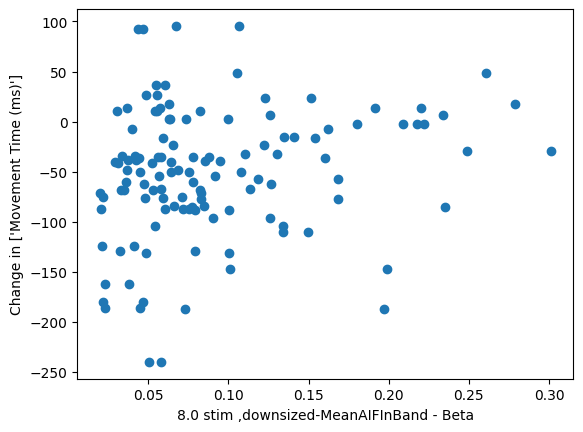

"['Movement Time (ms)'], 8.0 stim ,downsized-MeanAIFInBand - Beta --- --- --- 0.0000, 0.0232"

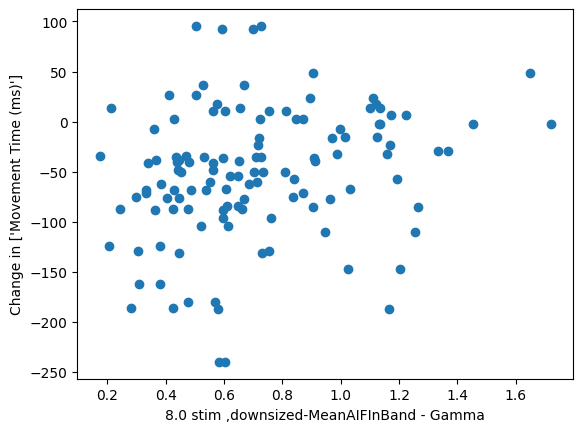

"['Movement Time (ms)'], 8.0 stim ,downsized-MeanAIFInBand - Gamma --- --- --- 0.0000, 0.0059"

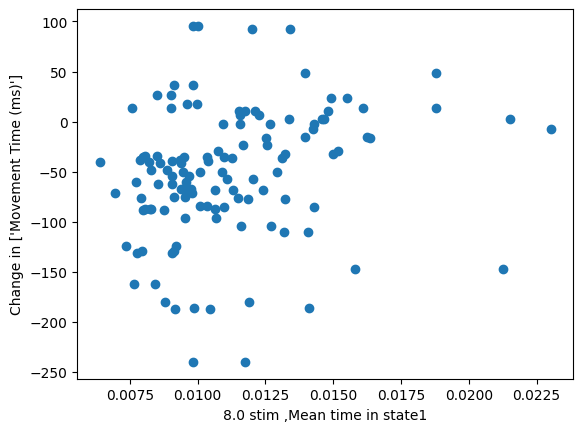

"['Movement Time (ms)'], 8.0 stim ,Mean time in state1 --- --- --- 0.0000, 0.0085"

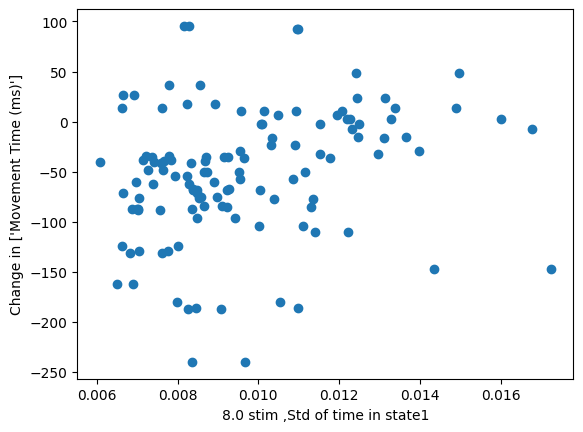

"['Movement Time (ms)'], 8.0 stim ,Std of time in state1 --- --- --- 0.0000, 0.0057"

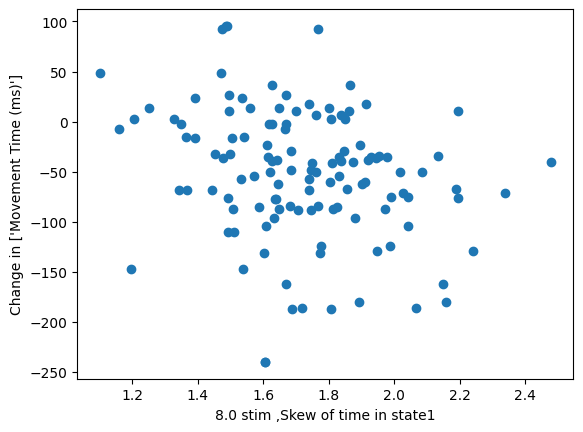

"['Movement Time (ms)'], 8.0 stim ,Skew of time in state1 --- --- --- 0.2148, 0.0056"

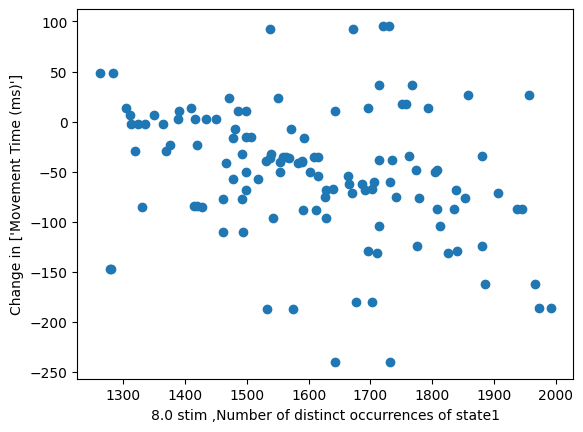

"['Movement Time (ms)'], 8.0 stim ,Number of distinct occurrences of state1 --- --- --- 0.0155, 0.0004"

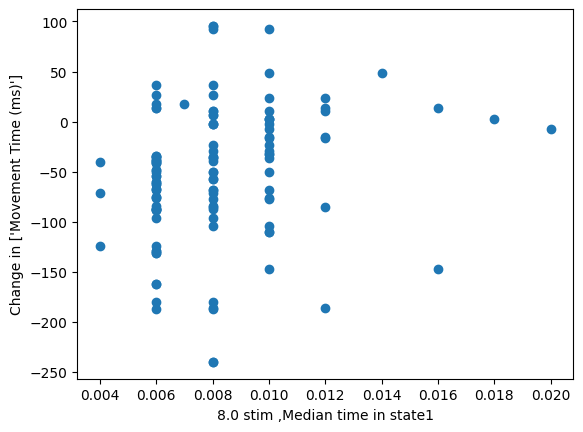

"['Movement Time (ms)'], 8.0 stim ,Median time in state1 --- --- --- 0.0000, 0.0130"

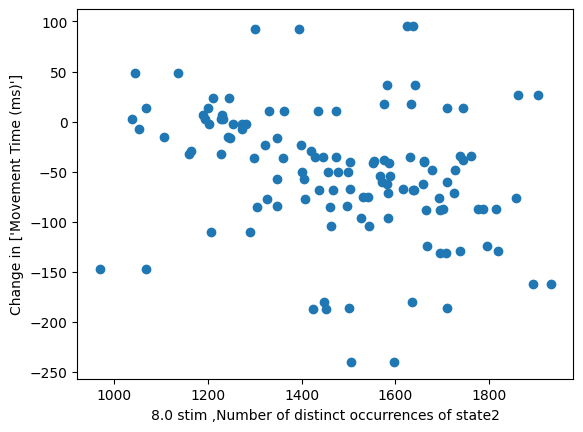

"['Movement Time (ms)'], 8.0 stim ,Number of distinct occurrences of state2 --- --- --- 0.0672, 0.0009"

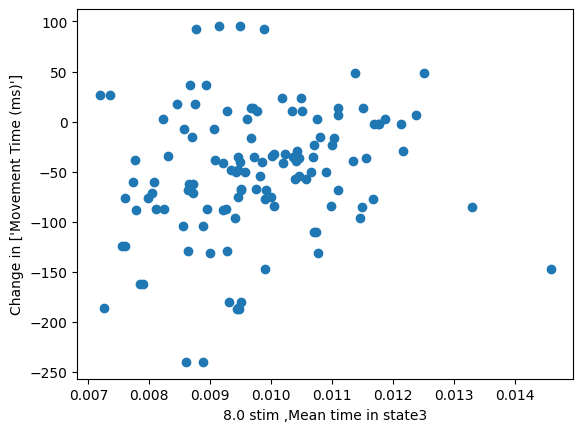

"['Movement Time (ms)'], 8.0 stim ,Mean time in state3 --- --- --- 0.0016, 0.0299"

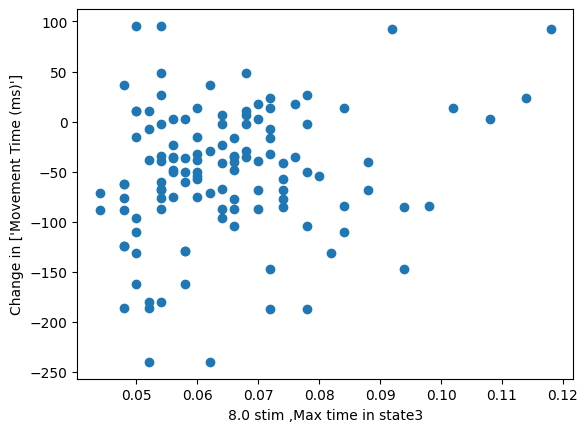

"['Movement Time (ms)'], 8.0 stim ,Max time in state3 --- --- --- 0.0001, 0.0296"

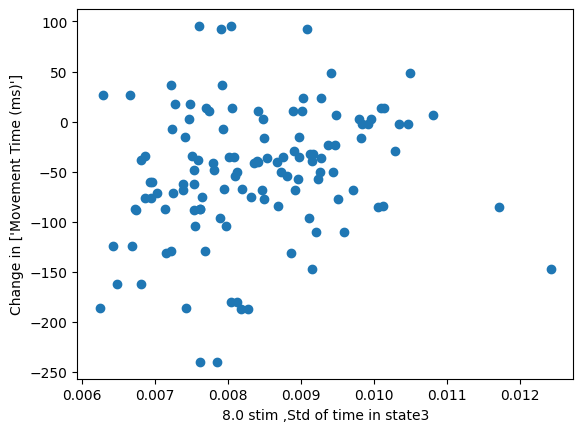

"['Movement Time (ms)'], 8.0 stim ,Std of time in state3 --- --- --- 0.0005, 0.0218"

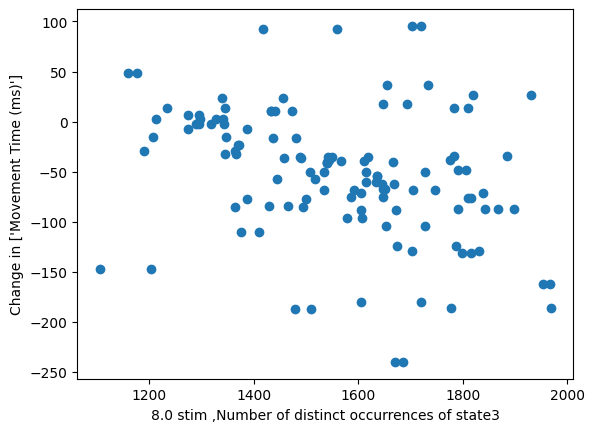

"['Movement Time (ms)'], 8.0 stim ,Number of distinct occurrences of state3 --- --- --- 0.0096, 0.0001"

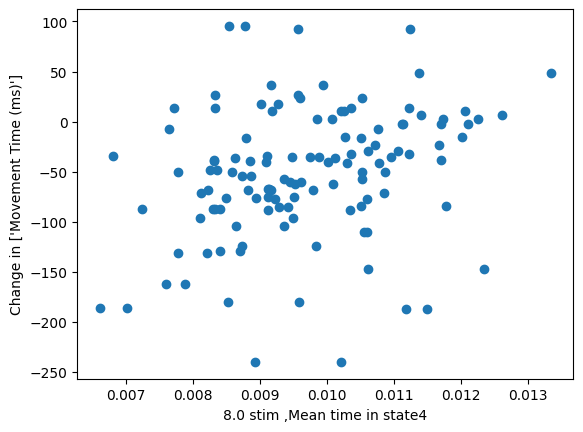

"['Movement Time (ms)'], 8.0 stim ,Mean time in state4 --- --- --- 0.0000, 0.0015"

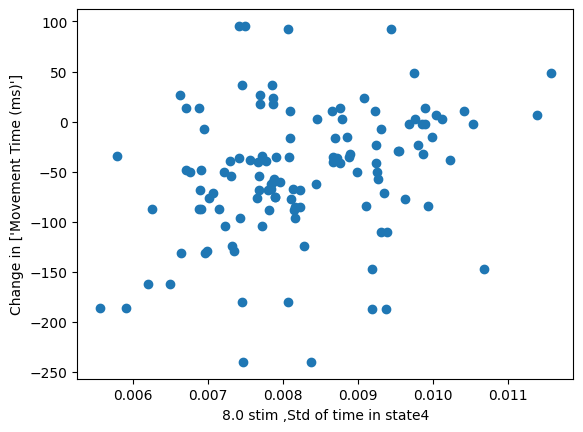

"['Movement Time (ms)'], 8.0 stim ,Std of time in state4 --- --- --- 0.0000, 0.0007"

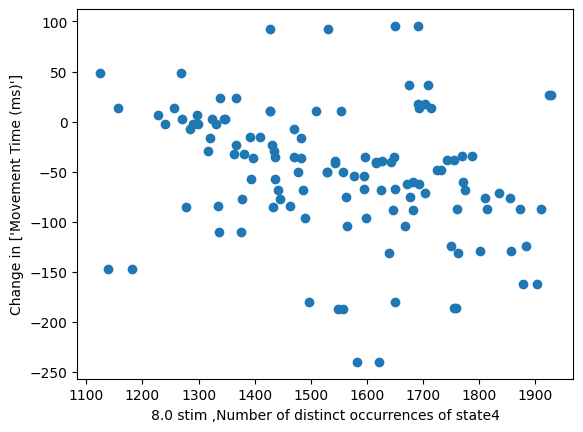

"['Movement Time (ms)'], 8.0 stim ,Number of distinct occurrences of state4 --- --- --- 0.0397, 0.0010"

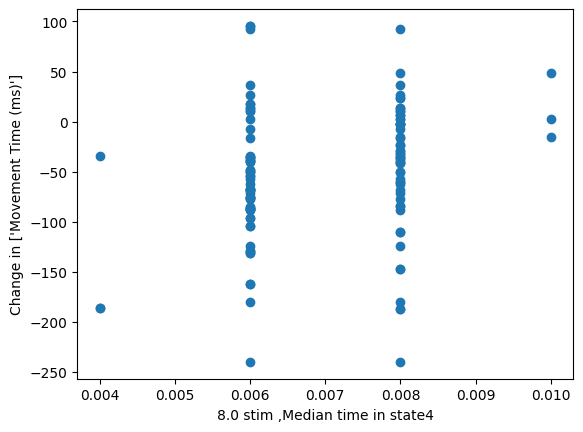

"['Movement Time (ms)'], 8.0 stim ,Median time in state4 --- --- --- 0.0004, 0.0115"

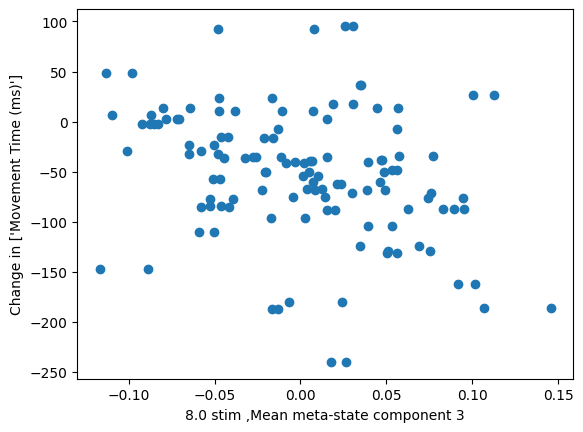

"['Movement Time (ms)'], 8.0 stim ,Mean meta-state component 3 --- --- --- 0.0091, 0.0005"

"['Squeeze Time (ms)'] 6"

SKIPPED. downsized-geoTest for Map0
SKIPPED. downsized-geoTest for Map1
SKIPPED. downsized-geoTest for Map2
SKIPPED. downsized-geoTest for Map3
SKIPPED. downsized-conditional homogeneity


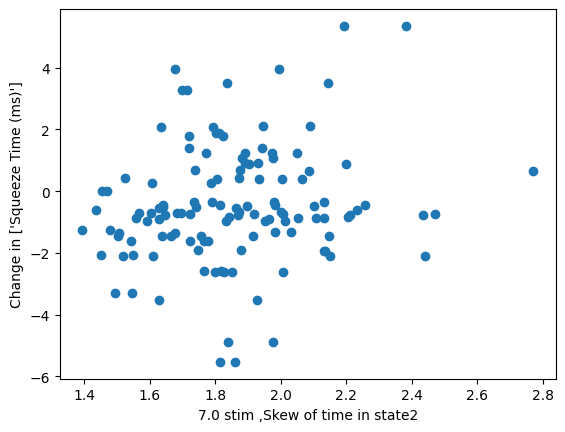

"['Squeeze Time (ms)'], 7.0 stim ,Skew of time in state2 --- --- --- 0.0134, 0.0485"

"['Squeeze Time (ms)'] 7"

SKIPPED. downsized-geoTest for Map0
SKIPPED. downsized-geoTest for Map1
SKIPPED. downsized-geoTest for Map2
SKIPPED. downsized-geoTest for Map3
SKIPPED. downsized-conditional homogeneity


"['Reaction Time (ms)'] 8"

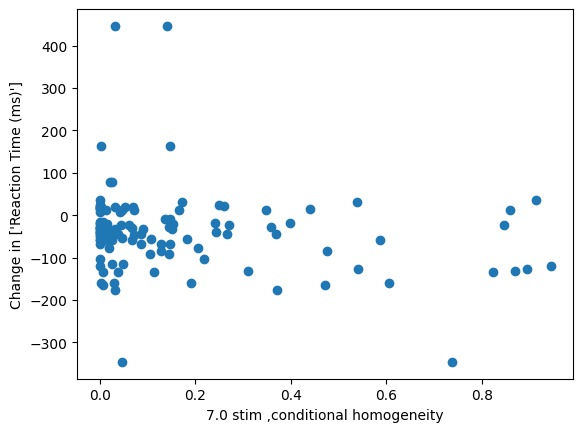

"['Reaction Time (ms)'], 7.0 stim ,conditional homogeneity --- --- --- 0.0061, 0.0257"

SKIPPED. downsized-geoTest for Map0
SKIPPED. downsized-geoTest for Map1
SKIPPED. downsized-geoTest for Map2
SKIPPED. downsized-geoTest for Map3
SKIPPED. downsized-conditional homogeneity


"['Reaction Time (ms)'] 9"

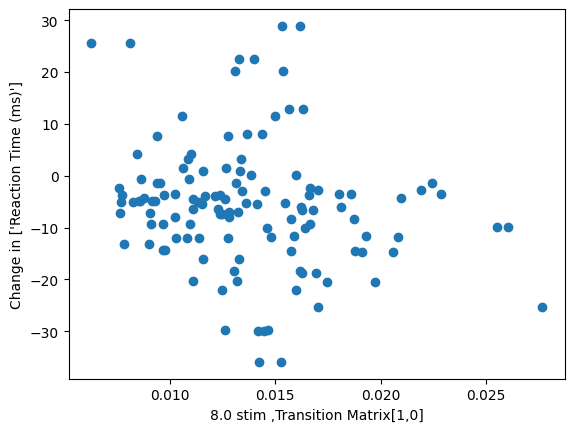

"['Reaction Time (ms)'], 8.0 stim ,Transition Matrix[1,0] --- --- --- 0.9454, 0.0443"

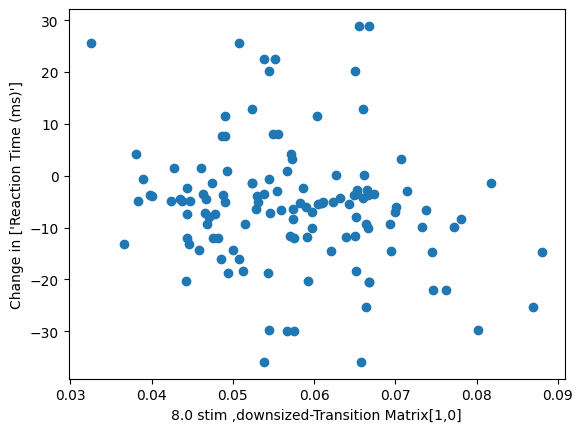

"['Reaction Time (ms)'], 8.0 stim ,downsized-Transition Matrix[1,0] --- --- --- 0.6634, 0.0357"

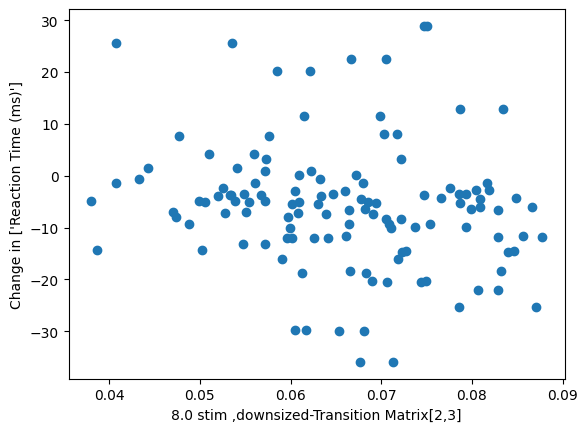

"['Reaction Time (ms)'], 8.0 stim ,downsized-Transition Matrix[2,3] --- --- --- 0.6982, 0.0426"

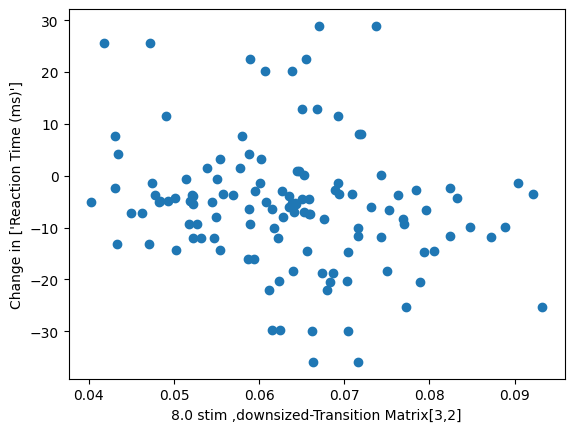

"['Reaction Time (ms)'], 8.0 stim ,downsized-Transition Matrix[3,2] --- --- --- 0.5392, 0.0143"

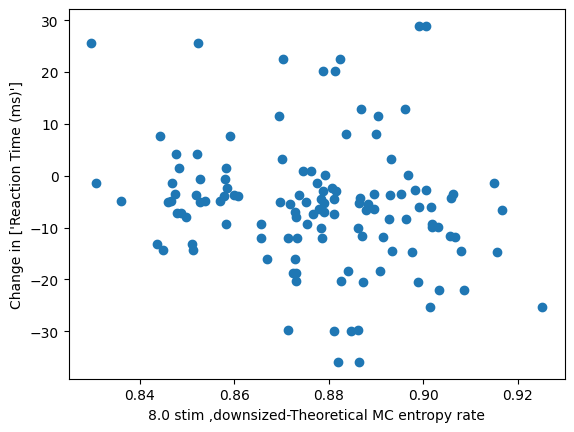

"['Reaction Time (ms)'], 8.0 stim ,downsized-Theoretical MC entropy rate --- --- --- 0.0469, 0.0285"

SKIPPED. downsized-geoTest for Map0
SKIPPED. downsized-geoTest for Map1
SKIPPED. downsized-geoTest for Map2
SKIPPED. downsized-geoTest for Map3
SKIPPED. downsized-conditional homogeneity


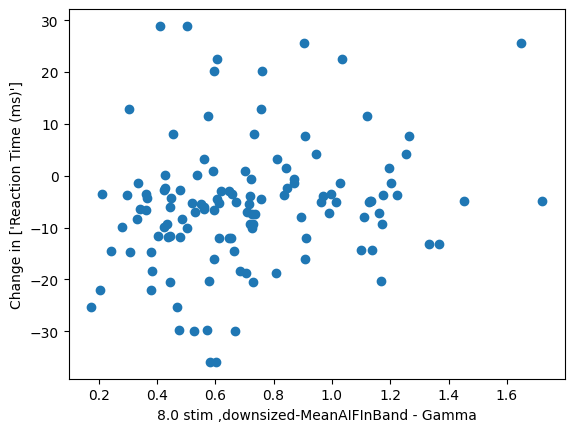

"['Reaction Time (ms)'], 8.0 stim ,downsized-MeanAIFInBand - Gamma --- --- --- 0.1303, 0.0325"

"['Peak Time (ms)'] 10"

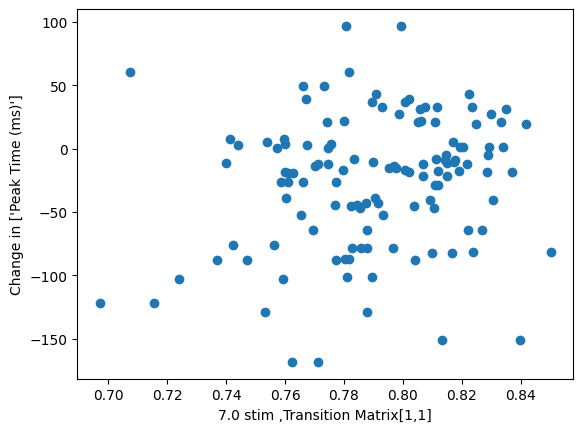

"['Peak Time (ms)'], 7.0 stim ,Transition Matrix[1,1] --- --- --- 0.0023, 0.0054"

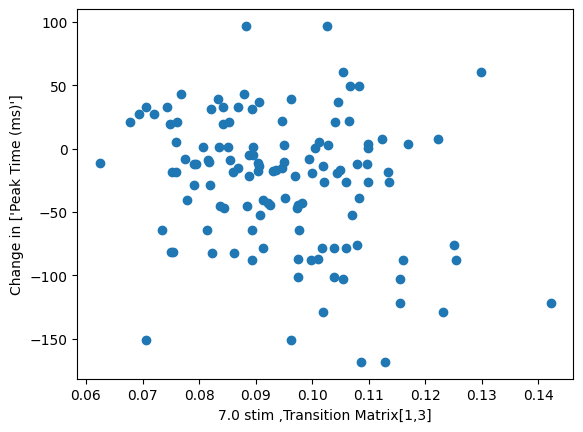

"['Peak Time (ms)'], 7.0 stim ,Transition Matrix[1,3] --- --- --- 0.0591, 0.0006"

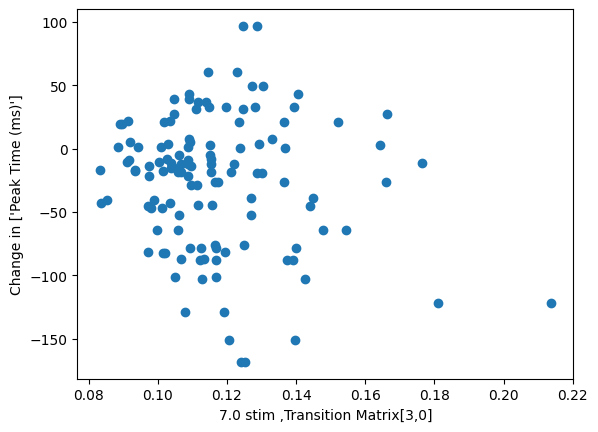

"['Peak Time (ms)'], 7.0 stim ,Transition Matrix[3,0] --- --- --- 0.6470, 0.0379"

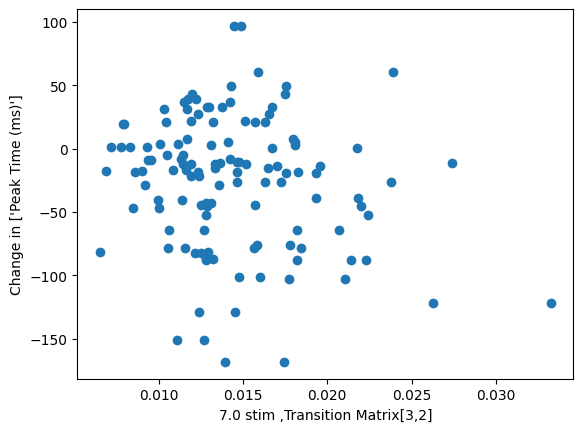

"['Peak Time (ms)'], 7.0 stim ,Transition Matrix[3,2] --- --- --- 0.9165, 0.0194"

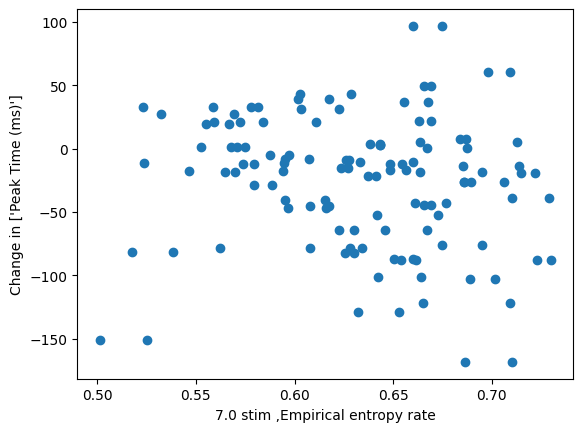

"['Peak Time (ms)'], 7.0 stim ,Empirical entropy rate --- --- --- 0.1825, 0.0362"

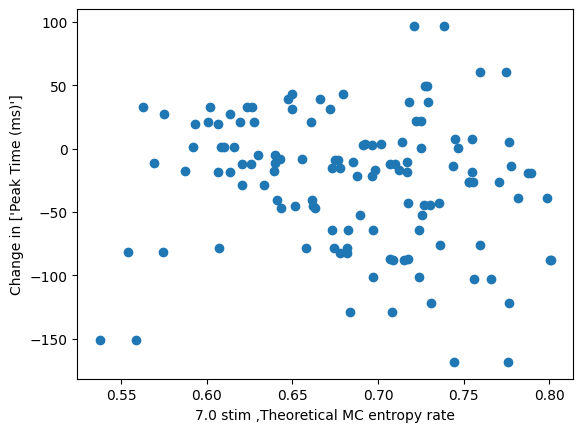

"['Peak Time (ms)'], 7.0 stim ,Theoretical MC entropy rate --- --- --- 0.2040, 0.0363"

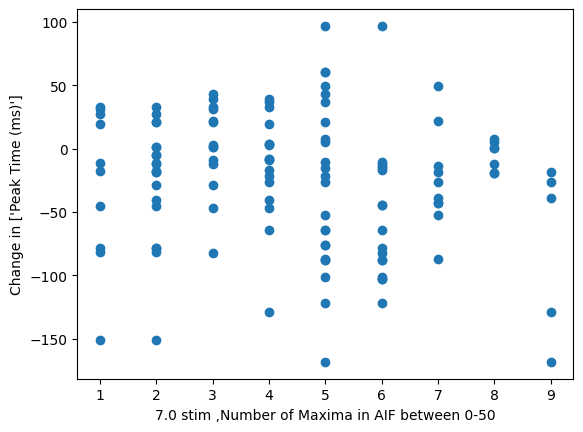

"['Peak Time (ms)'], 7.0 stim ,Number of Maxima in AIF between 0-50 --- --- --- 0.5183, 0.0450"

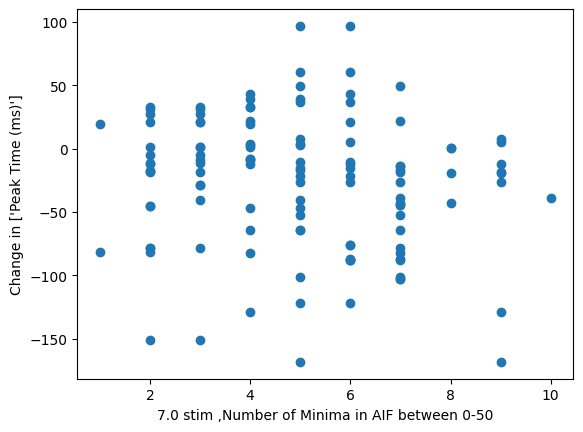

"['Peak Time (ms)'], 7.0 stim ,Number of Minima in AIF between 0-50 --- --- --- 0.6286, 0.0333"

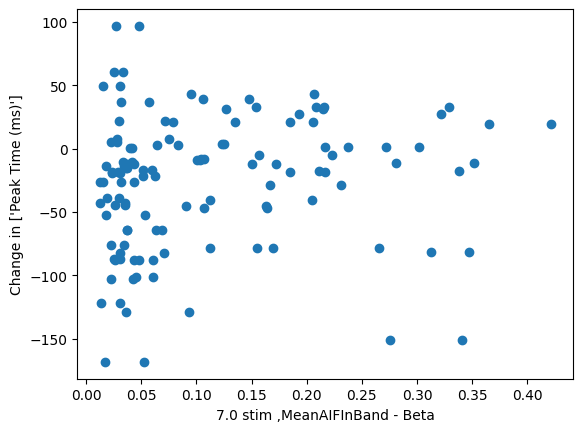

"['Peak Time (ms)'], 7.0 stim ,MeanAIFInBand - Beta --- --- --- 0.0366, 0.0417"

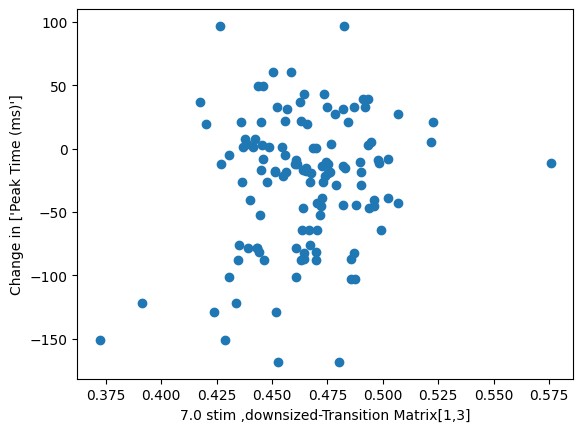

"['Peak Time (ms)'], 7.0 stim ,downsized-Transition Matrix[1,3] --- --- --- 0.0108, 0.0311"

SKIPPED. downsized-geoTest for Map0
SKIPPED. downsized-geoTest for Map1
SKIPPED. downsized-geoTest for Map2
SKIPPED. downsized-geoTest for Map3
SKIPPED. downsized-conditional homogeneity


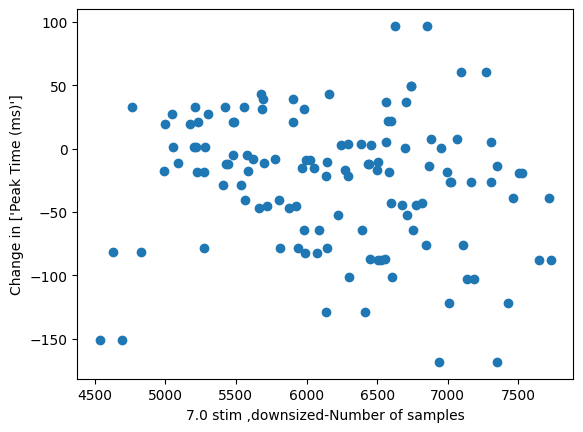

"['Peak Time (ms)'], 7.0 stim ,downsized-Number of samples --- --- --- 0.2548, 0.0216"

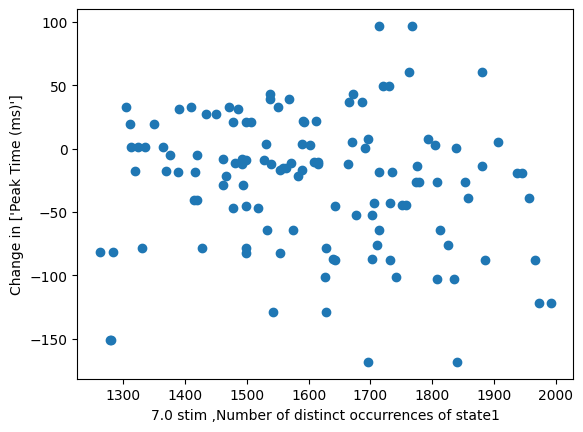

"['Peak Time (ms)'], 7.0 stim ,Number of distinct occurrences of state1 --- --- --- 0.2462, 0.0273"

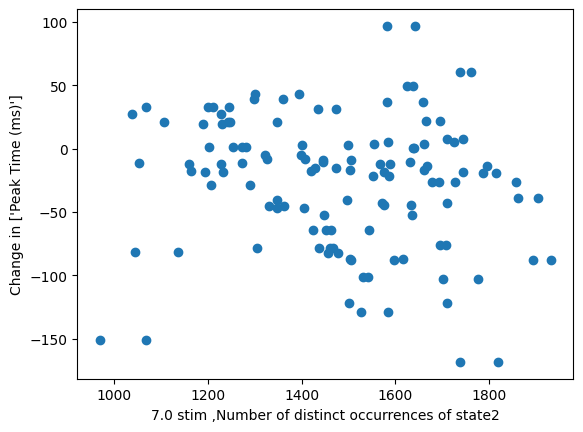

"['Peak Time (ms)'], 7.0 stim ,Number of distinct occurrences of state2 --- --- --- 0.4081, 0.0317"

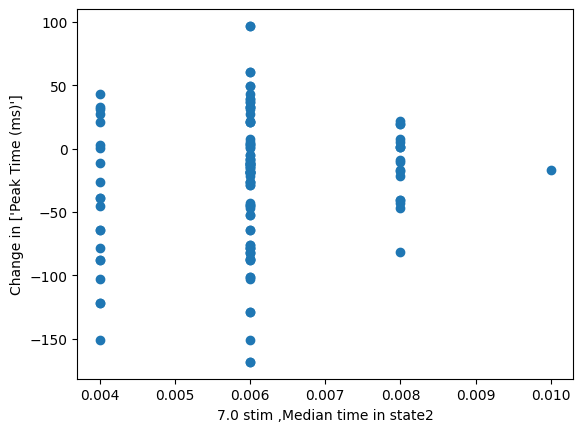

"['Peak Time (ms)'], 7.0 stim ,Median time in state2 --- --- --- 0.0070, 0.0321"

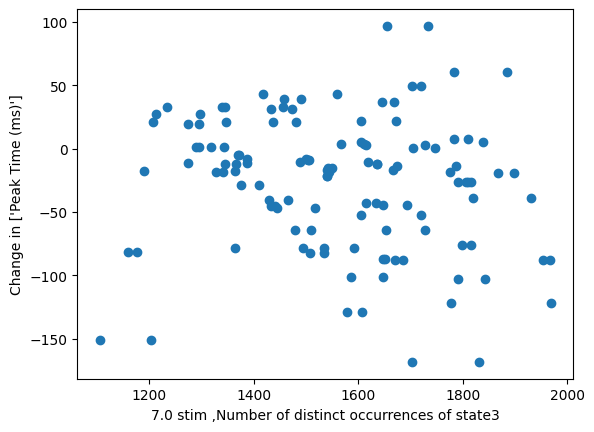

"['Peak Time (ms)'], 7.0 stim ,Number of distinct occurrences of state3 --- --- --- 0.2023, 0.0125"

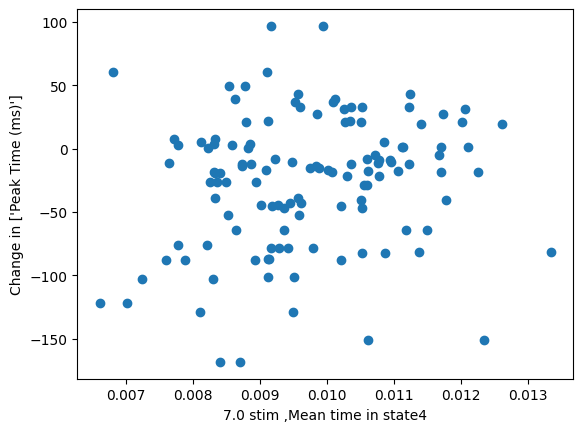

"['Peak Time (ms)'], 7.0 stim ,Mean time in state4 --- --- --- 0.0016, 0.0086"

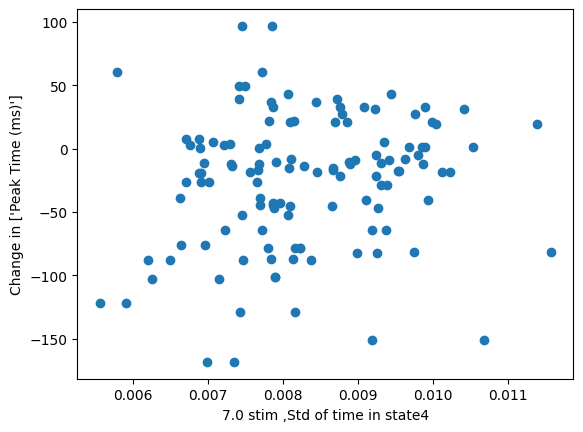

"['Peak Time (ms)'], 7.0 stim ,Std of time in state4 --- --- --- 0.0017, 0.0081"

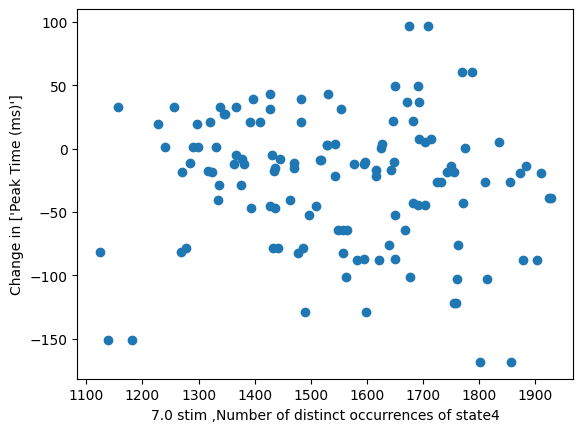

"['Peak Time (ms)'], 7.0 stim ,Number of distinct occurrences of state4 --- --- --- 0.3840, 0.0439"

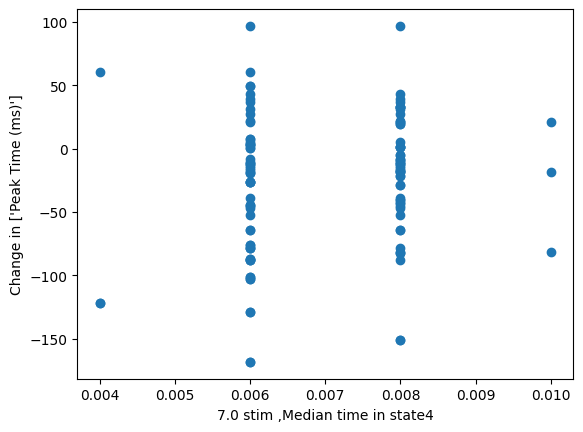

"['Peak Time (ms)'], 7.0 stim ,Median time in state4 --- --- --- 0.0046, 0.0269"

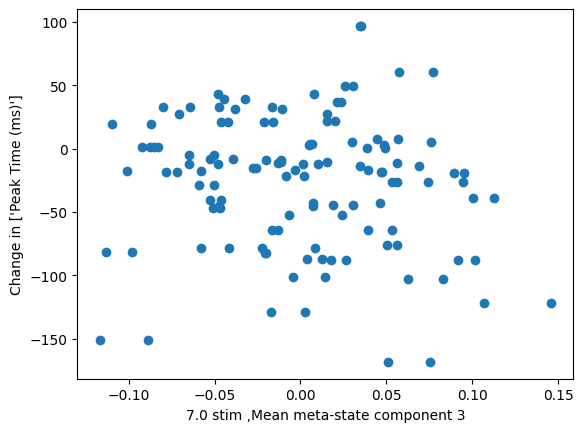

"['Peak Time (ms)'], 7.0 stim ,Mean meta-state component 3 --- --- --- 0.1009, 0.0246"

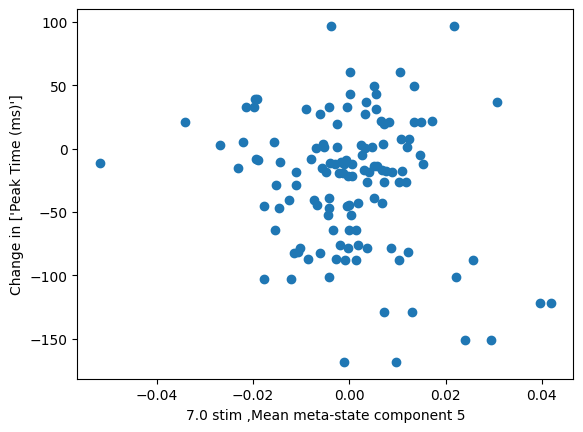

"['Peak Time (ms)'], 7.0 stim ,Mean meta-state component 5 --- --- --- 0.0849, 0.0348"

"['Peak Time (ms)'] 11"

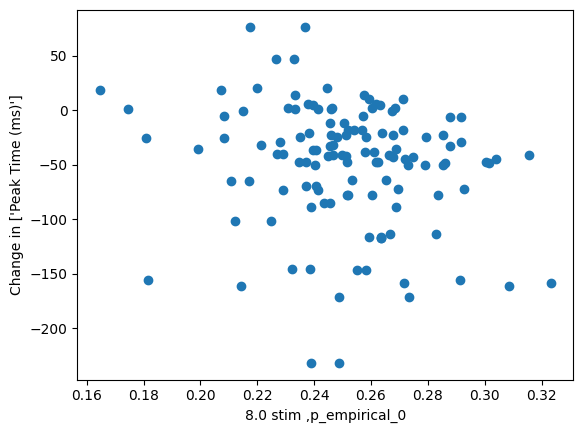

"['Peak Time (ms)'], 8.0 stim ,p_empirical_0 --- --- --- 0.4689, 0.0486"

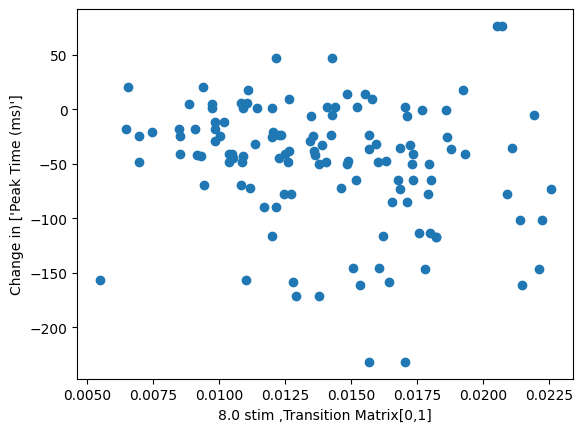

"['Peak Time (ms)'], 8.0 stim ,Transition Matrix[0,1] --- --- --- 0.6598, 0.0248"

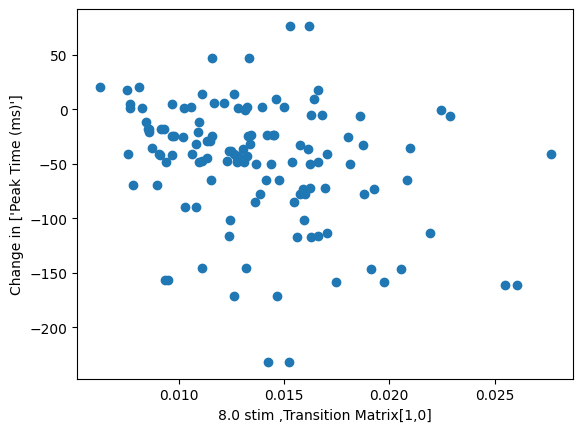

"['Peak Time (ms)'], 8.0 stim ,Transition Matrix[1,0] --- --- --- 0.7429, 0.0009"

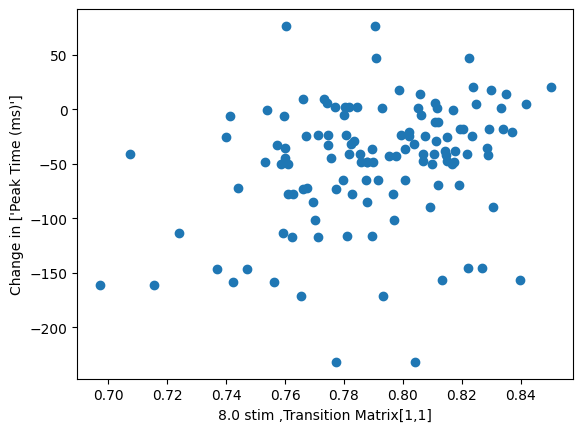

"['Peak Time (ms)'], 8.0 stim ,Transition Matrix[1,1] --- --- --- 0.0002, 0.0009"

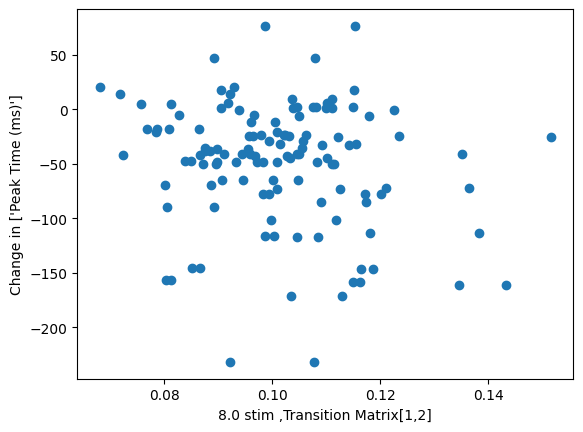

"['Peak Time (ms)'], 8.0 stim ,Transition Matrix[1,2] --- --- --- 0.5461, 0.0408"

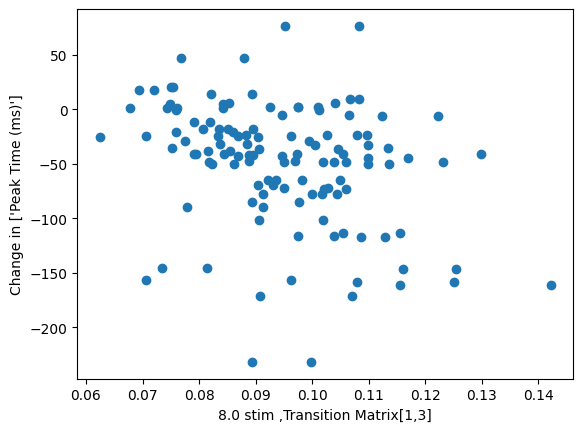

"['Peak Time (ms)'], 8.0 stim ,Transition Matrix[1,3] --- --- --- 0.0361, 0.0002"

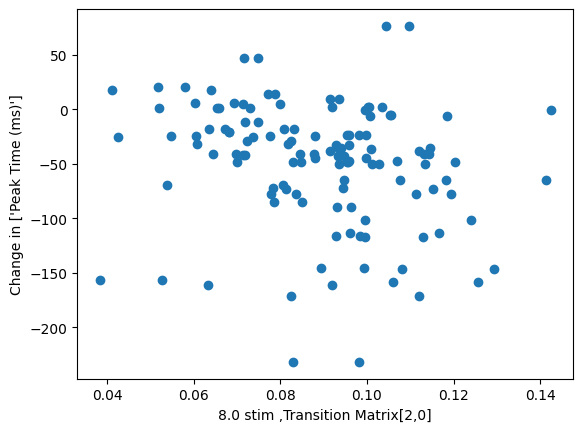

"['Peak Time (ms)'], 8.0 stim ,Transition Matrix[2,0] --- --- --- 0.7016, 0.0200"

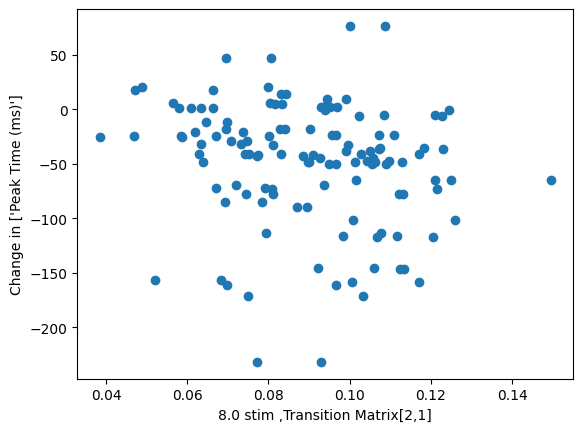

"['Peak Time (ms)'], 8.0 stim ,Transition Matrix[2,1] --- --- --- 0.8246, 0.0440"

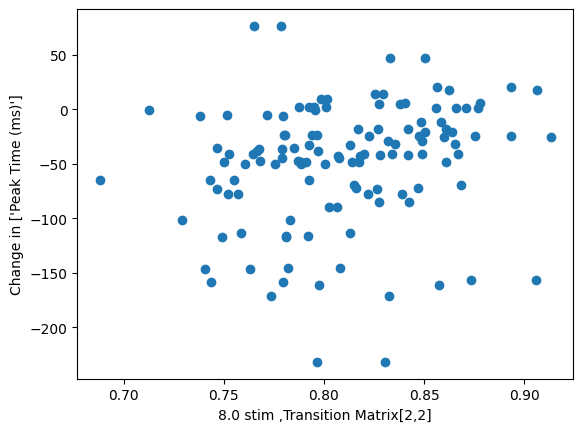

"['Peak Time (ms)'], 8.0 stim ,Transition Matrix[2,2] --- --- --- 0.0058, 0.0303"

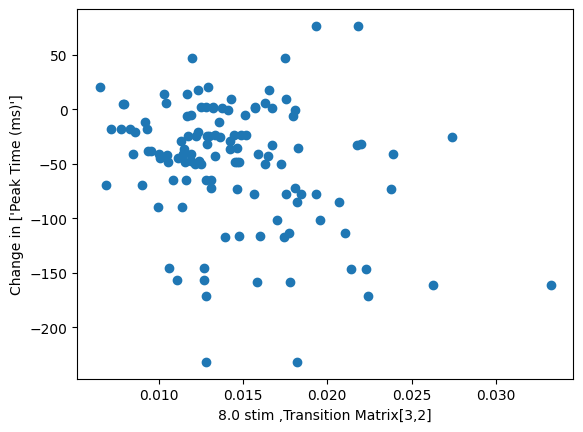

"['Peak Time (ms)'], 8.0 stim ,Transition Matrix[3,2] --- --- --- 0.9745, 0.0020"

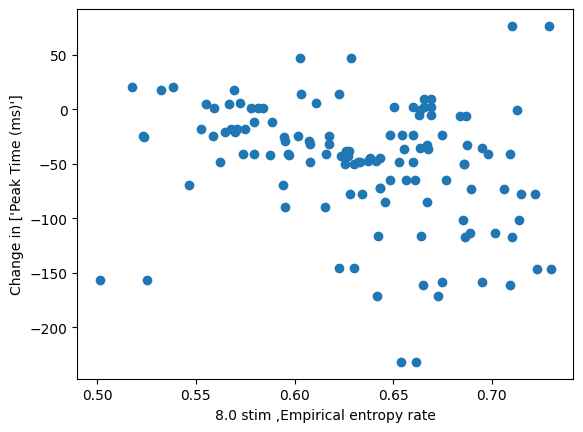

"['Peak Time (ms)'], 8.0 stim ,Empirical entropy rate --- --- --- 0.0466, 0.0034"

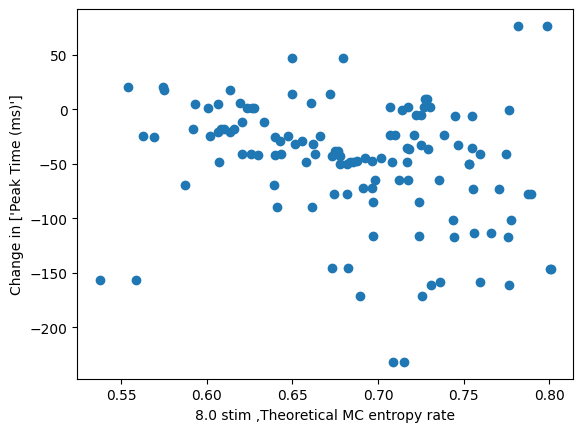

"['Peak Time (ms)'], 8.0 stim ,Theoretical MC entropy rate --- --- --- 0.0605, 0.0039"

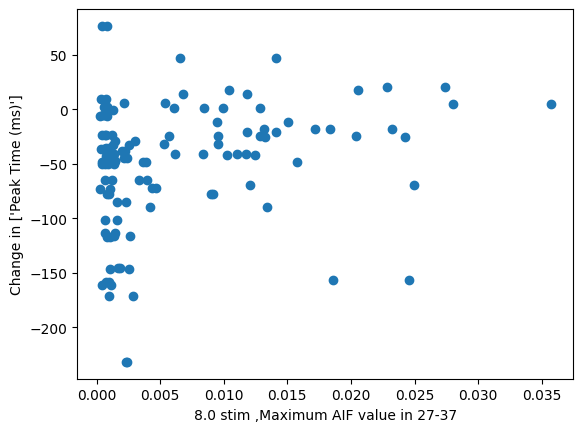

"['Peak Time (ms)'], 8.0 stim ,Maximum AIF value in 27-37 --- --- --- 0.0000, 0.0129"

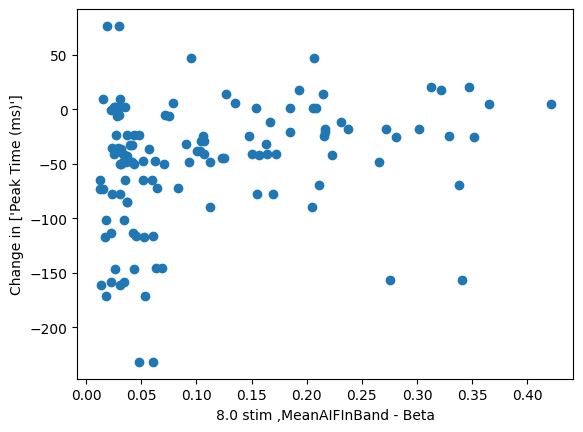

"['Peak Time (ms)'], 8.0 stim ,MeanAIFInBand - Beta --- --- --- 0.0000, 0.0026"

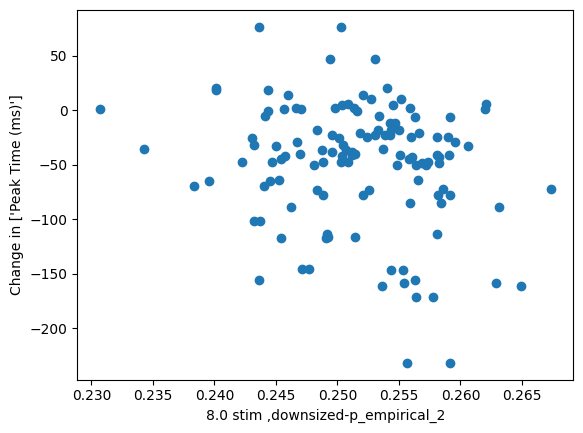

"['Peak Time (ms)'], 8.0 stim ,downsized-p_empirical_2 --- --- --- 0.0424, 0.0230"

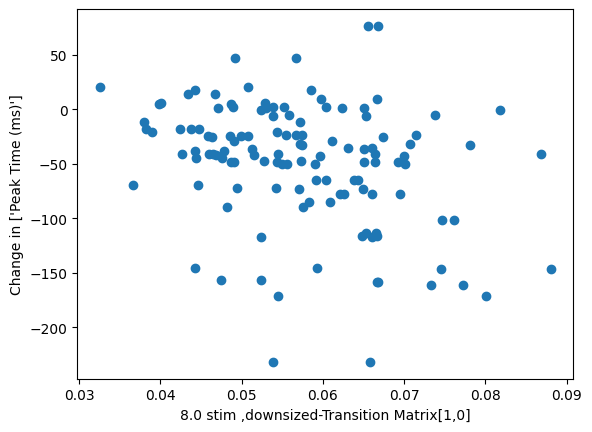

"['Peak Time (ms)'], 8.0 stim ,downsized-Transition Matrix[1,0] --- --- --- 0.1137, 0.0004"

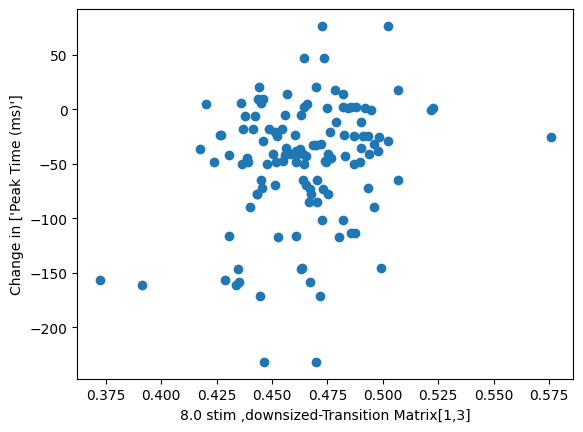

"['Peak Time (ms)'], 8.0 stim ,downsized-Transition Matrix[1,3] --- --- --- 0.0006, 0.0040"

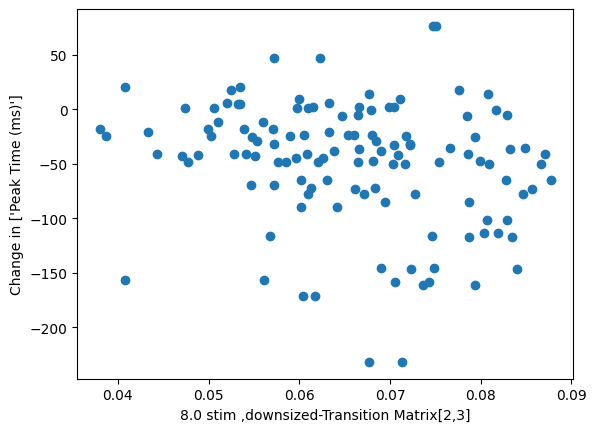

"['Peak Time (ms)'], 8.0 stim ,downsized-Transition Matrix[2,3] --- --- --- 0.7855, 0.0086"

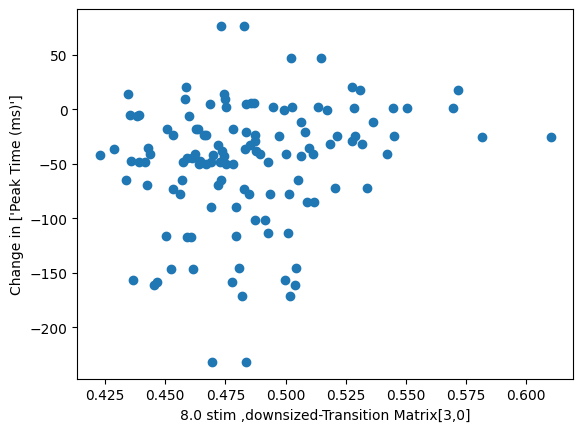

"['Peak Time (ms)'], 8.0 stim ,downsized-Transition Matrix[3,0] --- --- --- 0.0047, 0.0314"

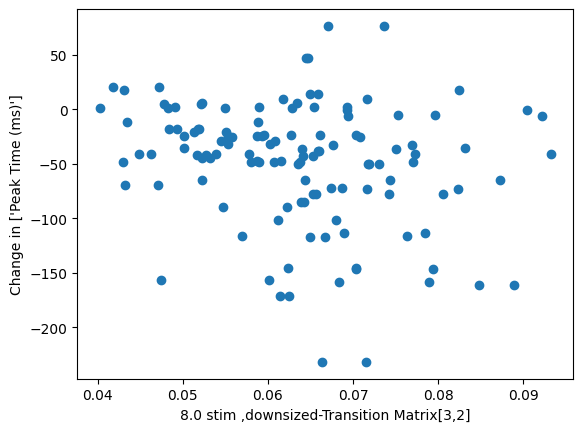

"['Peak Time (ms)'], 8.0 stim ,downsized-Transition Matrix[3,2] --- --- --- 0.4788, 0.0125"

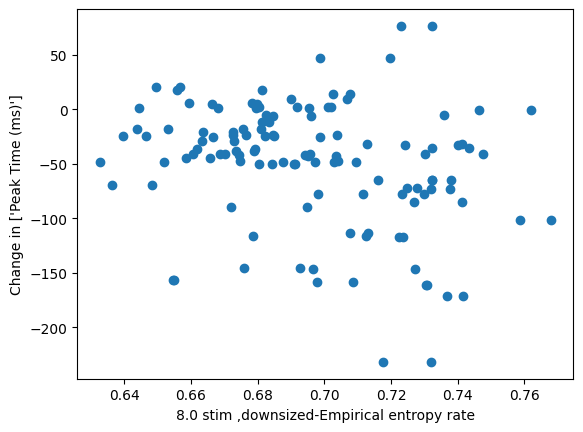

"['Peak Time (ms)'], 8.0 stim ,downsized-Empirical entropy rate --- --- --- 0.0182, 0.0042"

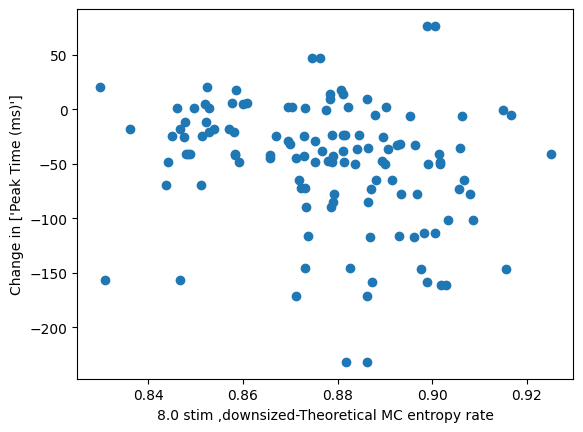

"['Peak Time (ms)'], 8.0 stim ,downsized-Theoretical MC entropy rate --- --- --- 0.0243, 0.0132"

SKIPPED. downsized-geoTest for Map0
SKIPPED. downsized-geoTest for Map1
SKIPPED. downsized-geoTest for Map2
SKIPPED. downsized-geoTest for Map3
SKIPPED. downsized-conditional homogeneity


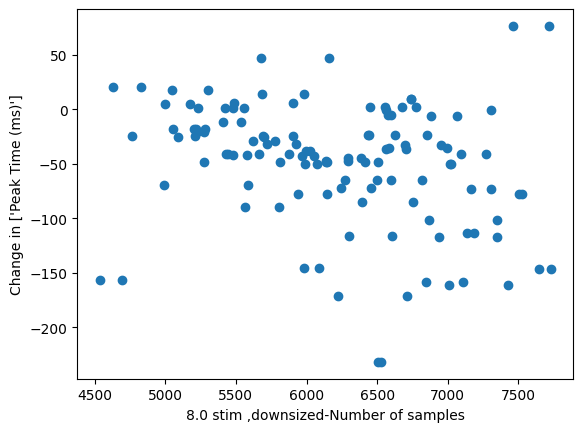

"['Peak Time (ms)'], 8.0 stim ,downsized-Number of samples --- --- --- 0.1075, 0.0029"

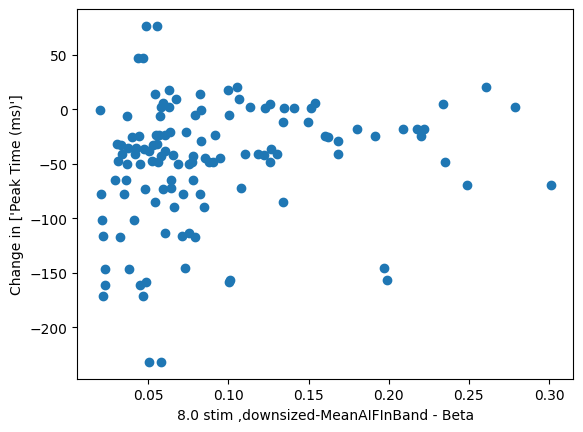

"['Peak Time (ms)'], 8.0 stim ,downsized-MeanAIFInBand - Beta --- --- --- 0.0000, 0.0279"

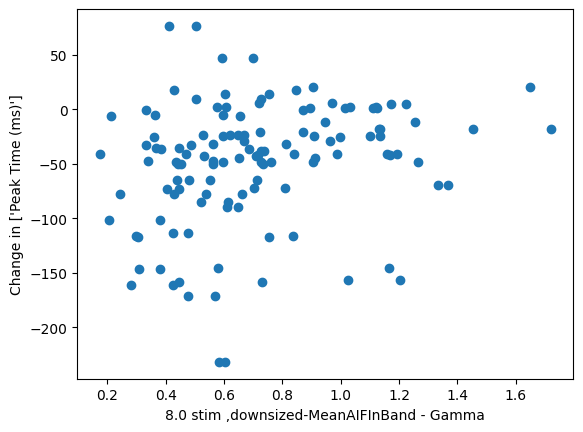

"['Peak Time (ms)'], 8.0 stim ,downsized-MeanAIFInBand - Gamma --- --- --- 0.0000, 0.0091"

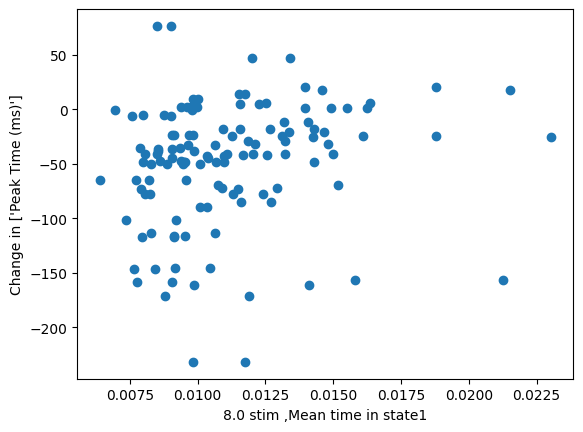

"['Peak Time (ms)'], 8.0 stim ,Mean time in state1 --- --- --- 0.0000, 0.0471"

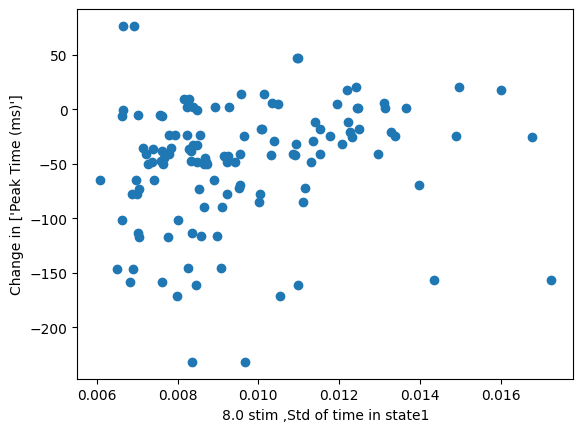

"['Peak Time (ms)'], 8.0 stim ,Std of time in state1 --- --- --- 0.0000, 0.0403"

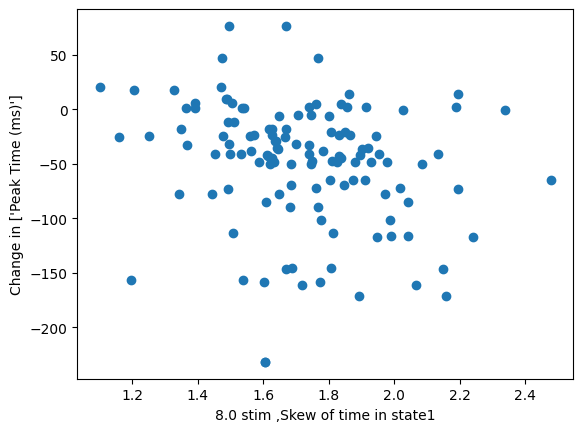

"['Peak Time (ms)'], 8.0 stim ,Skew of time in state1 --- --- --- 0.2997, 0.0140"

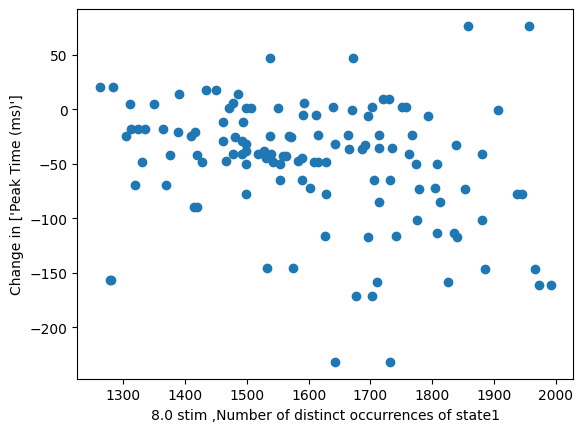

"['Peak Time (ms)'], 8.0 stim ,Number of distinct occurrences of state1 --- --- --- 0.0838, 0.0029"

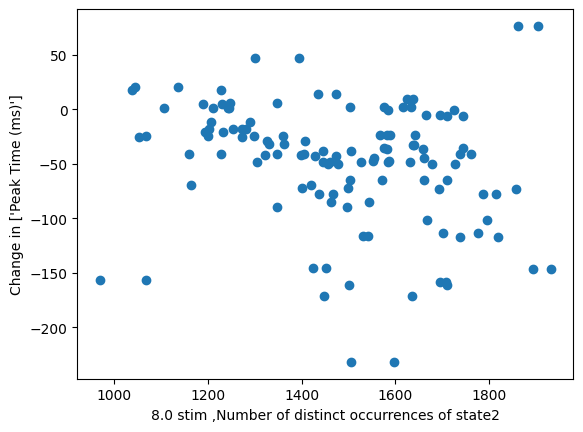

"['Peak Time (ms)'], 8.0 stim ,Number of distinct occurrences of state2 --- --- --- 0.5093, 0.0084"

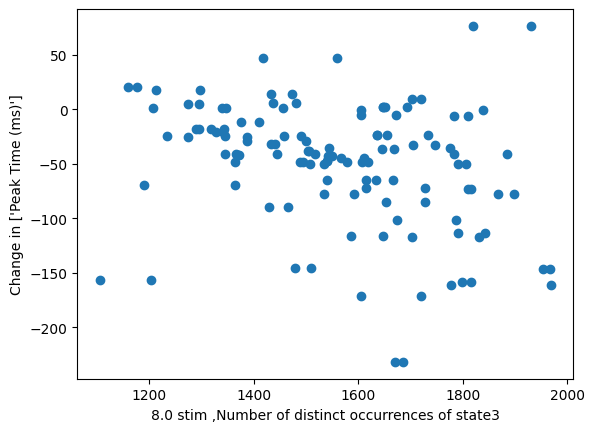

"['Peak Time (ms)'], 8.0 stim ,Number of distinct occurrences of state3 --- --- --- 0.0522, 0.0007"

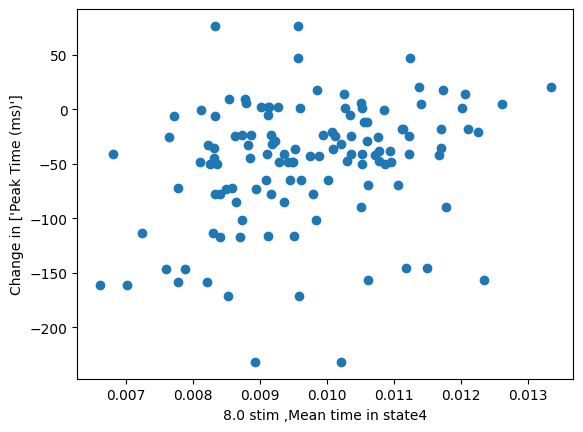

"['Peak Time (ms)'], 8.0 stim ,Mean time in state4 --- --- --- 0.0000, 0.0023"

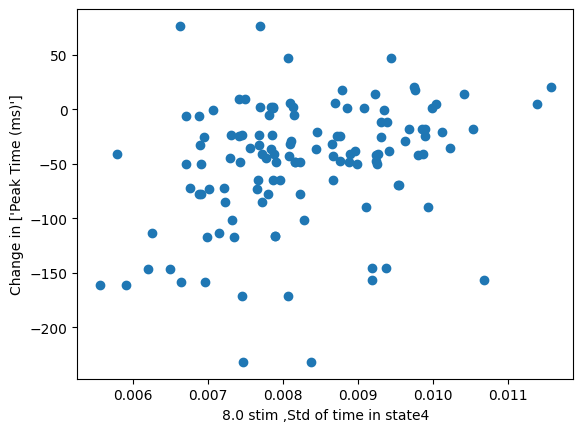

"['Peak Time (ms)'], 8.0 stim ,Std of time in state4 --- --- --- 0.0000, 0.0007"

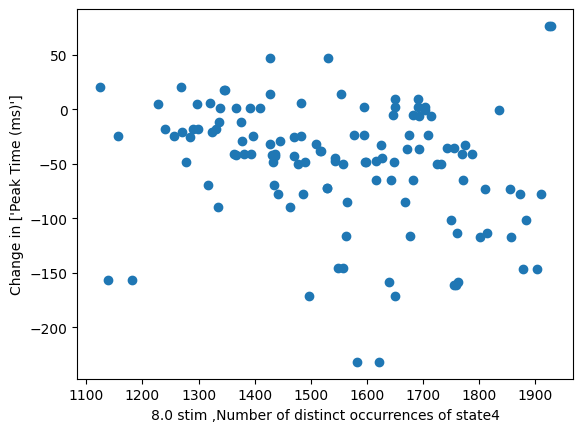

"['Peak Time (ms)'], 8.0 stim ,Number of distinct occurrences of state4 --- --- --- 0.1969, 0.0112"

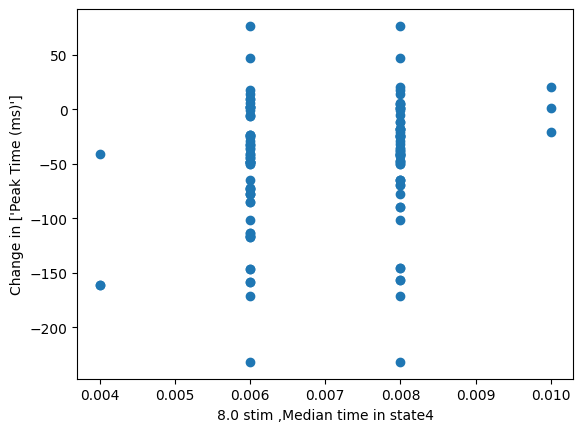

"['Peak Time (ms)'], 8.0 stim ,Median time in state4 --- --- --- 0.0001, 0.0194"

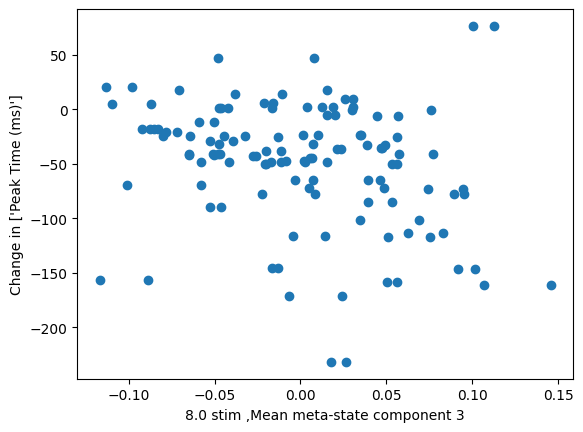

"['Peak Time (ms)'], 8.0 stim ,Mean meta-state component 3 --- --- --- 0.0000, 0.0036"

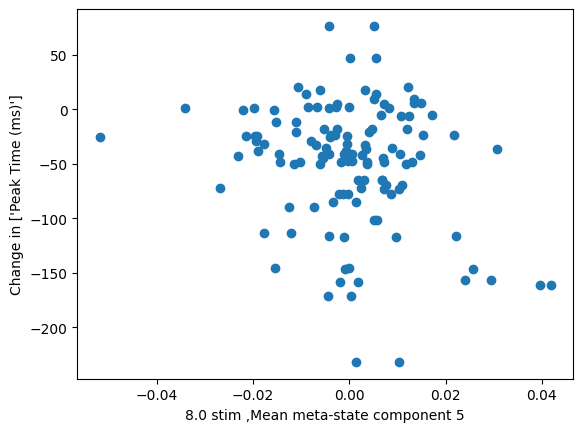

"['Peak Time (ms)'], 8.0 stim ,Mean meta-state component 5 --- --- --- 0.0000, 0.0103"

In [9]:

# As we are using the PATIENT_DATAFRAME for combined GVS on and off comparisons,
# create a version that repeats all patients to align with data arrays for combined data
PATIENT_DATAFRAME_GVSON =  PATIENT_DATAFRAME.copy()
PATIENT_DATAFRAME_GVSON.index += PATIENT_DATAFRAME_GVSON.shape[0]
PATIENT_DATAFRAME_COMBINED = pd.concat([PATIENT_DATAFRAME, PATIENT_DATAFRAME_GVSON])

# because improved_amount_matrix has # columns: (num_stim * len(gvs_feature_names), we can get num_stim)
num_stim = len(improved_amount_matrix.T) / len(gvs_feature_names)

# Iterate over every feat-stim combination
for f,improve_feat in enumerate(improved_amount_matrix.T):
    
    # Get the name of the improvement feature
    sqfeat_id = gvs_feature_names[int(f/num_stim)]
    display(f"{sqfeat_id:} {f:}")

    # Iterate over every extracted feature
    for e,extr_feature in enumerate(feature_matrix.T):

        PATIENT_DATAFRAME_TEMP = PATIENT_DATAFRAME_COMBINED.copy()
                
        # Add these features to the temporary dataset
        PATIENT_DATAFRAME_TEMP['Feat'] = extr_feature
        PATIENT_DATAFRAME_TEMP['Change'] = np.r_[improve_feat,improve_feat] # doubled as its one per patient and we are doing GVSoff and on per pt.
        
        # Clean data- remove nulls
        PATIENT_DATAFRAME_TEMP = PATIENT_DATAFRAME_TEMP[PATIENT_DATAFRAME_TEMP['Feat'].notnull()]
        PATIENT_DATAFRAME_TEMP = PATIENT_DATAFRAME_TEMP[PATIENT_DATAFRAME_TEMP['Change'].notnull()]
        
        # If the data is junk (all nulls in a feature, for instance) we skip it
        if np.all(np.isnan(PATIENT_DATAFRAME_TEMP['Feat'].values)):
            print(f"SKIPPED. {feat_names[e]:}")
            continue
            
        # Separate data based on status
        # (Currently unused: but if we want to only look at PD for instance, we can use)
        # PATIENT_DATAFRAME_TEMP[~hc]
        hc = PATIENT_DATAFRAME_TEMP['Status'] == 0
        pdon = PATIENT_DATAFRAME_TEMP['Status'] == 1
        pdoff = PATIENT_DATAFRAME_TEMP['Status'] == 2
        
        
        # Run a mixed linear model grouping based off the group defined earlier
        md = smf.mixedlm("Change ~ Feat", PATIENT_DATAFRAME_TEMP,groups=PATIENT_DATAFRAME_TEMP[MIXEDLM_GROUPING])
        try:
            mdf = md.fit()
        except:
            continue; # fit model
            
        def extract_pvals(mdf):
            sdf = np.nan * np.ones((mdf.k_fe + mdf.k_re2 + mdf.k_vc, 6))
            sdf[0:mdf.k_fe, 0] = mdf.fe_params # Coefficient estimates
            sdf[0:mdf.k_fe, 1] = np.sqrt(np.diag(mdf.cov_params()[0:mdf.k_fe])) # Standard errors
            sdf[0:mdf.k_fe, 2] = sdf[0:mdf.k_fe, 0] / sdf[0:mdf.k_fe, 1] # Z-scores
            sdf[0:mdf.k_fe, 3] = 2 * norm.cdf(-np.abs(sdf[0:mdf.k_fe, 2])) # p-values
            return sdf[0:mdf.k_fe, 3]
                                                                                               
        # We only display the data if it is relevant (otherwise it would be too much)
        if extract_pvals(mdf)[1] <= MIXEDLM_THRESHOLD:
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
                y_ = f
                sqfeat_id = gvs_feature_names[int(y_/num_stim)]
                sqstim = 7+y_%num_stim

                # Create plot and display
                plt.scatter(PATIENT_DATAFRAME_TEMP["Feat"],PATIENT_DATAFRAME_TEMP["Change"])
                plt.xlabel(f"{sqstim:} stim ,{feat_names[e]:}")
                plt.ylabel(f"Change in {sqfeat_id:}")
                plt.show()
                    
                display(f"{sqfeat_id:}, {sqstim:} stim ,{feat_names[e]:} --- --- --- {extract_pvals(mdf)[0]:.4f}, {extract_pvals(mdf)[1]:.4f}")


In [10]:
print("Done!")

Done!
